In [1]:
!pip install phik
!pip install sentence-transformers


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np
import re
from scipy import stats
import phik

from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine
from pathlib import Path
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../src'))
import data_preprocessing 

from tqdm import tqdm
import random

from collections import Counter

In [3]:
sns.set_style("whitegrid")

In [4]:
BASE_DIR = Path('result_analysis.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('data/results')

# Initial Dataset

In [5]:
DATASETS_NAME = "datasets_name.csv"
DATASETS_DIR = BASE_DIR.joinpath('data/datasets')
DATASETS_NAME = DATASETS_DIR.joinpath(DATASETS_NAME)
datasets_name = pd.read_csv(
    DATASETS_NAME, 
    sep=",", 
    header=0
)

datasets_name

INPUT:wordset INPUT:dataset_name  \
0     able amaze fill glad stop daily fantastic move...        amazon_food   
1     able amaze fill stop glad daily fantastic move...        amazon_food   
2     able amaze fill stop glad daily fantastic move...        amazon_food   
3     able amaze glad fill stop fantastic daily move...        amazon_food   
4     absolute church truth doug scripture symbol li...       20newsgroups   
...                                                 ...                ...   
3856  year two size old every last month start since...        amazon_food   
3857  year two size old every last month start week ...        amazon_food   
3858  year two size old last month every start week ...        amazon_food   
3859  year work two every size old last month start ...        amazon_food   
3860  year work two size old last month start long w...        amazon_food   

      ASSIGNMENT:worker_id  
0                        3  
1                       12  
2                        3  
3                        3  
4                        5  
...                    ...  
3856                     3  
3857                     6  
3858                     3  
3859                     3  
3860                     3  

[3861 rows x 3 columns]

In [6]:
print("Datasets:", list(set(datasets_name["INPUT:dataset_name"])))

Datasets: ['20newsgroups', 'amazon_food']


In [7]:
# Divide the entire dataset into parts by the dataset name
amazon_food_data = datasets_name[datasets_name["INPUT:dataset_name"]=="amazon_food"]
newsgroups_data = datasets_name[datasets_name["INPUT:dataset_name"]=="20newsgroups"]

amazon_food_texts = amazon_food_data["INPUT:wordset"]
newsgroups_texts = newsgroups_data["INPUT:wordset"]

# Classification

In [8]:
def extract_answer_no_yes(input_string, llama=False):
    matches = re.findall(r'\b\w*\s*(YES|NO)\s*\w*\b', input_string)   
    if len(matches) == 0:
        return "None"
    return matches[0] if llama else matches[-1]


def extract_answer_four_classes(input_string, answer_type="number"):
    # res_answer = input_string.split(".")[0]
    # Lowercase
    res_answer = input_string.lower()
    # Remove extra spaces
    res_answer = res_answer.strip()
    
    if answer_type == "number":

        res_answer = re.search(r'\d+', res_answer)
    
        if res_answer:
            res_answer = int(res_answer.group())
        else:
            res_answer = -1
    
        match_map = {
            -1: "None",
            0: "bad",
            1: "rather_bad",
            2: "rather_good",
            3: "good"
        }
        res_answer = match_map[res_answer]

    elif answer_type == "words":
        res = re.findall(r'\b\w*\s*(rather yes|rather no)\s*\w*\b', res_answer)
        if len(res) == 0:
            res = re.findall(r'\b\w*\s*(yes|no)\s*\w*\b', res_answer)
        
        res_answer = "None" if len(res) == 0 else res[0]

        match_map = {
            "None": "None",
            "no": "bad",
            "rather no": "rather_bad",
            "rather yes": "rather_good",
            "yes": "good"
        }

        res_answer = match_map[res_answer]       
    
    return res_answer


def extract_answer_five_classes(input_string, answer_type="number"):
    # res_answer = input_string.split(".")[0]
    # Lowercase
    res_answer = input_string.lower()
    # Remove extra spaces
    res_answer = res_answer.strip()
    
    if answer_type == "number":

        res_answer = re.search(r'-?[0-9]\d*', res_answer)
    
        if res_answer:
            res_answer = int(res_answer.group())
        else:
            res_answer = None

    elif answer_type == "words":
        res = re.findall(r'\b\w*\s*(rather yes|rather no)\s*\w*\b', res_answer)
        if len(res) == 0:
            res = re.findall(r'\b\w*\s*(yes|no)\s*\w*\b', res_answer)
        if len(res) == 0:
            res = re.findall(r'\b\w*\s*(neutral)\s*\w*\b', res_answer)
        
        res_answer = "None" if len(res) == 0 else res[0]

        match_map = {
            "None": None,
            "no": -2,
            "rather no": -1,
            "neutral": 0,
            "rather yes": 1,
            "yes": 2
        }

        res_answer = match_map[res_answer]       
    
    return res_answer

In [335]:
def print_answers_distrib(df, model_name='', dataset_name='', fig_size=(8, 6), class_num=4):
    df = df[["true", "model"]]
    df.columns = ["Human", "Model"]
    df_long = df.melt(var_name='Column', value_name='Response')

    if class_num == 5:
        category_order = ["bad", "rather_bad", "neutral", "rather_good", "good"]
    else:
        category_order = ["bad", "rather_bad", "rather_good", "good"]

    df_long['Response'] = pd.Categorical(df_long['Response'], categories=category_order, ordered=True)

    palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

    plt.figure(figsize=fig_size)

    ax = sns.histplot(
        data=df_long, 
        x='Response', 
        hue='Column', 
        multiple='dodge', 
        shrink=0.8, 
        palette=palette_colors,
    )

    for i in ax.containers:
        ax.bar_label(i,)

    # Установка заголовка
    plt.title(f'Distribution of Human and {model_name} answers. {dataset_name}')

    # Отображение графика
    plt.show()


In [338]:
def conf_matrix(
        true, 
        predict, 
        model_name="", 
        num_classes=2,
        heatmap_fontsize=10, 
        axis_label_fontsize=13, 
        title_fontsize=17,
        ticklabel_fontsize=20
    ):
    
    cm = confusion_matrix(true, predict)

    if num_classes == 2:
        class_labels = {-2: 'bad', 2: 'good'}
        sns.heatmap(cm, 
                    annot=True,
                    fmt='g',
                    xticklabels=[class_labels[label] for label in [-2, 2]],
                    yticklabels=[class_labels[label] for label in [-2, 2]],
                    annot_kws={"fontsize": heatmap_fontsize}
        )
    elif num_classes == 4:
        class_labels = {
            -2: 'bad', 
            -1: 'rather_bad',
            1: 'rather_good',
            2: 'good'}
        sns.heatmap(cm, 
                    annot=True,
                    fmt='g', 
                    xticklabels=[class_labels[label] for label in [-2, -1, 1, 2]],
                    yticklabels=[class_labels[label] for label in [-2, -1, 1, 2]],
                    annot_kws={"fontsize": heatmap_fontsize}
        )
    elif num_classes == 5:
        class_labels = {
            -2: 'bad', 
            -1: 'rather_bad',
            0: 'neutral',
            1: 'rather_good',
            2: 'good'}
        sns.heatmap(cm, 
                    annot=True,
                    fmt='g', 
                    xticklabels=[class_labels[label] for label in [-2, -1, 0, 1, 2]],
                    yticklabels=[class_labels[label] for label in [-2, -1, 0, 1, 2]],
                    annot_kws={"fontsize": heatmap_fontsize}
        )
    
    plt.ylabel('Actual',fontsize=axis_label_fontsize)
    plt.xlabel('Prediction',fontsize=axis_label_fontsize)
    plt.title(f'Confusion Matrix {model_name}',fontsize=title_fontsize)

    plt.xticks(fontsize=ticklabel_fontsize)
    plt.yticks(fontsize=ticklabel_fontsize)

    plt.show()


def plot_phi_corel(amazon_data, newsgroups_data, model_name=""):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    fig.suptitle(model_name, fontsize=16)

    # Phi-K
    ph_matrix_amazon = amazon_data.phik_matrix()
    sns.heatmap(
        ph_matrix_amazon, 
        annot=True,
        fmt='g',
        ax=axs[0])
    axs[0].set_title("Amazon Phik correlation coefficient")

    # Phi-K
    ph_matrix_newsgroups = newsgroups_data.phik_matrix()
    sns.heatmap(
        ph_matrix_newsgroups, 
        annot=True,
        fmt='g',
        ax=axs[1])
    axs[1].set_title("20newsgroups Phik correlation coefficient")

    plt.tight_layout()
    plt.show()


## Two classes

In [144]:
PROMPT_MISTRAL_1 = "data_qality_estim_mistral_7b_4bit_type3.csv"
PROMPT_MISTRAL_2 = "data_qality_estim_mistral_7b_4bit_type5.csv"
PROMPT_MISTRAL_3 = "data_qality_estim_mistral_7b_4bit_type6.csv"
PROMPT_LLAMA_1 = "data_qality_estim_llama_13b_4bit_type1.csv"
INITIAL = "data_quality_estim.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_LLAMA_1 = DATA_DIR.joinpath(PROMPT_LLAMA_1)

INITIAL_FILE_DIR = BASE_DIR.joinpath('data/datasets')
INITIAL_DATA = INITIAL_FILE_DIR.joinpath(INITIAL)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep=";", names=["text", "true", "model"])
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep=";", names=["text", "true", "model"])
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=";", names=["text", "true", "model"])
data_prompt_llama_1 = pd.read_csv(PROMPT_LLAMA_1, sep=";", names=["text", "true", "model"])
data_initial = pd.read_csv(INITIAL_DATA, sep=',')

### Baseline (Dummy Algorithm - The most frequent class)

In [33]:
data_initial.head(10)

task agg_label
0  able amaze fill glad stop daily fantastic move...       bad
1  able amaze fill stop glad daily fantastic move...       bad
2  able amaze fill stop glad daily fantastic move...       bad
3  able amaze glad fill stop fantastic daily move...       bad
4  absolute church truth doug scripture symbol li...      good
5  absolute church truth mission nasa doug mars e...       bad
6  absolute mission church nasa mars earth truth ...      good
7  absolutely fast white rice service noodle terr...       bad
8  absolutely fast white super service customer r...      good
9  absolutely grain experience soon there's proce...       bad

In [34]:
occurence_count = Counter(data_initial["agg_label"])
freq_class = occurence_count.most_common(1)[0][0]
data_initial["model"] = freq_class

In [41]:
# -2 - bad
# 2 - good

classes_map = {
    "bad": -2,
    "good": 2
}

data_initial["agg_label_num"] = [classes_map[x] for x in data_initial["agg_label"]]
data_initial["model_num"] = [classes_map[x] for x in data_initial["model"]]

In [42]:
# Divide into two datasets
data_initial_amazon = data_initial[data_initial["task"].isin(amazon_food_texts)]
data_initial_newsgroups = data_initial[data_initial["task"].isin(newsgroups_texts)]

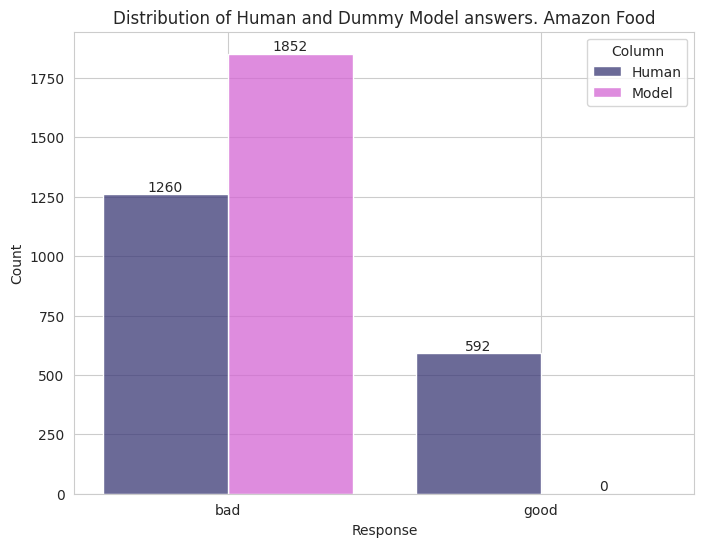

In [43]:
df = data_initial_amazon[["agg_label", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

category_order = ["bad", "good"]

df_long['Response'] = pd.Categorical(df_long['Response'], categories=category_order, ordered=True)
palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(
    data=df_long, 
    x='Response', 
    hue='Column', 
    multiple='dodge', 
    shrink=0.8, 
    palette=palette_colors,
)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title(f'Distribution of Human and Dummy Model answers. Amazon Food')

# Отображение графика
plt.show()

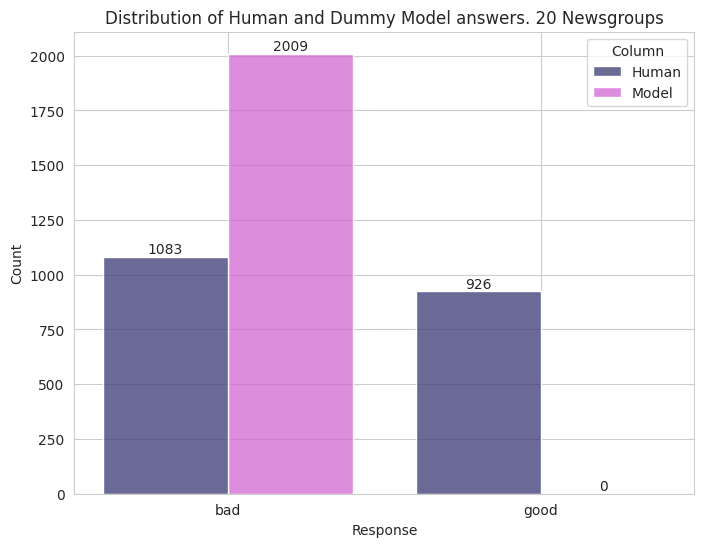

In [44]:
df = data_initial_newsgroups[["agg_label", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

category_order = ["bad", "good"]

df_long['Response'] = pd.Categorical(df_long['Response'], categories=category_order, ordered=True)
palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(
    data=df_long, 
    x='Response', 
    hue='Column', 
    multiple='dodge', 
    shrink=0.8, 
    palette=palette_colors,
)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title(f'Distribution of Human and Dummy Model answers. 20 Newsgroups')

# Отображение графика
plt.show()

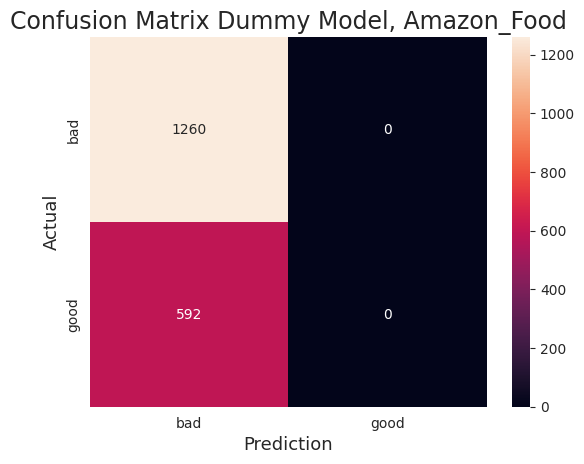

In [45]:
conf_matrix(
    np.array(data_initial_amazon["agg_label"]), 
    np.array(data_initial_amazon["model"]), 
    model_name="Dummy Model, Amazon_Food"
)

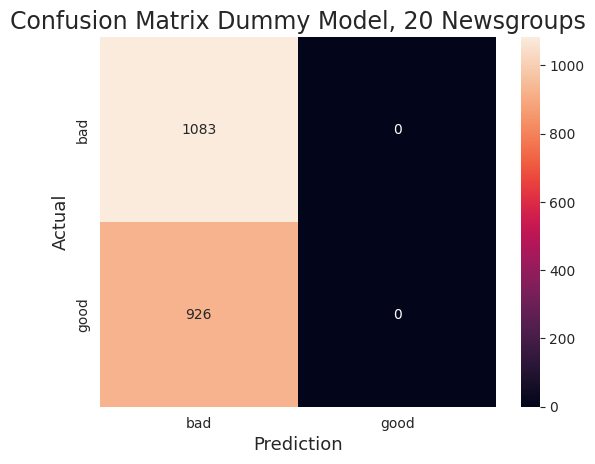

In [46]:
conf_matrix(
    np.array(data_initial_newsgroups["agg_label"]), 
    np.array(data_initial_newsgroups["model"]), 
    model_name="Dummy Model, 20 Newsgroups"
)

В данном случае невозможно посчитать корреляции

In [47]:
# non-linear dependencies amazon
data_initial_amazon[["agg_label_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['agg_label_num', 'model_num']


/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable model_num for analysis 1. Dropping this column
  warnings.warn(


agg_label_num
agg_label_num            1.0

In [48]:
# non-linear dependencies 20 Newgroups
data_initial_newsgroups[["agg_label_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['agg_label_num', 'model_num']


/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable model_num for analysis 1. Dropping this column
  warnings.warn(


agg_label_num
agg_label_num            1.0

In [49]:
data_initial_amazon[["agg_label_num", "model_num"]].corr()

agg_label_num  model_num
agg_label_num            1.0        NaN
model_num                NaN        NaN

In [50]:
data_initial_newsgroups[["agg_label_num", "model_num"]].corr()

agg_label_num  model_num
agg_label_num            1.0        NaN
model_num                NaN        NaN

In [51]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_initial_amazon["agg_label"], data_initial_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_initial_newsgroups["agg_label"], data_initial_newsgroups["model"]), 3))

Accuracy (Amazon): 0.68
Accuracy (20newsgroups): 0.539


In [54]:
# -2 - bad
# 2 - good

classes_map = {
    -2: 1,
    2: 2
}

data_initial_amazon["agg_label_num"] = [classes_map[x] for x in data_initial_amazon["agg_label_num"]]
data_initial_amazon["model_num"] = [classes_map[x] for x in data_initial_amazon["model_num"]]

data_initial_newsgroups["agg_label_num"] = [classes_map[x] for x in data_initial_newsgroups["agg_label_num"]]
data_initial_newsgroups["model_num"] = [classes_map[x] for x in data_initial_newsgroups["model_num"]]

# F1-score
print("F1-score (Amazon):", round(f1_score(data_initial_amazon["agg_label_num"], data_initial_amazon["model_num"]), 3))
print("F1-score (20newsgroups):", round(f1_score(data_initial_newsgroups["agg_label_num"], data_initial_newsgroups["model_num"]), 3))

F1-score (Amazon): 0.81
F1-score (20newsgroups): 0.701


/tmp/ipykernel_939581/717344021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_initial_amazon["agg_label_num"] = [classes_map[x] for x in data_initial_amazon["agg_label_num"]]
/tmp/ipykernel_939581/717344021.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_initial_amazon["model_num"] = [classes_map[x] for x in data_initial_amazon["model_num"]]
/tmp/ipykernel_939581/717344021.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Baseline (Uniform Random Classifier)

In [53]:
data_initial.head(10)

task agg_label
0  able amaze fill glad stop daily fantastic move...       bad
1  able amaze fill stop glad daily fantastic move...       bad
2  able amaze fill stop glad daily fantastic move...       bad
3  able amaze glad fill stop fantastic daily move...       bad
4  absolute church truth doug scripture symbol li...      good
5  absolute church truth mission nasa doug mars e...       bad
6  absolute mission church nasa mars earth truth ...      good
7  absolutely fast white rice service noodle terr...       bad
8  absolutely fast white super service customer r...      good
9  absolutely grain experience soon there's proce...       bad

In [58]:
np.random.seed(0)
data_initial["model"] = np.random.randint(2, size=data_initial.shape[0])
data_initial.head(10)

task agg_label  model  \
0  able amaze fill glad stop daily fantastic move...       bad      0   
1  able amaze fill stop glad daily fantastic move...       bad      1   
2  able amaze fill stop glad daily fantastic move...       bad      1   
3  able amaze glad fill stop fantastic daily move...       bad      0   
4  absolute church truth doug scripture symbol li...      good      1   
5  absolute church truth mission nasa doug mars e...       bad      1   
6  absolute mission church nasa mars earth truth ...      good      1   
7  absolutely fast white rice service noodle terr...       bad      1   
8  absolutely fast white super service customer r...      good      1   
9  absolutely grain experience soon there's proce...       bad      1   

   agg_label_num  model_num  
0             -2         -2  
1             -2          2  
2             -2          2  
3             -2         -2  
4              2          2  
5             -2          2  
6              2          2  
7             -2          2  
8              2          2  
9             -2          2

In [55]:
# -2 - bad
# 2 - good

classes_map = {
    "bad": -2,
    "good": 2
}

num_map = {
    0: -2,
    1: 2
}

data_initial["agg_label_num"] = [classes_map[x] for x in data_initial["agg_label"]]
data_initial["model_num"] = [num_map[x] for x in data_initial["model"]]

In [56]:
# Divide into two datasets
data_initial_amazon = data_initial[data_initial["task"].isin(amazon_food_texts)]
data_initial_newsgroups = data_initial[data_initial["task"].isin(newsgroups_texts)]

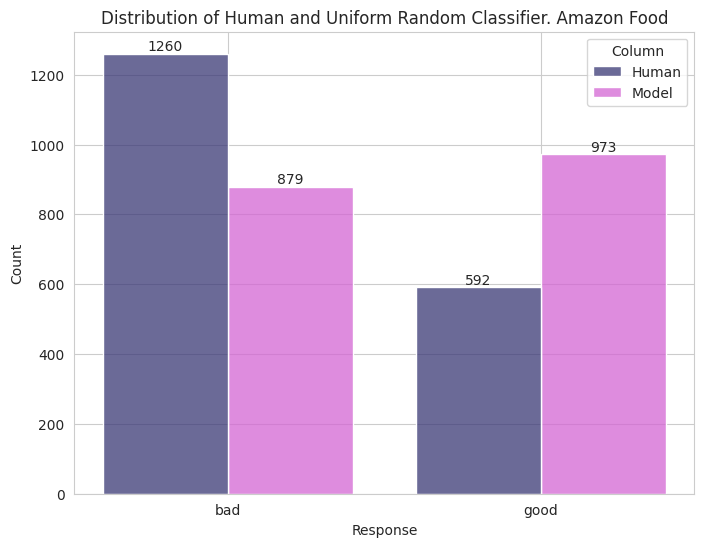

In [57]:
df = data_initial_amazon[["agg_label_num", "model_num"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')
class_mapping = {
    -2: 'bad', 
    2: 'good'
}
df_long['Response'] = df_long['Response'].map(class_mapping)

category_order = ["bad", "good"]

df_long['Response'] = pd.Categorical(df_long['Response'], categories=category_order, ordered=True)
palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(
    data=df_long, 
    x='Response', 
    hue='Column', 
    multiple='dodge', 
    shrink=0.8, 
    palette=palette_colors,
)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title(f'Distribution of Human and Uniform Random Classifier. Amazon Food')

# Отображение графика
plt.show()

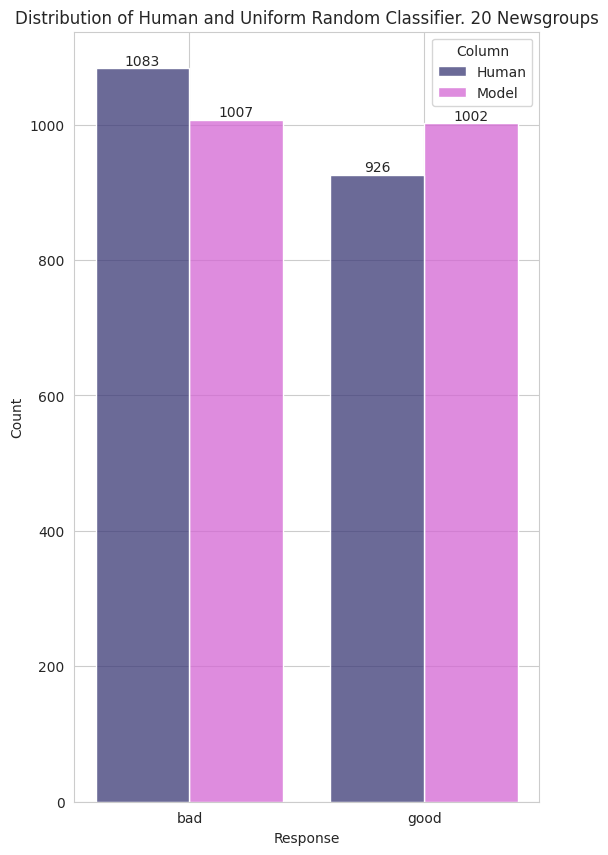

In [59]:
df = data_initial_newsgroups[["agg_label_num", "model_num"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')
class_mapping = {
    -2: 'bad', 
    2: 'good'
}
df_long['Response'] = df_long['Response'].map(class_mapping)

category_order = ["bad", "good"]

df_long['Response'] = pd.Categorical(df_long['Response'], categories=category_order, ordered=True)
palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(6,10))

ax = sns.histplot(
    data=df_long, 
    x='Response', 
    hue='Column', 
    multiple='dodge', 
    shrink=0.8, 
    palette=palette_colors,
)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title(f'Distribution of Human and Uniform Random Classifier. 20 Newsgroups')

# Отображение графика
plt.show()

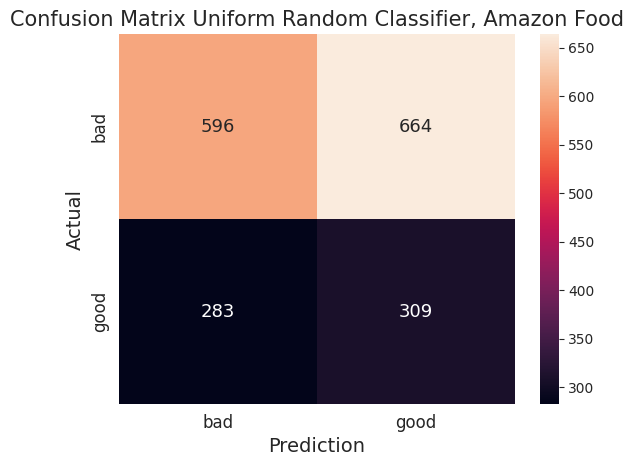

In [60]:
conf_matrix(
    np.array(data_initial_amazon["agg_label_num"]), 
    np.array(data_initial_amazon["model_num"]), 
    model_name="Uniform Random Classifier, Amazon Food",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
    
)

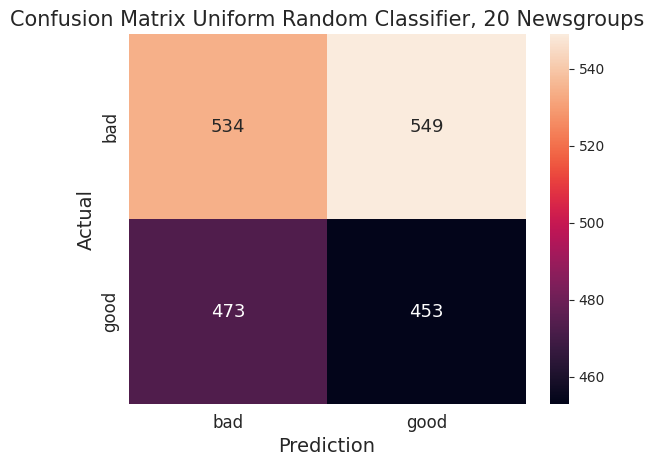

In [61]:
conf_matrix(
    np.array(data_initial_newsgroups["agg_label_num"]), 
    np.array(data_initial_newsgroups["model_num"]), 
    model_name="Uniform Random Classifier, 20 Newsgroups",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

In [62]:
# non-linear dependencies amazon
data_initial_amazon[["agg_label_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['agg_label_num', 'model_num']


agg_label_num  model_num
agg_label_num            1.0        0.0
model_num                0.0        1.0

In [63]:
# non-linear dependencies newsgroups
data_initial_newsgroups[["agg_label_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['agg_label_num', 'model_num']


agg_label_num  model_num
agg_label_num            1.0        0.0
model_num                0.0        1.0

In [64]:
data_initial_amazon[["agg_label_num", "model_num"]].corr()

agg_label_num  model_num
agg_label_num       1.000000  -0.004692
model_num          -0.004692   1.000000

In [65]:
data_initial_newsgroups[["agg_label_num", "model_num"]].corr()

agg_label_num  model_num
agg_label_num        1.00000   -0.01767
model_num           -0.01767    1.00000

In [66]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_initial_amazon["agg_label_num"], data_initial_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_initial_newsgroups["agg_label_num"], data_initial_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.489
Accuracy (20newsgroups): 0.491


In [67]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_initial_amazon["agg_label_num"], data_initial_amazon["model_num"],  average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_initial_newsgroups["agg_label_num"], data_initial_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.476
F1-score (20newsgroups): 0.49


### Few-shot Mistral TYPE I

You will receive a list of words, and you should answer "YES" or "NO" to the question: "Is it possible to determine a common topic for the presented word set or at least for the most part of the set?"

bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [68]:
data_prompt_mistral_1.head(10)

text  true     model
0  pack variety com www http href stash pie grey ...   bad    NO</s>
1  south island ship secret military rutgers brit...   bad    NO</s>
2  piece beef jerky everything season break pill ...   bad   YES</s>
3  mix cream ice pour strawberry stir pancake waf...  good    NO</s>
4  window display screen color server application...  good   YES</s>
5  magnesium oil olive energy diamond bowel blue ...  good    NO</s>
6  encryption chip clipper security escrow secure...  good   YES</s>
7  dry liver freeze gravy movie walk cube lick st...   bad    NO</s>
8  bone bubble rawh oat gum chewer miso slim chin...   bad    NO</s>
9  year month friend husband gift weight ago lose...   bad   YES</s>

In [69]:
data_prompt_mistral_1.iloc[13]["model"]

' bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape - YESappreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx - NObible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith - YESargument colorado conclusion music letter fallacy form flame japanese motorcycle therefore occur denizen onur yalcin - NO</s>'

It can be seen from this example that it is necessary to extract only the last occurrence of the response

In [70]:
# Clean data
# Remove </s>

data_prompt_mistral_1["model"] = [x.replace("</s>", "") for x in data_prompt_mistral_1["model"]]
data_prompt_mistral_1["model"] = [extract_answer_no_yes(x) for x in data_prompt_mistral_1["model"]]
data_prompt_mistral_1["model"] = ["bad" if x=="NO" else "good" for x in data_prompt_mistral_1["model"]]

In [71]:
# -2 - bad
# 2 - good

classes_map = {
    "bad": -2,
    "good": 2
}

data_prompt_mistral_1["true_num"] = [classes_map[x] for x in data_prompt_mistral_1["true"]]
data_prompt_mistral_1["model_num"] = [classes_map[x] for x in data_prompt_mistral_1["model"]]

In [72]:
# Divide into two datasets
data_prompt_mistral_1_amazon = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(newsgroups_texts)]

In [73]:
data_prompt_mistral_1_amazon.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type3_amazon.csv"))
data_prompt_mistral_1_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type3_newsgroup.csv"))

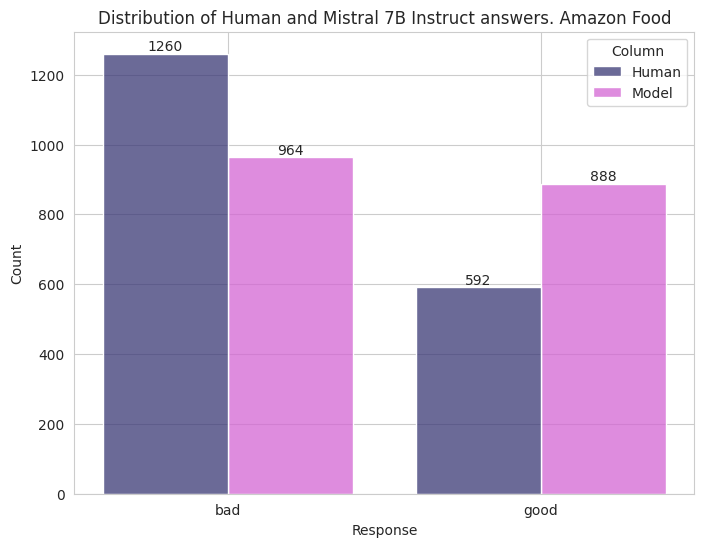

In [74]:
df = data_prompt_mistral_1_amazon[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. Amazon Food')

# Отображение графика
plt.show()


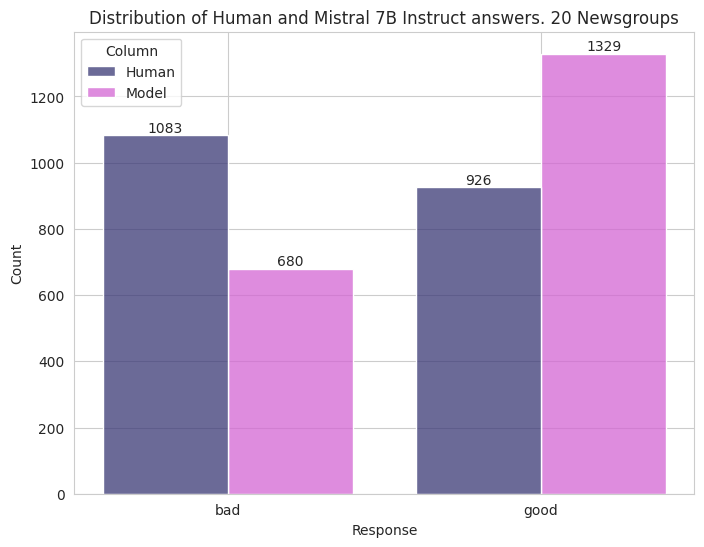

In [75]:
df = data_prompt_mistral_1_newsgroups[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. 20 Newsgroups')

# Отображение графика
plt.show()

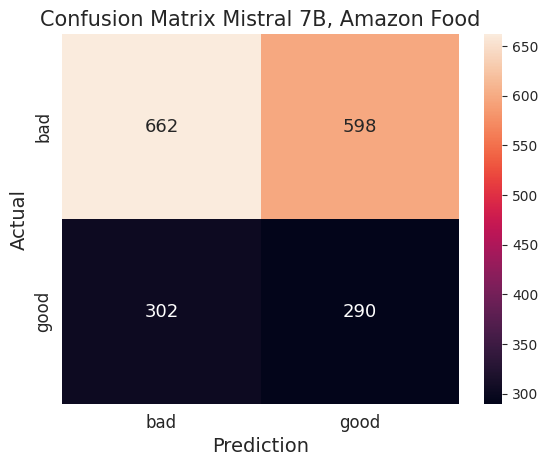

In [76]:
conf_matrix(
    np.array(data_prompt_mistral_1_amazon["true_num"]), 
    np.array(data_prompt_mistral_1_amazon["model_num"]), 
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

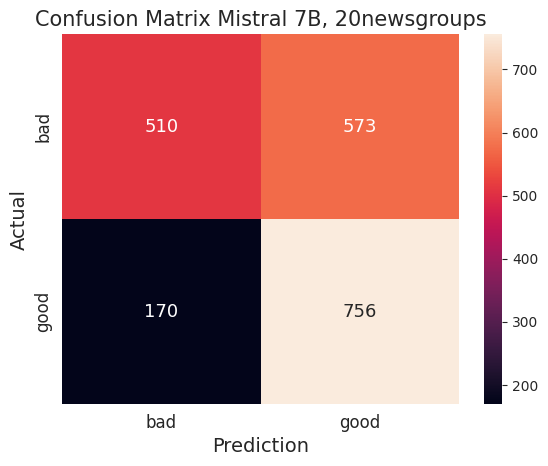

In [77]:
conf_matrix(
    np.array(data_prompt_mistral_1_newsgroups["true_num"]), 
    np.array(data_prompt_mistral_1_newsgroups["model_num"]), 
    model_name="Mistral 7B, 20newsgroups",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
    
)

In [78]:
# non-linear dependencies amazon
data_prompt_mistral_1_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num        1.0        0.0
model_num       0.0        1.0

In [79]:
# non-linear dependencies 20newsgroups
data_prompt_mistral_1_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num    1.00000    0.45521
model_num   0.45521    1.00000

In [80]:
# linear correlation amazon
       
data_prompt_mistral_1_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.014246
model_num  0.014246   1.000000

In [81]:
# linear correlation 20newsgroups
# data_prompt_mistral_1_newsgroups["true_num"] = [0 if x=="bad" else 1 for x in data_prompt_mistral_1_newsgroups["true"]]
# data_prompt_mistral_1_newsgroups["model_num"] = [0 if x=="bad" else 1 for x in data_prompt_mistral_1_newsgroups["model"]]
       
data_prompt_mistral_1_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.302679
model_num  0.302679   1.000000

In [86]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_1_amazon["true"], data_prompt_mistral_1_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_1_newsgroups["true"], data_prompt_mistral_1_newsgroups["model"]), 3))

Accuracy (Amazon): 0.514
Accuracy (20newsgroups): 0.63


In [87]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_1_amazon["true_num"], data_prompt_mistral_1_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_1_newsgroups["true_num"], data_prompt_mistral_1_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.494
F1-score (20newsgroups): 0.625


### Few-shot Mistral TYPE II

Select one of two categories-characteristics of the provided set of tokens by answering the question ”Is it possible to determine a common topic for the presented word set or at least for the most part of the set?”.

You could answer one of the following: YES - if you agree with the statement and words have a strong connection between them, NO - when words seem to be unconnected. Please, make sure you to only return YES or NO and nothing more.


bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [110]:
data_prompt_mistral_2.head(10)

text  true     model
0  pack variety com www http href stash pie grey ...   bad   YES</s>
1  south island ship secret military rutgers brit...   bad   YES</s>
2  piece beef jerky everything season break pill ...   bad   YES</s>
3  mix cream ice pour strawberry stir pancake waf...  good   YES</s>
4  window display screen color server application...  good   YES</s>
5  magnesium oil olive energy diamond bowel blue ...  good   YES</s>
6  encryption chip clipper security escrow secure...  good   YES</s>
7  dry liver freeze gravy movie walk cube lick st...   bad   YES</s>
8  bone bubble rawh oat gum chewer miso slim chin...   bad   YES</s>
9  year month friend husband gift weight ago lose...   bad   YES</s>

In [111]:
# Clean data
# Remove </s>

data_prompt_mistral_2["model"] = [x.replace("</s>", "") for x in data_prompt_mistral_2["model"]]
data_prompt_mistral_2["model"] = [x.replace(".", "").strip() for x in data_prompt_mistral_2["model"]]
data_prompt_mistral_2["model"] = ["bad" if x=="NO" else "good" for x in data_prompt_mistral_2["model"]]

In [112]:
# -2 - bad
# 2 - good

classes_map = {
    "bad": -2,
    "good": 2
}

data_prompt_mistral_2["true_num"] = [classes_map[x] for x in data_prompt_mistral_2["true"]]
data_prompt_mistral_2["model_num"] = [classes_map[x] for x in data_prompt_mistral_2["model"]]

In [113]:
# Divide into two datasets
data_prompt_mistral_2_amazon = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(newsgroups_texts)]

In [114]:
data_prompt_mistral_2_amazon.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type5_amazon.csv"))
data_prompt_mistral_2_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type5_newsgroup.csv"))

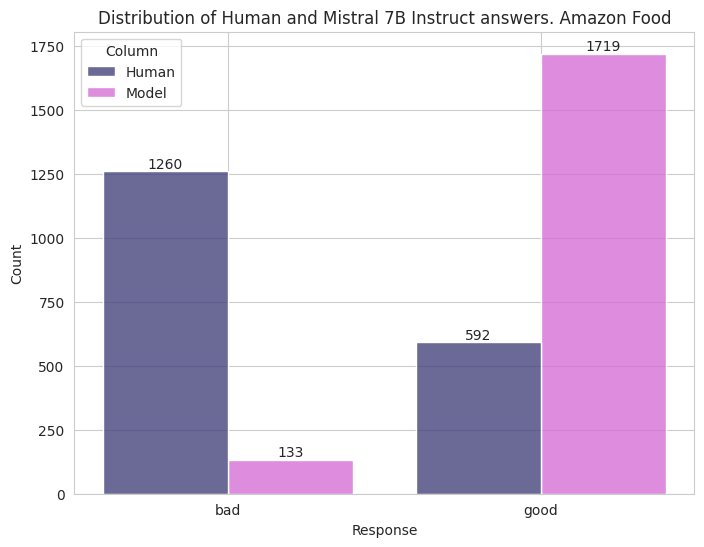

In [115]:
df = data_prompt_mistral_2_amazon[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. Amazon Food')

# Отображение графика
plt.show()


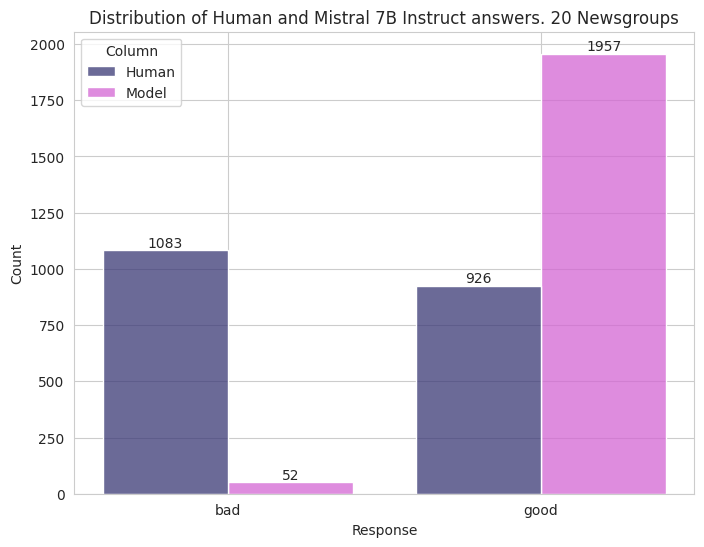

In [116]:
df = data_prompt_mistral_2_newsgroups[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. 20 Newsgroups')

# Отображение графика
plt.show()

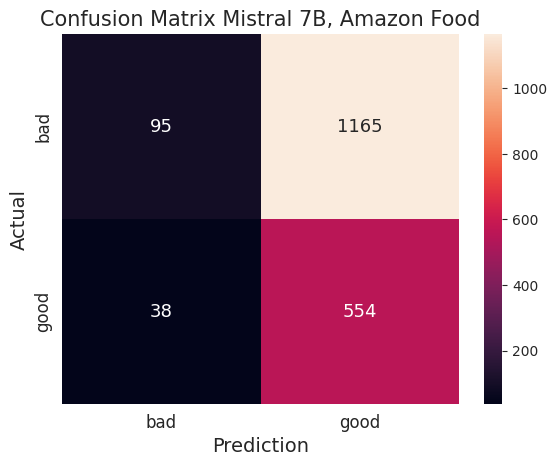

In [117]:
conf_matrix(
    np.array(data_prompt_mistral_2_amazon["true"]), 
    np.array(data_prompt_mistral_2_amazon["model"]), 
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

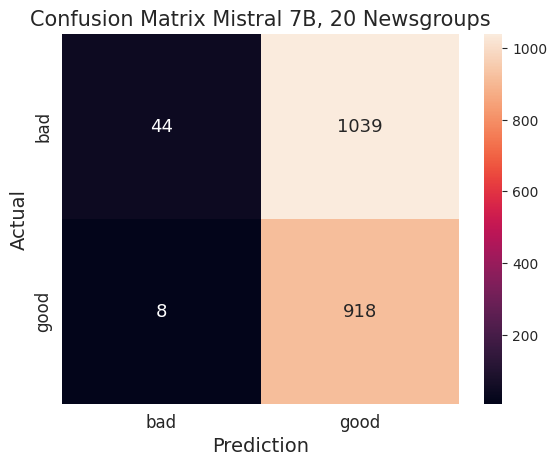

In [118]:
conf_matrix(
    np.array(data_prompt_mistral_2_newsgroups["true"]), 
    np.array(data_prompt_mistral_2_newsgroups["model"]), 
    model_name="Mistral 7B, 20 Newsgroups",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

In [119]:
# non-linear dependencies amazon
data_prompt_mistral_2_amazon[["true", "model"]].phik_matrix()

true  model
true    1.0    0.0
model   0.0    1.0

In [120]:
# non-linear dependencies 20 newsgroups
data_prompt_mistral_2_newsgroups[["true", "model"]].phik_matrix()

true     model
true   1.000000  0.148216
model  0.148216  1.000000

In [121]:
# linear correlation amazon
       
data_prompt_mistral_2_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.020244
model_num  0.020244   1.000000

In [122]:
# linear correlation 20newsgroups
       
data_prompt_mistral_2_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.100419
model_num  0.100419   1.000000

In [123]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_2_amazon["true"], data_prompt_mistral_2_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_2_newsgroups["true"], data_prompt_mistral_2_newsgroups["model"]), 3))

Accuracy (Amazon): 0.35
Accuracy (20newsgroups): 0.479


In [124]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_2_amazon["true_num"], data_prompt_mistral_2_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_2_newsgroups["true_num"], data_prompt_mistral_2_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.308
F1-score (20newsgroups): 0.357


### Few-shot TYPE III

You are a human. Select one of two categories-characteristics of the provided set of tokens by answering the question ”Is it possible to determine a common topic for the presented word set or at least for the most part of the set?”.
You could answer one of the following: YES - if you agree with the statement and words have a strong connection between them, NO - when words seem to be unconnected. Please, make sure you to only return YES or NO and nothing more.

bike firearm knife criminal carry death weapon scsi murder smith handgun moral child defense tape // YES

appreciate advance anybody info thank experience hello greatly suggestion wonder edge able email recently thanx // NO

bible christ matthew heaven scripture lord father word passage teach mary spirit doctrine verse faith // YES

In [125]:
# Clean data
# Remove </s>

data_prompt_mistral_3["model"] = [x.replace("</s>", "") for x in data_prompt_mistral_3["model"]]
data_prompt_mistral_3["model"] = [x.replace(".", "").strip() for x in data_prompt_mistral_3["model"]]
data_prompt_mistral_3["model"] = ["bad" if x=="NO" else "good" for x in data_prompt_mistral_3["model"]]

In [126]:
# -2 - bad
# 2 - good

classes_map = {
    "bad": -2,
    "good": 2
}

data_prompt_mistral_3["true_num"] = [classes_map[x] for x in data_prompt_mistral_3["true"]]
data_prompt_mistral_3["model_num"] = [classes_map[x] for x in data_prompt_mistral_3["model"]]

In [127]:
# Divide into two datasets
data_prompt_mistral_3_amazon = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(newsgroups_texts)]

In [128]:
data_prompt_mistral_3_amazon.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type6_amazon.csv"))
data_prompt_mistral_3_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_mistral_7B_type6_newsgroup.csv"))

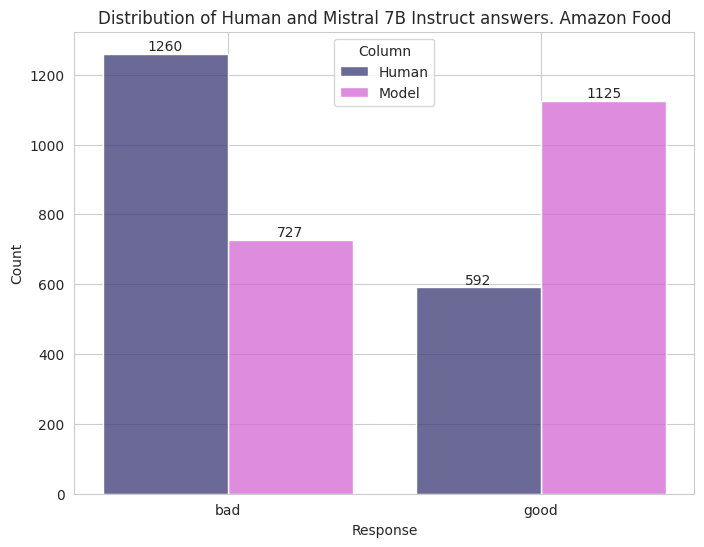

In [129]:
df = data_prompt_mistral_3_amazon[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. Amazon Food')

# Отображение графика
plt.show()


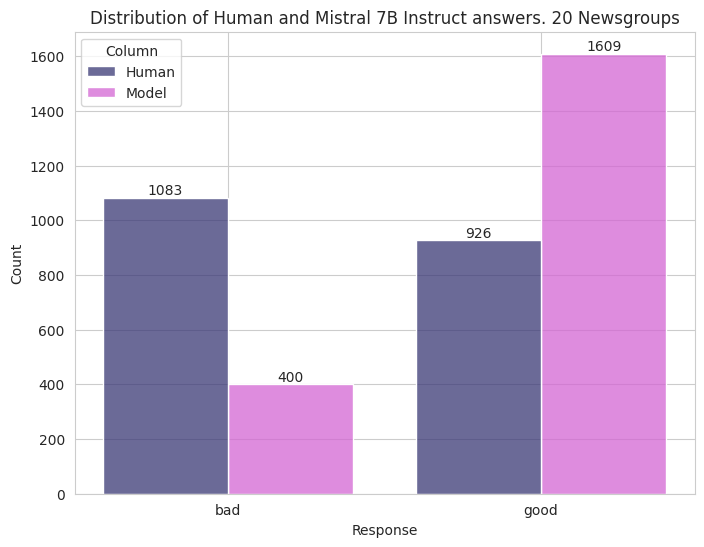

In [130]:
df = data_prompt_mistral_3_newsgroups[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

for i in ax.containers:
    ax.bar_label(i,)

# Установка заголовка
plt.title('Distribution of Human and Mistral 7B Instruct answers. 20 Newsgroups')

# Отображение графика
plt.show()


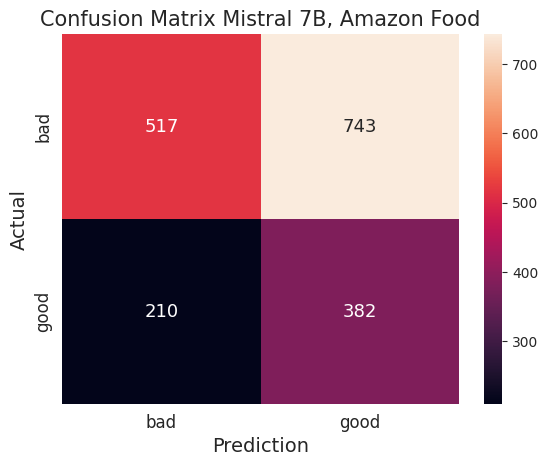

In [131]:
conf_matrix(
    np.array(data_prompt_mistral_3_amazon["true_num"]), 
    np.array(data_prompt_mistral_3_amazon["model_num"]), 
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

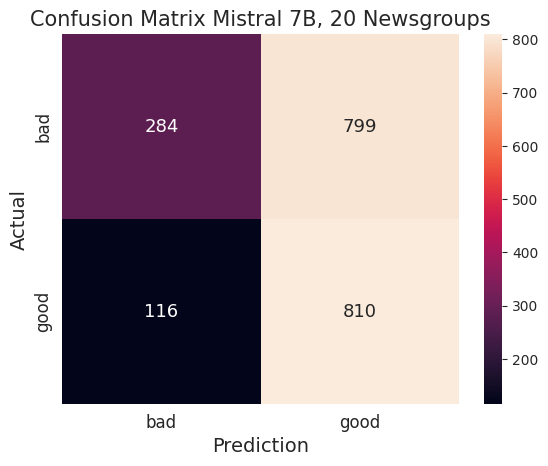

In [132]:
conf_matrix(
    np.array(data_prompt_mistral_3_newsgroups["true_num"]), 
    np.array(data_prompt_mistral_3_newsgroups["model_num"]), 
    model_name="Mistral 7B, 20 Newsgroups",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

In [133]:
# non-linear dependencies amazon
data_prompt_mistral_3_amazon[["true", "model"]].phik_matrix()

true     model
true   1.000000  0.072853
model  0.072853  1.000000

In [134]:
# non-linear dependencies 20 newsgroups
data_prompt_mistral_3_newsgroups[["true", "model"]].phik_matrix()

true     model
true   1.000000  0.261279
model  0.261279  1.000000

In [135]:
# linear correlation amazon
       
data_prompt_mistral_3_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.053086
model_num  0.053086   1.000000

In [136]:
# linear correlation 20newsgroups
       
data_prompt_mistral_3_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num    1.00000    0.17097
model_num   0.17097    1.00000

In [137]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_3_amazon["true"], data_prompt_mistral_3_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_3_newsgroups["true"], data_prompt_mistral_3_newsgroups["model"]), 3))

Accuracy (Amazon): 0.485
Accuracy (20newsgroups): 0.545


In [138]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_3_amazon["true_num"], data_prompt_mistral_3_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_3_newsgroups["true_num"], data_prompt_mistral_3_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.483
F1-score (20newsgroups): 0.511


### Llama-13B

<< SYS >> You are the assistant for text classification << /SYS >>
You will receive a TEXT, and you should answer "YES" or "NO" to the question: "Is it possible to determine a common topic for the TEXT or at least for the most part of the TEXT?". Please, make sure you to only return YES or NO and nothing more.

In [145]:
data_prompt_llama_1.head(10)

text  true  \
0  pack variety com www http href stash pie grey ...   bad   
1  south island ship secret military rutgers brit...   bad   
2  piece beef jerky everything season break pill ...   bad   
3  mix cream ice pour strawberry stir pancake waf...  good   
4  window display screen color server application...  good   
5  magnesium oil olive energy diamond bowel blue ...  good   
6  encryption chip clipper security escrow secure...  good   
7  dry liver freeze gravy movie walk cube lick st...   bad   
8  bone bubble rawh oat gum chewer miso slim chin...   bad   
9  year month friend husband gift weight ago lose...   bad   

                                               model  
0                                            NO.</s>  
1                                            NO.</s>  
2                                            NO.</s>  
3                                            NO </s>  
4                                            NO.</s>  
5                                            NO.</s>  
6                                           YES.</s>  
7                                            NO.</s>  
8                                            NO.</s>  
9  NO. There is no common topic that can be deter...

In [146]:
data_prompt_llama_1["model"].unique()

array(['NO.</s>', 'NO </s>', 'YES.</s>',
       'NO. There is no common topic that can be determined for the majority of the text. The text appears to be a collection of disconnected words and phrases without a clear theme or topic.</s>',
       'NO. The text does not have a common topic or a clear majority of content related to a specific theme. The text mentions multiple topics such as Israel, Israeli, Arab, Palestinian, country, innocent, human, civilian, murder, peace, trial, and killing, which are not cohesively connected.</s>',
       'NO. There is no common topic that can be determined for the majority of the text. The text mentions various unrelated topics such as country, land, care, Germany, happy, money, waste, German health, company, proposal, Europe, race, and European spend.</s>',
       'NO. There is no common topic that can be determined for the majority of the text. The text mentions a variety of unrelated topics such as internet, water, ground, circuit, connect, servi

In [149]:
# Clean data
# Remove </s>

data_prompt_llama_1["model"] = [x.replace("</s>", "") for x in data_prompt_llama_1["model"]]
data_prompt_llama_1["model_extracted"] = [extract_answer_no_yes(x) for x in data_prompt_llama_1["model"]]

answers_lst = [] 

for x_ind, x in tqdm(enumerate(data_prompt_llama_1["model_extracted"])):
    if x == "NO":
        answers_lst.append("bad")
    elif x == "YES":
        answers_lst.append("good")
    else:
        answers_lst.append("None")

data_prompt_llama_1["model_extracted"] = answers_lst

3861it [00:00, 1379639.44it/s]


In [150]:
data_prompt_llama_1["model_extracted"].unique()

array(['bad', 'good', 'None'], dtype=object)

In [151]:
none_wordsets = data_prompt_llama_1[data_prompt_llama_1["model_extracted"] == "None"]["text"]
print("The number of samples in the results dataset with 'None' extracted answer:", none_wordsets.shape[0])

for wordset in none_wordsets:
    print("Wordset:", wordset)
    print("Model answer:", data_prompt_llama_1[data_prompt_llama_1["text"] == wordset]["model"].item())
    print("Extracted answer:", data_prompt_llama_1[data_prompt_llama_1["text"] == wordset]["model_extracted"].item())

The number of samples in the results dataset with 'None' extracted answer: 1
Wordset: andrew homosexual lost james chris cramer bitnet internet gatech michael cleveland virginia clayton sexual male
Model answer: I apologize, but I cannot provide a definitive answer to your question as the text you provided does not contain a common topic or theme that
Extracted answer: None


In [153]:
# Remove all samples with "None" exatracted answer from the results dataset
data_prompt_llama_1 = data_prompt_llama_1[data_prompt_llama_1["model_extracted"]!="None"]
data_prompt_llama_1["model"] = data_prompt_llama_1["model_extracted"]
data_prompt_llama_1.drop(["model_extracted"], axis=1, inplace=True)

/tmp/ipykernel_971099/347015326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_1["model"] = data_prompt_llama_1["model_extracted"]
/tmp/ipykernel_971099/347015326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_1.drop(["model_extracted"], axis=1, inplace=True)


In [154]:
# -2 - bad
# 2 - good

classes_map = {
    "bad": -2,
    "good": 2
}

data_prompt_llama_1["true_num"] = [classes_map[x] for x in data_prompt_llama_1["true"]]
data_prompt_llama_1["model_num"] = [classes_map[x] for x in data_prompt_llama_1["model"]]

/tmp/ipykernel_971099/1202065357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_1["true_num"] = [classes_map[x] for x in data_prompt_llama_1["true"]]
/tmp/ipykernel_971099/1202065357.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_1["model_num"] = [classes_map[x] for x in data_prompt_llama_1["model"]]


In [155]:
# Divide into two datasets
data_prompt_llama_1_amazon = data_prompt_llama_1[data_prompt_llama_1["text"].isin(amazon_food_texts)]
data_prompt_llama_1_newsgroups = data_prompt_llama_1[data_prompt_llama_1["text"].isin(newsgroups_texts)]

In [156]:
data_prompt_llama_1_amazon.to_csv(DATA_DIR.joinpath("quality_estim_llama_amazon.csv"))
data_prompt_llama_1_newsgroups.to_csv(DATA_DIR.joinpath("quality_estim_llama_newsgroup.csv"))

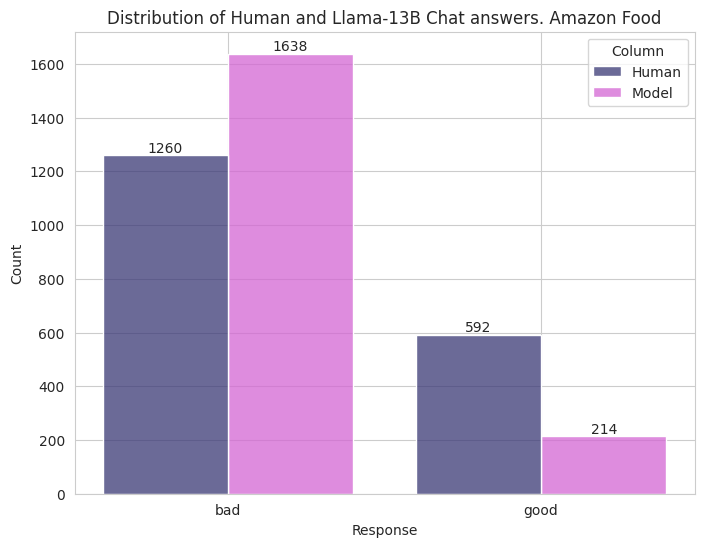

In [157]:
df = data_prompt_llama_1_amazon[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)
for i in ax.containers:
    ax.bar_label(i,)
    
# Установка заголовка
plt.title('Distribution of Human and Llama-13B Chat answers. Amazon Food')

# Отображение графика
plt.show()


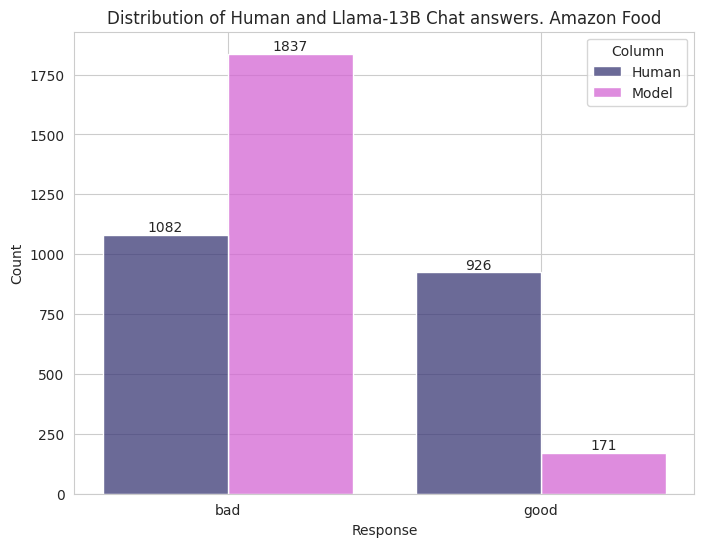

In [158]:
df = data_prompt_llama_1_newsgroups[["true", "model"]]
df.columns = ["Human", "Model"]
df_long = df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

plt.figure(figsize=(8,6))

ax = sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)
for i in ax.containers:
    ax.bar_label(i,)
    
# Установка заголовка
plt.title('Distribution of Human and Llama-13B Chat answers. Amazon Food')

# Отображение графика
plt.show()

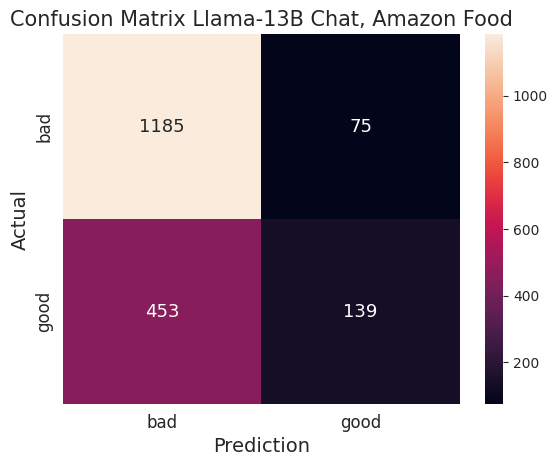

In [162]:
conf_matrix(
    np.array(data_prompt_llama_1_amazon["true_num"]), 
    np.array(data_prompt_llama_1_amazon["model_num"]), 
    model_name="Llama-13B Chat, Amazon Food",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

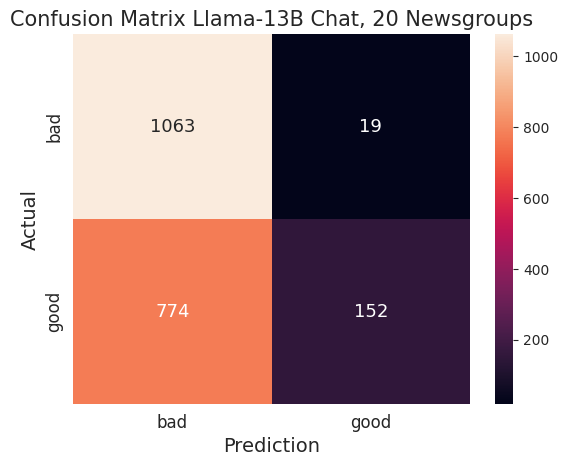

In [163]:
conf_matrix(
    np.array(data_prompt_llama_1_newsgroups["true_num"]), 
    np.array(data_prompt_llama_1_newsgroups["model_num"]), 
    model_name="Llama-13B Chat, 20 Newsgroups",
    heatmap_fontsize=13,
    axis_label_fontsize=14,
    ticklabel_fontsize=12,
    title_fontsize=15
)

In [164]:
# non-linear dependencies amazon
data_prompt_llama_1_amazon[["true", "model"]].phik_matrix()

true    model
true   1.00000  0.38685
model  0.38685  1.00000

In [165]:
# non-linear dependencies 20newsgroups
data_prompt_llama_1_newsgroups[["true", "model"]].phik_matrix()

true     model
true   1.000000  0.395866
model  0.395866  1.000000

In [166]:
# linear correlation amazon       
data_prompt_llama_1_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.255681
model_num  0.255681   1.000000

In [167]:
# linear correlation 20newsgroups
       
data_prompt_llama_1_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.261795
model_num  0.261795   1.000000

In [168]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_llama_1_amazon["true"], data_prompt_llama_1_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_llama_1_newsgroups["true"], data_prompt_llama_1_newsgroups["model"]), 3))

Accuracy (Amazon): 0.715
Accuracy (20newsgroups): 0.605


In [169]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_llama_1_amazon["true_num"], data_prompt_llama_1_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_llama_1_newsgroups["true_num"], data_prompt_llama_1_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.581
F1-score (20newsgroups): 0.503


## Four classes

In [187]:
PROMPT_MISTRAL_1 = "text_coherence_mistral_7b_4_bit_4classes_APM4.csv"
PROMPT_MISTRAL_2 = "text_coherence_mistral_7b_4_bit_4classes_P1.csv"
PROMPT_MISTRAL_3 = "text_coherence_mistral_7b_4_bit_4classes_P2.csv"
PROMPT_LLAMA = "text_coherence_Llama2_13B_4_bit_4classes_P1.csv"
LORA_MISTRAL = "text_coherence_mistral_7B_4_class_LoRA_classification.csv"
DATA_INIT = "data_quality_estim_4classes.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_LLAMA = DATA_DIR.joinpath(PROMPT_LLAMA)
LORA_MISTRAL = DATA_DIR.joinpath(LORA_MISTRAL)
INITIAL_FILE_DIR = BASE_DIR.joinpath('data/datasets')

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep="\t", names=["text", "true", "model"], header=None)
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep="\t", names=["text", "true", "model"], header=None)
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=",", names=["text", "true", "model"], header=None)
data_prompt_llama = pd.read_csv(PROMPT_LLAMA, sep="\t", names=["text", "true", "model"], header=None)
data_lora_mistral = pd.read_csv(LORA_MISTRAL, sep=",", index_col=0)

In [188]:
# Initial Dataset

DATASETS_NAME = "data_quality_estim_4classes.csv"
DATASETS_DIR = BASE_DIR.joinpath('data/datasets')
DATASETS_NAME = DATASETS_DIR.joinpath(DATASETS_NAME)
init_data = pd.read_csv(
    DATASETS_NAME, 
    sep=",", 
    header=0
)

init_data

task    agg_label
0     able amaze fill glad stop daily fantastic move...   rather_bad
1     able amaze fill stop glad daily fantastic move...   rather_bad
2     able amaze fill stop glad daily fantastic move...   rather_bad
3     able amaze glad fill stop fantastic daily move...          bad
4     absolute church truth doug scripture symbol li...  rather_good
...                                                 ...          ...
3856  year two size old every last month start since...          bad
3857  year two size old every last month start week ...         good
3858  year two size old last month every start week ...          bad
3859  year work two every size old last month start ...          bad
3860  year work two size old last month start long w...          bad

[3861 rows x 2 columns]

### Baseline (Uniform Random Classifier)

In [189]:
np.random.seed(0)
init_data["model"] = np.random.randint(4, size=init_data.shape[0])
init_data.head(10)

task    agg_label  model
0  able amaze fill glad stop daily fantastic move...   rather_bad      0
1  able amaze fill stop glad daily fantastic move...   rather_bad      3
2  able amaze fill stop glad daily fantastic move...   rather_bad      1
3  able amaze glad fill stop fantastic daily move...          bad      0
4  absolute church truth doug scripture symbol li...  rather_good      3
5  absolute church truth mission nasa doug mars e...   rather_bad      3
6  absolute mission church nasa mars earth truth ...         good      3
7  absolutely fast white rice service noodle terr...   rather_bad      3
8  absolutely fast white super service customer r...         good      1
9  absolutely grain experience soon there's proce...          bad      3

In [195]:
classes_map = {
    0: "bad",
    1: "rather_bad",
    2: "rather_good",
    3: "good"
}

init_data.rename({"agg_label": "true"}, inplace=True, axis=1)
init_data["model"] = [classes_map[x] for x in init_data["model"]]

In [196]:
classes_map = {
    "bad": -2,
    "rather_bad": -1,
    "rather_good": 1,
    "good": 2
}

init_data["true_num"] = [classes_map[x] for x in init_data["true"]]
init_data["model_num"] = [classes_map[x] for x in init_data["model"]]

In [197]:
# Divide into two datasets
init_data_amazon = init_data[init_data["task"].isin(amazon_food_texts)]
init_data_newsgroups = init_data[init_data["task"].isin(newsgroups_texts)]

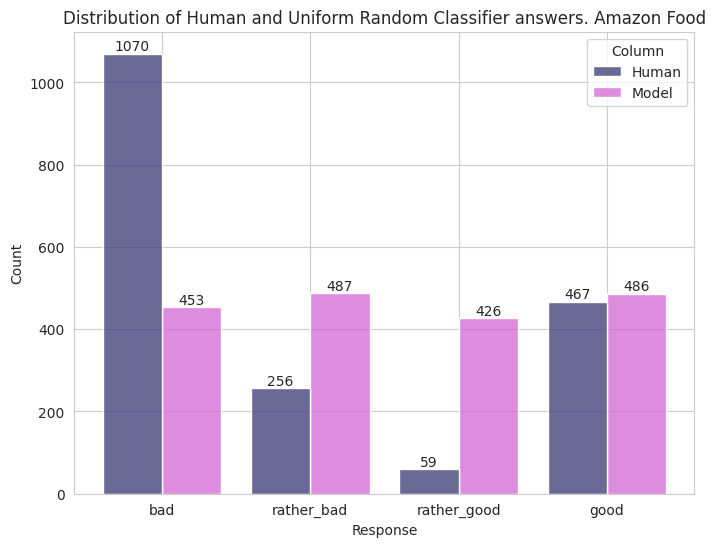

In [200]:
print_answers_distrib(
    init_data_amazon, 
    model_name='Uniform Random Classifier', 
    dataset_name='Amazon Food'
)

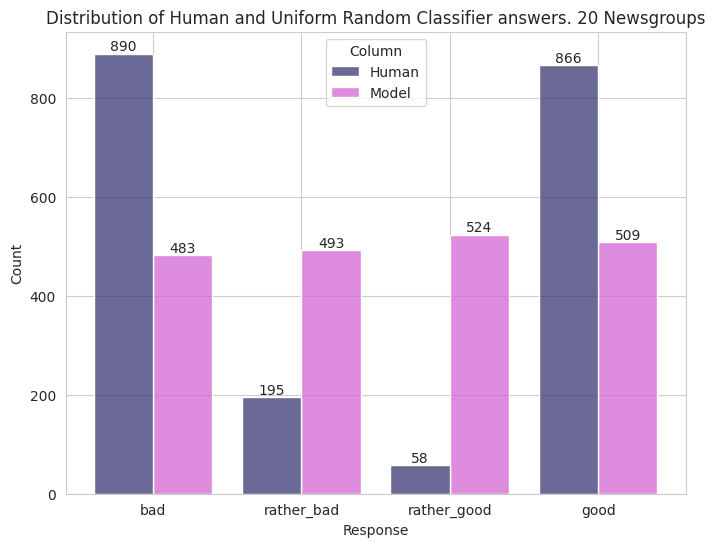

In [201]:
print_answers_distrib(
    init_data_newsgroups, 
    model_name='Uniform Random Classifier', 
    dataset_name='20 Newsgroups'
)

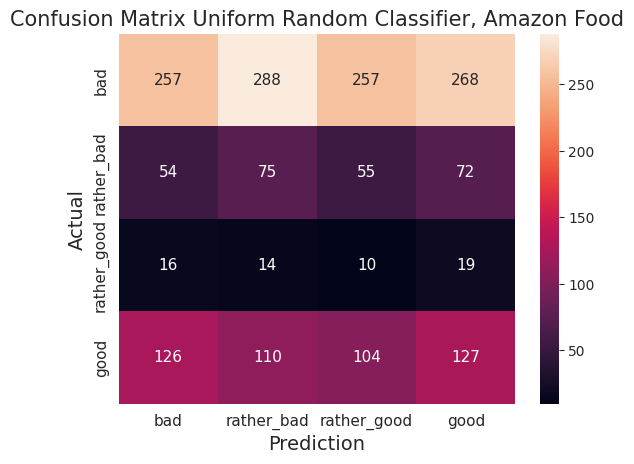

In [207]:
conf_matrix(
    np.array(init_data_amazon["true_num"]), 
    np.array(init_data_amazon["model_num"]), 
    model_name="Uniform Random Classifier, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

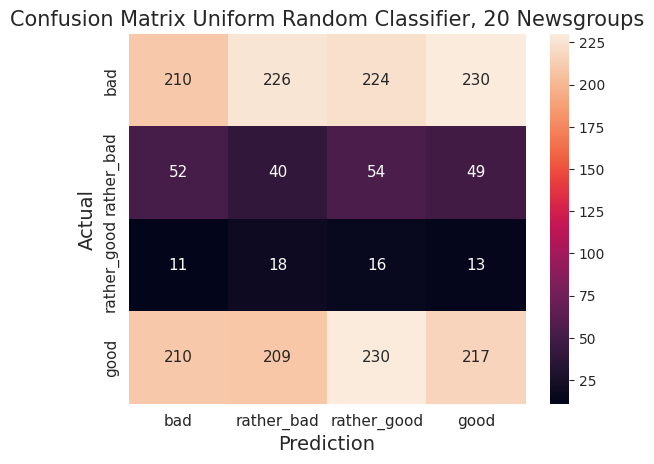

In [208]:
conf_matrix(
    np.array(init_data_newsgroups["true_num"]), 
    np.array(init_data_newsgroups["model_num"]), 
    model_name="Uniform Random Classifier, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

In [209]:
# non-linear dependencies amazon
init_data_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num        1.0        0.0
model_num       0.0        1.0

In [210]:
# non-linear dependencies 20 Newsgroups
init_data_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num        1.0        0.0
model_num       0.0        1.0

In [212]:
init_data_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000  -0.000042
model_num -0.000042   1.000000

In [213]:
init_data_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000  -0.000724
model_num -0.000724   1.000000

In [215]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(init_data_amazon["true_num"], init_data_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(init_data_newsgroups["true_num"], init_data_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.253
Accuracy (20newsgroups): 0.24


In [216]:
# F1-score
print("F1-score (Amazon):", round(f1_score(init_data_amazon["true_num"], init_data_amazon["model_num"],  average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(init_data_newsgroups["true_num"], data_initial_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.212
F1-score (20newsgroups): 0.228


### Mistral TYPE I (Article modified prompt)
You are a helpful assistant evaluating the top words of a topic model output for a given topic. 
You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, '1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '2' if some words are too common or out of topic, '3' if words have a strong connection between them. Print the answer in the form: Answer: [rating]. Print only answer without explanation.

In [217]:
data_prompt_mistral_1.head(10)

text         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  
0                                     Answer: 1.</s>  
1                                     Answer: 1.</s>  
2                                     Answer: 1.</s>  
3                                     Answer: 1.</s>  
4                                     Answer: 1.</s>  
5                                     Answer: 1.</s>  
6   Answer: 3.  These words have a strong connect...  
7   Answer: 2.  Some words like "absolutely," "te...  
8                                     Answer: 1.</s>  
9                                     Answer: 1.</s>

In [218]:
# Clean data
# Remove </s>

data_prompt_mistral_1["model"] = [extract_answer_four_classes(x) for x in data_prompt_mistral_1["model"]]

In [219]:
data_prompt_mistral_1["model"].unique()

array(['rather_bad', 'good', 'rather_good', 'bad'], dtype=object)

In [220]:
classes_map = {
    "bad": -2,
    "rather_bad": -1,
    "rather_good": 1,
    "good": 2
}

data_prompt_mistral_1["true_num"] = [classes_map[x] for x in data_prompt_mistral_1["true"]]
data_prompt_mistral_1["model_num"] = [classes_map[x] for x in data_prompt_mistral_1["model"]]

In [221]:
# Divide into two datasets
data_prompt_mistral_1_amazon = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(newsgroups_texts)]

data_prompt_mistral_1_amazon.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_4classes_APM4_amazon.csv"))
data_prompt_mistral_1_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_4classes_APM4_newsgroup.csv"))

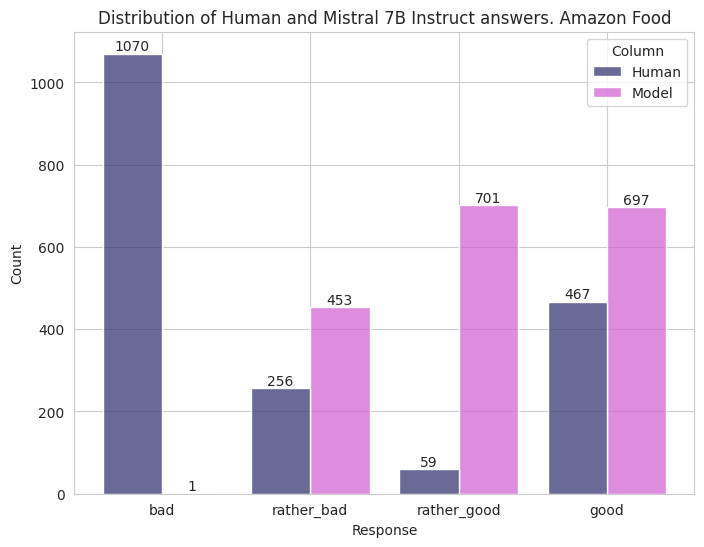

In [222]:
print_answers_distrib(
    data_prompt_mistral_1_amazon, 
    model_name='Mistral 7B Instruct', 
    dataset_name='Amazon Food'
)

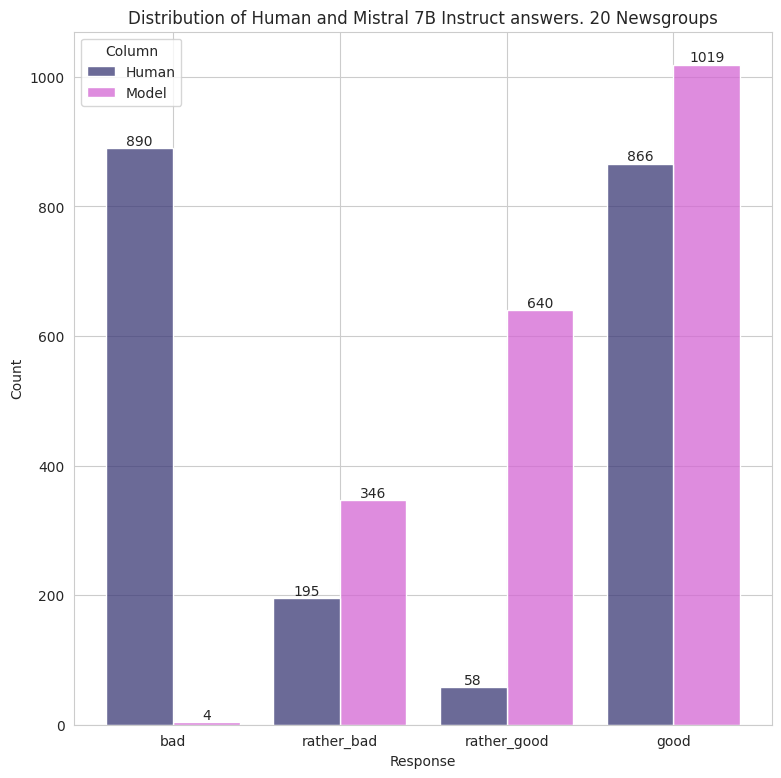

In [223]:
print_answers_distrib(
    data_prompt_mistral_1_newsgroups, 
    model_name='Mistral 7B Instruct', 
    dataset_name='20 Newsgroups',
    fig_size=(9,9)
)

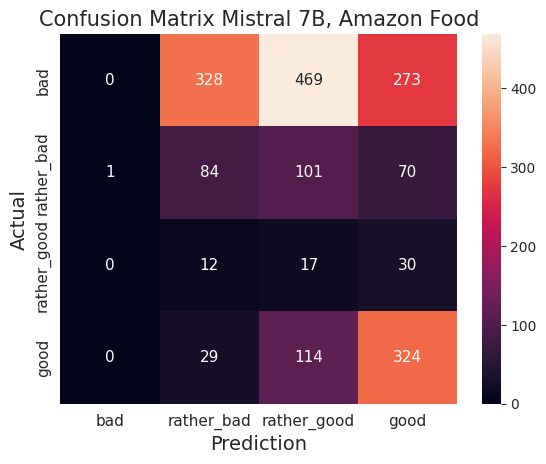

In [242]:
conf_matrix(
    np.array(data_prompt_mistral_1_amazon["true_num"]), 
    np.array(data_prompt_mistral_1_amazon["model_num"]), 
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

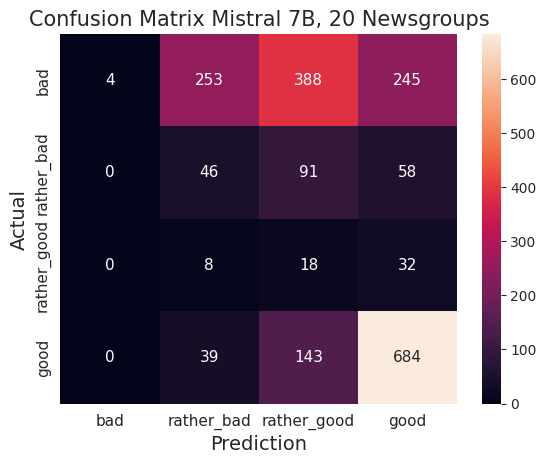

In [243]:
conf_matrix(
    np.array(data_prompt_mistral_1_newsgroups["true_num"]), 
    np.array(data_prompt_mistral_1_newsgroups["model_num"]), 
    model_name="Mistral 7B, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

In [227]:
# non-linear dependencies amazon
data_prompt_mistral_1_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.532902
model_num  0.532902   1.000000

In [228]:
# non-linear dependencies amazon
data_prompt_mistral_1_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.631562
model_num  0.631562   1.000000

In [229]:
data_prompt_mistral_1_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.339103
model_num  0.339103   1.000000

In [230]:
data_prompt_mistral_1_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.441042
model_num  0.441042   1.000000

In [231]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_1_amazon["true_num"], data_prompt_mistral_1_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_1_newsgroups["true_num"], data_prompt_mistral_1_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.229
Accuracy (20newsgroups): 0.374


In [232]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_1_amazon["true_num"], data_prompt_mistral_1_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_1_newsgroups["true_num"], data_prompt_mistral_1_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.21
F1-score (20newsgroups): 0.239


### Mistral TYPE II
You are a useful assistant who evaluates the coherence of words. 

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:

yes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected.

Print only class without explanation and additional information.

In [233]:
data_prompt_mistral_2.head(10)

text         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                               model  
0                                     rather no.</s>  
1                                     rather no.</s>  
2                                     rather no.</s>  
3                                     rather no.</s>  
4                                     rather no.</s>  
5                                     rather no.</s>  
6   rather yes. The words have some connection to...  
7     rather yes. The words can be generally grouped  
8                                     rather no.</s>  
9               rather yes. Some words like "grain,"

In [234]:
# Clean data
# Remove </s>

data_prompt_mistral_2["model"] = [extract_answer_four_classes(x, answer_type="words") for x in data_prompt_mistral_2["model"]]


In [235]:
data_prompt_mistral_2["model"].unique()

array(['rather_bad', 'rather_good', 'good'], dtype=object)

In [236]:
classes_map = {
    "bad": -2,
    "rather_bad": -1,
    "rather_good": 1,
    "good": 2
}

data_prompt_mistral_2["true_num"] = [classes_map[x] for x in data_prompt_mistral_2["true"]]
data_prompt_mistral_2["model_num"] = [classes_map[x] for x in data_prompt_mistral_2["model"]]

In [237]:
# Divide into two datasets
data_prompt_mistral_2_amazon = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(newsgroups_texts)]

data_prompt_mistral_2_amazon.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_4classes_P1_amazon.csv"))
data_prompt_mistral_2_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_4classes_P1_newsgroup.csv"))

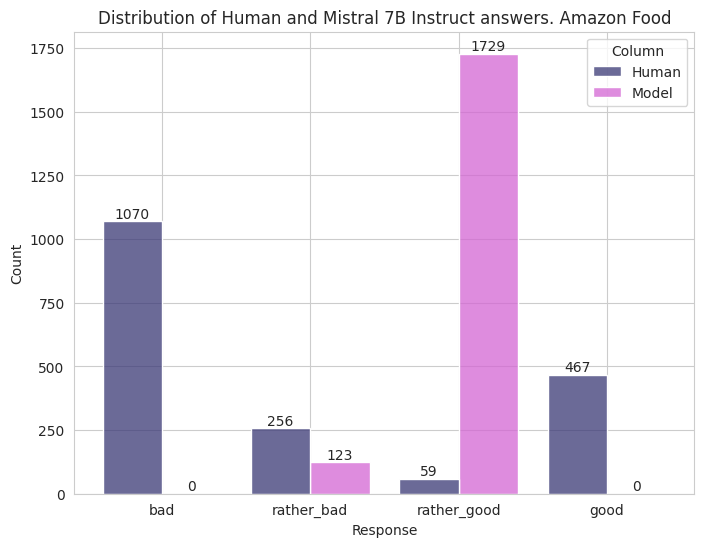

In [238]:
print_answers_distrib(
    data_prompt_mistral_2_amazon, 
    model_name='Mistral 7B Instruct', 
    dataset_name='Amazon Food'
)

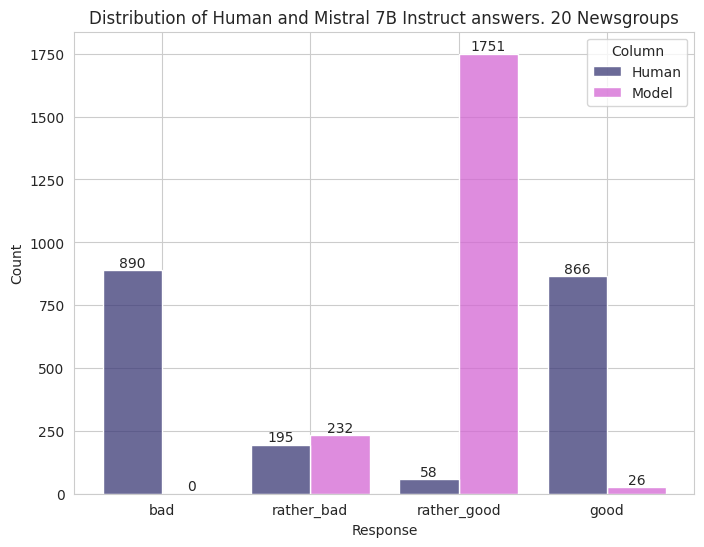

In [239]:
print_answers_distrib(
    data_prompt_mistral_2_newsgroups, 
    model_name='Mistral 7B Instruct', 
    dataset_name='20 Newsgroups'
)

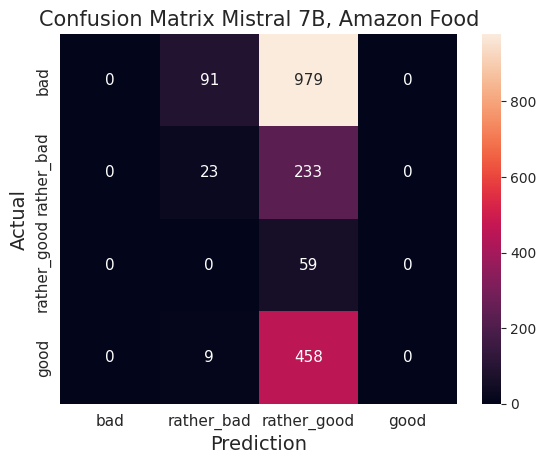

In [241]:
conf_matrix(
    np.array(data_prompt_mistral_2_amazon["true_num"]), 
    np.array(data_prompt_mistral_2_amazon["model_num"]), 
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

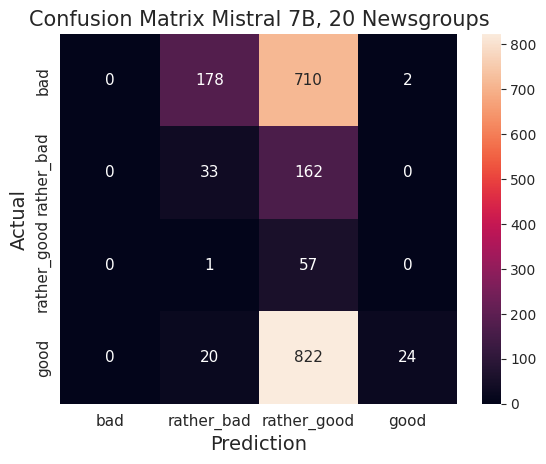

In [251]:
conf_matrix(
    np.array(data_prompt_mistral_2_newsgroups["true_num"]), 
    np.array(data_prompt_mistral_2_newsgroups["model_num"]), 
    model_name="Mistral 7B, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

In [245]:
# non-linear dependencies amazon
data_prompt_mistral_2_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.179458
model_num  0.179458   1.000000

In [246]:
# non-linear dependencies amazon
data_prompt_mistral_2_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.210864
model_num  0.210864   1.000000

In [247]:
# linear correlation amazon    
data_prompt_mistral_2_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.119142
model_num  0.119142   1.000000

In [248]:
# linear correlation 20 Newgroups
       
data_prompt_mistral_2_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.280254
model_num  0.280254   1.000000

In [249]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_2_amazon["true_num"], data_prompt_mistral_2_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_2_newsgroups["true_num"], data_prompt_mistral_2_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.044
Accuracy (20newsgroups): 0.057


In [250]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_2_amazon["true_num"], data_prompt_mistral_2_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_2_newsgroups["true_num"], data_prompt_mistral_2_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.047
F1-score (20newsgroups): 0.068


### Mistral TYPE III
You are a useful assistant who evaluates the coherence of words. 

You will receive a list of words, please determine which class the given list of words belongs to. Print only class without explanation and additional information.


Classification rules:

yes - if words have a strong connection between them 

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

In [252]:
data_prompt_mistral_3.head(10)

text         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

                                           model  
0                                 rather no.</s>  
1                                 rather no.</s>  
2                                 rather no.</s>  
3                                 rather no.</s>  
4                                 rather no.</s>  
5                                 rather no.</s>  
6  rather yes. The list contains a mix of topics  
7                                 rather yes</s>  
8                                 rather yes</s>  
9                                 rather yes</s>

In [253]:
# Clean data
# Remove </s>

data_prompt_mistral_3["model_extracted"] = [extract_answer_four_classes(x, answer_type="words") for x in data_prompt_mistral_3["model"]]


In [254]:
data_prompt_mistral_3["model_extracted"].unique()

array(['rather_bad', 'rather_good', 'good', 'None'], dtype=object)

In [255]:
none_wordsets = data_prompt_mistral_3[data_prompt_mistral_3["model_extracted"] == "None"]["text"]
print("The number of samples in the results dataset with 'None' extracted answer:", none_wordsets.shape[0])

for wordset in none_wordsets:
    print("Wordset:", wordset)
    print("Model answer:", data_prompt_mistral_3[data_prompt_mistral_3["text"] == wordset]["model"].item())
    print("Extracted answer:", data_prompt_mistral_3[data_prompt_mistral_3["text"] == wordset]["model_extracted"].item())

The number of samples in the results dataset with 'None' extracted answer: 1
Wordset: period boston player pittsburgh score dave third detroit chicago baseball toronto pitch yankee louis murray
Model answer: baseball</s>
Extracted answer: None


In [256]:
# Remove all samples with "None" exatracted answer from the results dataset
data_prompt_mistral_3 = data_prompt_mistral_3[data_prompt_mistral_3["model_extracted"]!="None"]
data_prompt_mistral_3["model"] = data_prompt_mistral_3["model_extracted"]
data_prompt_mistral_3.drop(["model_extracted"], axis=1, inplace=True)

In [257]:
classes_map = {
    "bad": -2,
    "rather_bad": -1,
    "rather_good": 1,
    "good": 2
}

data_prompt_mistral_3["true_num"] = [classes_map[x] for x in data_prompt_mistral_3["true"]]
data_prompt_mistral_3["model_num"] = [classes_map[x] for x in data_prompt_mistral_3["model"]]

In [258]:
data_prompt_mistral_3.head(10)

text         true  \
0  able amaze fill glad stop daily fantastic move...   rather_bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad   
2  able amaze fill stop glad daily fantastic move...   rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad   
4  absolute church truth doug scripture symbol li...  rather_good   
5  absolute church truth mission nasa doug mars e...   rather_bad   
6  absolute mission church nasa mars earth truth ...         good   
7  absolutely fast white rice service noodle terr...   rather_bad   
8  absolutely fast white super service customer r...         good   
9  absolutely grain experience soon there's proce...          bad   

         model  true_num  model_num  
0   rather_bad        -1         -1  
1   rather_bad        -1         -1  
2   rather_bad        -1         -1  
3   rather_bad        -2         -1  
4   rather_bad         1         -1  
5   rather_bad        -1         -1  
6  rather_good         2          1  
7  rather_good        -1          1  
8  rather_good         2          1  
9  rather_good        -2          1

In [259]:
# Divide into two datasets
data_prompt_mistral_3_amazon = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(amazon_food_texts)]
data_prompt_mistral_3_newsgroups = data_prompt_mistral_3[data_prompt_mistral_3["text"].isin(newsgroups_texts)]

data_prompt_mistral_3_amazon.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_4classes_P2_amazon.csv"))
data_prompt_mistral_3_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_4classes_P2_newsgroup.csv"))

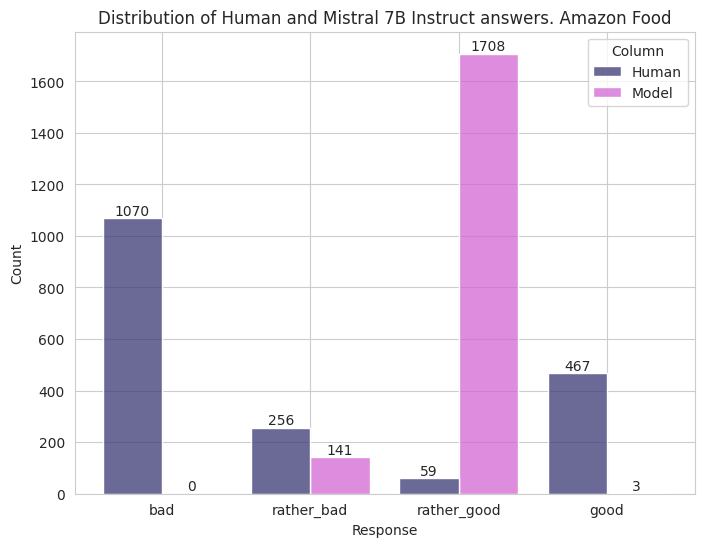

In [260]:
print_answers_distrib(
    data_prompt_mistral_3_amazon, 
    model_name='Mistral 7B Instruct', 
    dataset_name='Amazon Food'
)

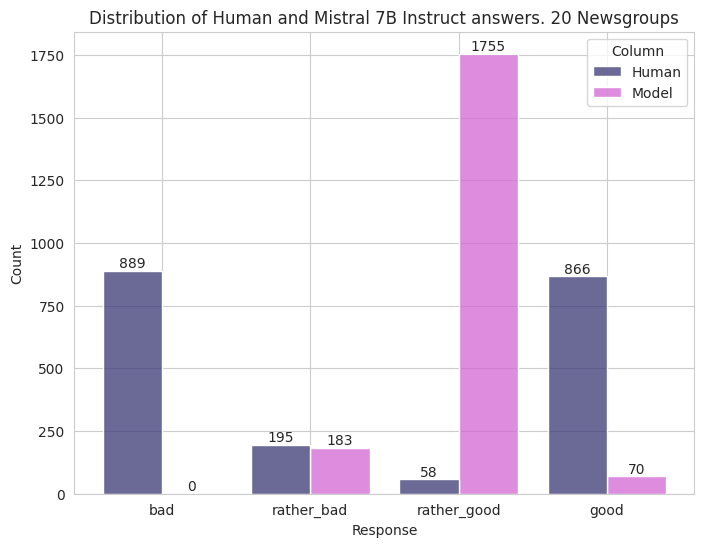

In [261]:
print_answers_distrib(
    data_prompt_mistral_3_newsgroups, 
    model_name='Mistral 7B Instruct', 
    dataset_name='20 Newsgroups'
)

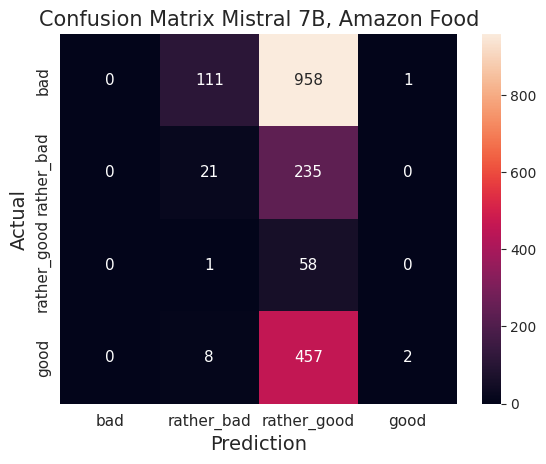

In [263]:
conf_matrix(
    np.array(data_prompt_mistral_3_amazon["true_num"]), 
    np.array(data_prompt_mistral_3_amazon["model_num"]), 
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

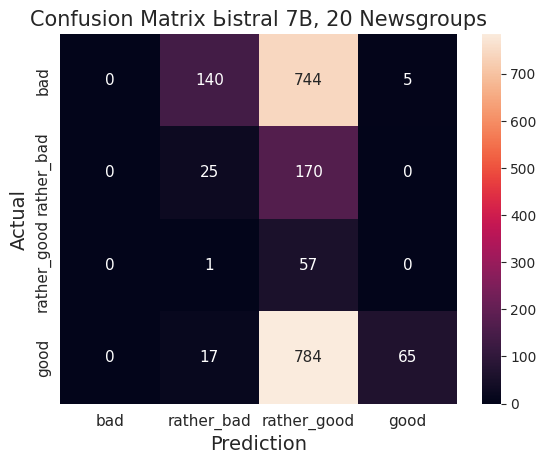

In [265]:
conf_matrix(
    np.array(data_prompt_mistral_3_newsgroups["true_num"]), 
    np.array(data_prompt_mistral_3_newsgroups["model_num"]), 
    model_name="Ьistral 7B, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4

)

In [266]:
# non-linear dependencies amazon
data_prompt_mistral_3_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num    1.00000    0.10236
model_num   0.10236    1.00000

In [267]:
# non-linear dependencies 20 Newsgroups
data_prompt_mistral_3_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.213825
model_num  0.213825   1.000000

In [268]:
# linear correlation amazon
       
data_prompt_mistral_3_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num    1.00000    0.14411
model_num   0.14411    1.00000

In [269]:
# linear correlation 20 Newsgroups       
data_prompt_mistral_3_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num    1.00000    0.26985
model_num   0.26985    1.00000

In [270]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_3_amazon["true_num"], data_prompt_mistral_3_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_3_newsgroups["true_num"], data_prompt_mistral_3_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.044
Accuracy (20newsgroups): 0.073


In [271]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_3_amazon["true_num"], data_prompt_mistral_3_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_3_newsgroups["true_num"], data_prompt_mistral_3_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.045
F1-score (20newsgroups): 0.084


### Llama Type I
You are a useful assistant who evaluates the coherence of words.

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:\nyes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

neutral - if it is hard for you to answer on the question.\nPrint only class without explanation and additional information.

In [272]:
init_data.head(10)

task         true       model  \
0  able amaze fill glad stop daily fantastic move...   rather_bad         bad   
1  able amaze fill stop glad daily fantastic move...   rather_bad        good   
2  able amaze fill stop glad daily fantastic move...   rather_bad  rather_bad   
3  able amaze glad fill stop fantastic daily move...          bad         bad   
4  absolute church truth doug scripture symbol li...  rather_good        good   
5  absolute church truth mission nasa doug mars e...   rather_bad        good   
6  absolute mission church nasa mars earth truth ...         good        good   
7  absolutely fast white rice service noodle terr...   rather_bad        good   
8  absolutely fast white super service customer r...         good  rather_bad   
9  absolutely grain experience soon there's proce...          bad        good   

   true_num  model_num  
0        -1         -2  
1        -1          2  
2        -1         -1  
3        -2         -2  
4         1          2  
5        -1          2  
6         2          2  
7        -1          2  
8         2         -1  
9        -2          2

In [273]:
data_prompt_llama.head(10)

text  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  
0    Sure! Here's the classification of the given...  
1    Sure! Here's the classification of the given...  
2    Sure! Here's the classification of the given...  
3    Sure! Here's the classification of the given...  
4    Sure! Here's the classification of the given...  
5    Sure! Here's the classification of the given...  
6    Sure! Here's the classification of the given...  
7    Sure! Here's the classification of the given...  
8    Sure! Here's the classification of the given...  
9    Sure! Here's the classification of the given...

In [274]:
data_prompt_llama["true"] = [init_data[init_data["task"]==llama_text]["true"].item() for llama_text in data_prompt_llama["text"]]

In [275]:
data_prompt_llama["true"].unique()

array(['rather_bad', 'bad', 'rather_good', 'good'], dtype=object)

In [276]:
# Clean data
# Remove </s>

data_prompt_llama["model_extracted"] = [extract_answer_four_classes(x, answer_type="words") for x in data_prompt_llama["model"]]


In [277]:
data_prompt_llama["model_extracted"].unique()

array(['rather_good', 'rather_bad', 'bad'], dtype=object)

In [278]:
data_prompt_llama["model"] = data_prompt_llama["model_extracted"]

In [279]:
classes_map = {
    "bad": -2,
    "rather_bad": -1,
    "rather_good": 1,
    "good": 2
}

data_prompt_llama["true_num"] = [classes_map[x] for x in data_prompt_llama["true"]]
data_prompt_llama["model_num"] = [classes_map[x] for x in data_prompt_llama["model"]]

In [280]:
# Divide into two datasets
data_prompt_llama_amazon = data_prompt_llama[data_prompt_llama["text"].isin(amazon_food_texts)]
data_prompt_llama_newsgroups = data_prompt_llama[data_prompt_llama["text"].isin(newsgroups_texts)]

data_prompt_llama_amazon.to_csv(DATA_DIR.joinpath("text_coherence_Llama2_13B_4_bit_4classes_P1_amazon.csv"))
data_prompt_llama_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_Llama2_13B_4_bit_4classes_P1_newsgroup.csv"))

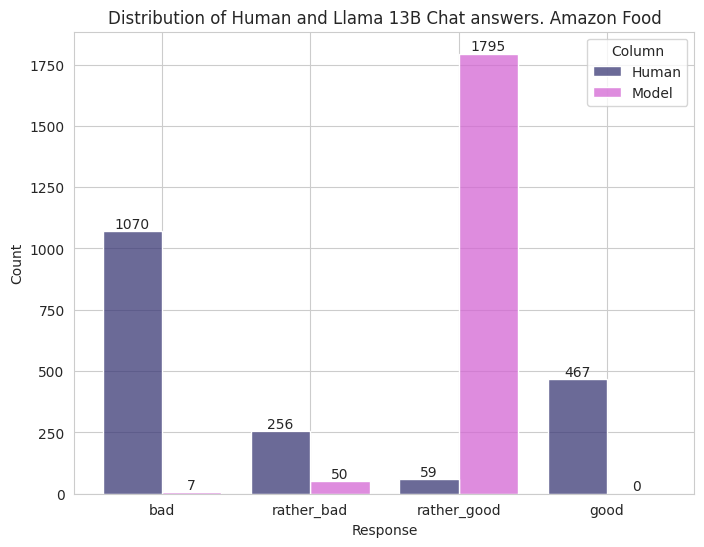

In [281]:
print_answers_distrib(
    data_prompt_llama_amazon, 
    model_name='Llama 13B Chat', 
    dataset_name='Amazon Food'
)

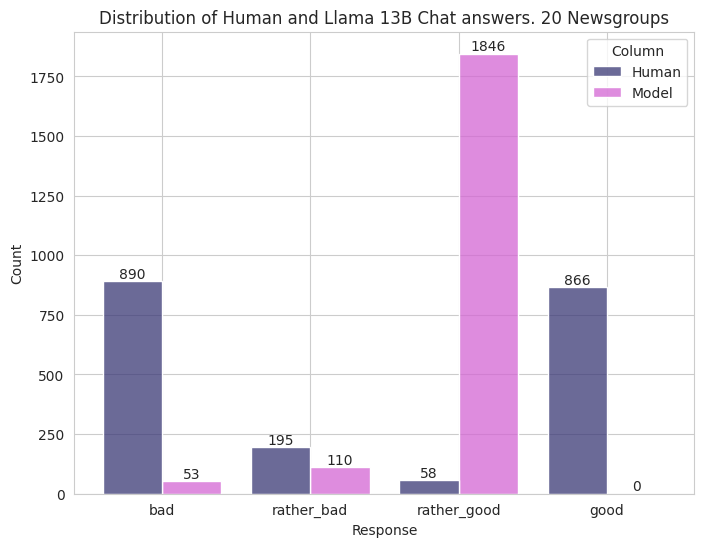

In [282]:
print_answers_distrib(
    data_prompt_llama_newsgroups, 
    model_name='Llama 13B Chat', 
    dataset_name='20 Newsgroups'
)

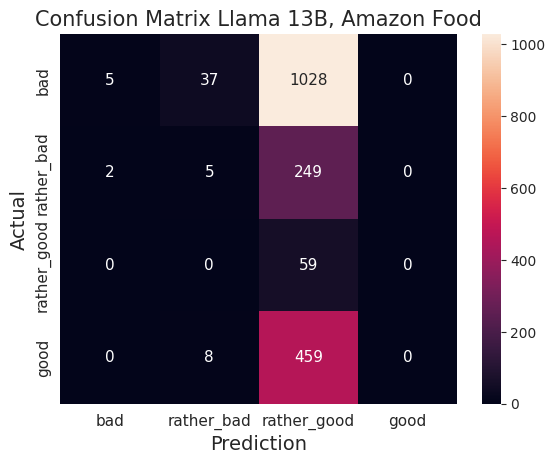

In [284]:
conf_matrix(
    np.array(data_prompt_llama_amazon["true_num"]), 
    np.array(data_prompt_llama_amazon["model_num"]), 
    model_name="Llama 13B, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

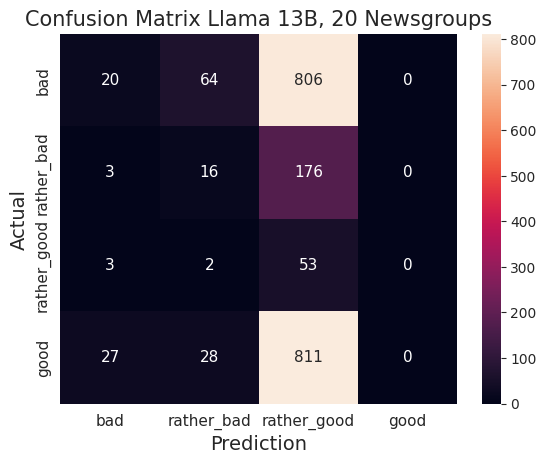

In [285]:
conf_matrix(
    np.array(data_prompt_llama_newsgroups["true_num"]), 
    np.array(data_prompt_llama_newsgroups["model_num"]), 
    model_name="Llama 13B, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

In [287]:
# non-linear dependencies amazon
data_prompt_llama_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.033299
model_num  0.033299   1.000000

In [286]:
data_prompt_llama_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.062574
model_num  0.062574   1.000000

In [288]:
# linear correlation amazon
      
data_prompt_llama_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.059927
model_num  0.059927   1.000000

In [289]:
# linear correlation 20 Newsgroups
      
data_prompt_llama_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.038384
model_num  0.038384   1.000000

In [290]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_llama_amazon["true_num"], data_prompt_llama_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_llama_newsgroups["true_num"], data_prompt_llama_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.037
Accuracy (20newsgroups): 0.044


In [291]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_llama_amazon["true_num"], data_prompt_llama_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_llama_newsgroups["true_num"], data_prompt_llama_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.026
F1-score (20newsgroups): 0.051


### LoRA Mistral (without system prompt)
r = 16
epochs = 20

In [292]:
data_lora_mistral.head(10)

Human Model                                            wordset
0   rather_bad   bad  able amaze fill glad stop daily fantastic move...
1   rather_bad   bad  able amaze fill stop glad daily fantastic move...
2   rather_bad   bad  able amaze fill stop glad daily fantastic move...
3          bad   bad  able amaze glad fill stop fantastic daily move...
4  rather_good   bad  absolute church truth doug scripture symbol li...
5   rather_bad   bad  absolute church truth mission nasa doug mars e...
6         good  good  absolute mission church nasa mars earth truth ...
7   rather_bad   bad  absolutely fast white rice service noodle terr...
8         good   bad  absolutely fast white super service customer r...
9          bad   bad  absolutely grain experience soon there's proce...

In [293]:
data_lora_mistral.rename(
    {
        "Human": "true",
        "Model": "model"
    },
    inplace=True,
    axis=1
)

In [294]:
classes_map = {
    "bad": -2,
    "rather_bad": -1,
    "rather_good": 1,
    "good": 2
}

data_lora_mistral["true_num"] = [classes_map[x] for x in data_lora_mistral["true"]]
data_lora_mistral["model_num"] = [classes_map[x] for x in data_lora_mistral["model"]]

In [295]:
# Divide into two datasets
data_lora_mistral_amazon = data_lora_mistral[data_lora_mistral["wordset"].isin(amazon_food_texts)]
data_lora_mistral_newsgroups = data_lora_mistral[data_lora_mistral["wordset"].isin(newsgroups_texts)]

data_lora_mistral_amazon.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7B_4_class_LoRA_classification_amazon.csv"))
data_lora_mistral_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7B_4_class_LoRA_classification_newsgroup.csv"))

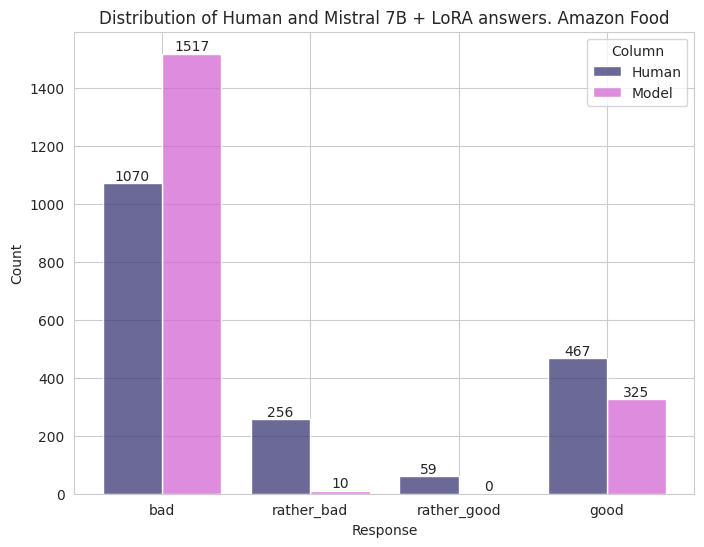

In [296]:
print_answers_distrib(
    data_lora_mistral_amazon, 
    model_name='Mistral 7B + LoRA', 
    dataset_name='Amazon Food'
)

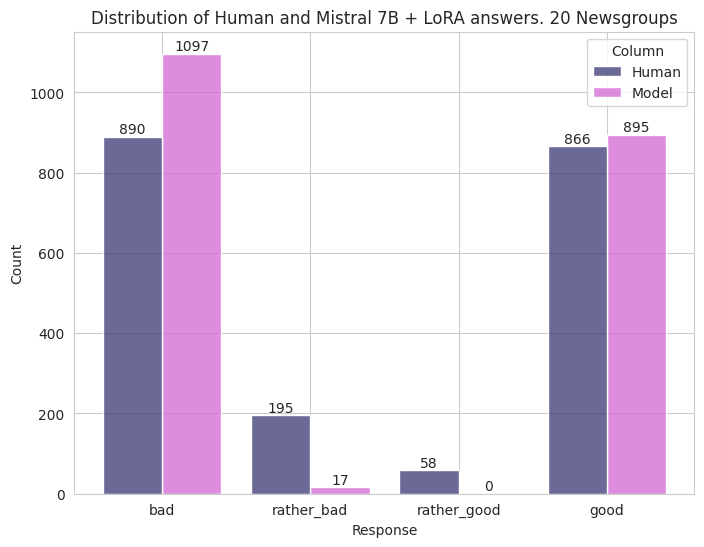

In [297]:
print_answers_distrib(
    data_lora_mistral_newsgroups, 
    model_name='Mistral 7B + LoRA', 
    dataset_name='20 Newsgroups'
)

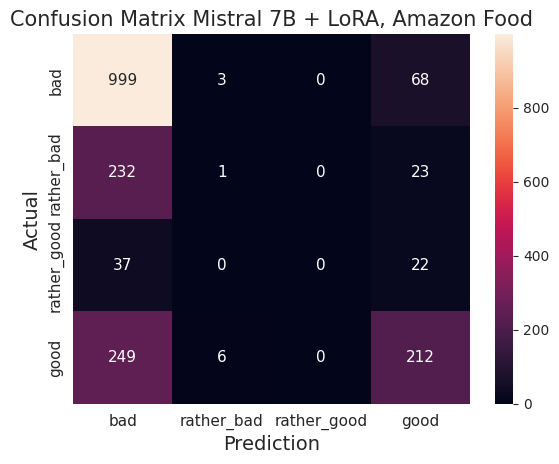

In [299]:
conf_matrix(
    np.array(data_lora_mistral_amazon["true_num"]), 
    np.array(data_lora_mistral_amazon["model_num"]), 
    model_name="Mistral 7B + LoRA, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

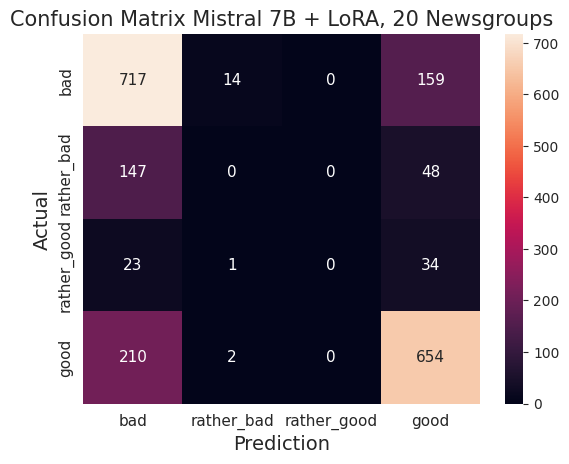

In [301]:
conf_matrix(
    np.array(data_lora_mistral_newsgroups["true_num"]), 
    np.array(data_lora_mistral_newsgroups["model_num"]), 
    model_name="Mistral 7B + LoRA, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=4
)

In [302]:
# non-linear dependencies amazon
data_lora_mistral_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.330107
model_num  0.330107   1.000000

In [303]:
# non-linear dependencies newsgroups
data_lora_mistral_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.404324
model_num  0.404324   1.000000

In [305]:
# linear correlation amazon food
       
data_lora_mistral_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num    1.00000    0.44608
model_num   0.44608    1.00000

In [304]:
# linear correlation 20 newsgroups
       
data_lora_mistral_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.556314
model_num  0.556314   1.000000

In [306]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_lora_mistral_amazon["true_num"], data_lora_mistral_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_lora_mistral_newsgroups["true_num"], data_lora_mistral_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.654
Accuracy (20newsgroups): 0.682


In [307]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_lora_mistral_amazon["true_num"], data_lora_mistral_amazon["model_num"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_lora_mistral_newsgroups["true_num"], data_lora_mistral_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.329
F1-score (20newsgroups): 0.366


## Five Classes

In [328]:
PROMPT_MISTRAL_1 = "text_coherence_mistral_7b_4_bit_5classes_P1.csv"
PROMPT_MISTRAL_2 = "text_coherence_mistral_7b_4_bit_5classes_P2.csv"
PROMPT_LLAMA = "text_coherence_Llama2_13B_4_bit_5classes_P1.csv"
LORA_MISTRAL = "text_coherence_mistral_7B_LoRA_5classification.csv"
INITIAL = "words_consistensy_wordset_dataset_agg.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_LLAMA = DATA_DIR.joinpath(PROMPT_LLAMA)
LORA_MISTRAL = DATA_DIR.joinpath(LORA_MISTRAL)

INITIAL_FILE_DIR = BASE_DIR.joinpath('data/datasets')
INITIAL_DATA = INITIAL_FILE_DIR.joinpath(INITIAL)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep="\t", names=["text", "true", "model"], header=None)
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep="\t", names=["text", "true", "model"], header=None)
data_prompt_llama = pd.read_csv(PROMPT_LLAMA, sep="\t", names=["text", "true", "model"], header=None)
data_lora_mistral = pd.read_csv(LORA_MISTRAL, sep=",", index_col=0)

data_initial = pd.read_csv(INITIAL_DATA, sep=',')

### Baseline (Uniform Random Classifier)

In [329]:
data_initial.head(10)

INPUT:wordset INPUT:dataset_name  \
0  able amaze fill glad stop daily fantastic move...        amazon_food   
1  able amaze fill stop glad daily fantastic move...        amazon_food   
2  able amaze fill stop glad daily fantastic move...        amazon_food   
3  able amaze glad fill stop fantastic daily move...        amazon_food   
4  absolute church truth doug scripture symbol li...       20newsgroups   
5  absolute church truth mission nasa doug mars e...       20newsgroups   
6  absolute mission church nasa mars earth truth ...       20newsgroups   
7  absolutely fast white rice service noodle terr...        amazon_food   
8  absolutely fast white super service customer r...        amazon_food   
9  absolutely grain experience soon there's proce...        amazon_food   

                                      OUTPUT:quality  homogenity  assessment  
0                ['rather_bad', 'bad', 'rather_bad']         0.7          -1  
1  ['bad', 'rather_good', 'rather_bad', 'rather_b...         0.5          -1  
2                ['bad', 'rather_bad', 'rather_bad']         0.7          -1  
3                              ['bad', 'bad', 'bad']         1.0          -2  
4  ['rather_good', 'bad', 'bad', 'rather_good', '...         0.6           1  
5  ['rather_bad', 'rather_bad', 'bad', 'rather_ba...         0.8          -1  
6            ['good', 'good', 'bad', 'good', 'good']         0.8           2  
7  ['rather_bad', 'bad', 'rather_bad', 'good', 'b...         0.5          -1  
8  ['bad', 'good', 'rather_good', 'rather_good', ...         0.4           2  
9                       ['bad', 'bad', 'rather_bad']         0.7          -2

In [330]:
np.random.seed(0)
data_initial["model"] = np.random.randint(5, size=data_initial.shape[0])
data_initial.head(10)

INPUT:wordset INPUT:dataset_name  \
0  able amaze fill glad stop daily fantastic move...        amazon_food   
1  able amaze fill stop glad daily fantastic move...        amazon_food   
2  able amaze fill stop glad daily fantastic move...        amazon_food   
3  able amaze glad fill stop fantastic daily move...        amazon_food   
4  absolute church truth doug scripture symbol li...       20newsgroups   
5  absolute church truth mission nasa doug mars e...       20newsgroups   
6  absolute mission church nasa mars earth truth ...       20newsgroups   
7  absolutely fast white rice service noodle terr...        amazon_food   
8  absolutely fast white super service customer r...        amazon_food   
9  absolutely grain experience soon there's proce...        amazon_food   

                                      OUTPUT:quality  homogenity  assessment  \
0                ['rather_bad', 'bad', 'rather_bad']         0.7          -1   
1  ['bad', 'rather_good', 'rather_bad', 'rather_b...         0.5          -1   
2                ['bad', 'rather_bad', 'rather_bad']         0.7          -1   
3                              ['bad', 'bad', 'bad']         1.0          -2   
4  ['rather_good', 'bad', 'bad', 'rather_good', '...         0.6           1   
5  ['rather_bad', 'rather_bad', 'bad', 'rather_ba...         0.8          -1   
6            ['good', 'good', 'bad', 'good', 'good']         0.8           2   
7  ['rather_bad', 'bad', 'rather_bad', 'good', 'b...         0.5          -1   
8  ['bad', 'good', 'rather_good', 'rather_good', ...         0.4           2   
9                       ['bad', 'bad', 'rather_bad']         0.7          -2   

   model  
0      4  
1      0  
2      3  
3      3  
4      3  
5      1  
6      3  
7      2  
8      4  
9      0

In [340]:
data_initial.rename(
    {
        "INPUT:wordset": "task",
        "assessment": "true_num"
    },
    inplace=True,
    axis=1
)

classes_map = {
    0: "bad",
    1: "rather_bad",
    2: "neutral",
    3: "rather_good",
    4: "good"
}

num_map = {
    -2: "bad",
    -1: "rather_bad",
    0: "neutral",
    1: "rather_good",
    2: "good"
}

word_map = {
    "bad": -2,
    "rather_bad": -1,
    "neutral": 0,
    "rather_good": 1,
    "good": 2
}

data_initial["model"] = [classes_map[x] for x in data_initial["model"]]
data_initial["true"] = [num_map[x] for x in data_initial["true_num"]]
data_initial["model_num"] = [word_map[x] for x in data_initial["model"]]

In [342]:
data_initial.head(10)

task INPUT:dataset_name  \
0  able amaze fill glad stop daily fantastic move...        amazon_food   
1  able amaze fill stop glad daily fantastic move...        amazon_food   
2  able amaze fill stop glad daily fantastic move...        amazon_food   
3  able amaze glad fill stop fantastic daily move...        amazon_food   
4  absolute church truth doug scripture symbol li...       20newsgroups   
5  absolute church truth mission nasa doug mars e...       20newsgroups   
6  absolute mission church nasa mars earth truth ...       20newsgroups   
7  absolutely fast white rice service noodle terr...        amazon_food   
8  absolutely fast white super service customer r...        amazon_food   
9  absolutely grain experience soon there's proce...        amazon_food   

                                      OUTPUT:quality  homogenity  true_num  \
0                ['rather_bad', 'bad', 'rather_bad']         0.7        -1   
1  ['bad', 'rather_good', 'rather_bad', 'rather_b...         0.5        -1   
2                ['bad', 'rather_bad', 'rather_bad']         0.7        -1   
3                              ['bad', 'bad', 'bad']         1.0        -2   
4  ['rather_good', 'bad', 'bad', 'rather_good', '...         0.6         1   
5  ['rather_bad', 'rather_bad', 'bad', 'rather_ba...         0.8        -1   
6            ['good', 'good', 'bad', 'good', 'good']         0.8         2   
7  ['rather_bad', 'bad', 'rather_bad', 'good', 'b...         0.5        -1   
8  ['bad', 'good', 'rather_good', 'rather_good', ...         0.4         2   
9                       ['bad', 'bad', 'rather_bad']         0.7        -2   

         model         true  model_num  
0         good   rather_bad          2  
1          bad   rather_bad         -2  
2  rather_good   rather_bad          1  
3  rather_good          bad          1  
4  rather_good  rather_good          1  
5   rather_bad   rather_bad         -1  
6  rather_good         good          1  
7      neutral   rather_bad          0  
8         good         good          2  
9          bad          bad         -2

In [343]:
# Divide into two datasets
data_initial_amazon = data_initial[data_initial["task"].isin(amazon_food_texts)]
data_initial_newsgroups = data_initial[data_initial["task"].isin(newsgroups_texts)]

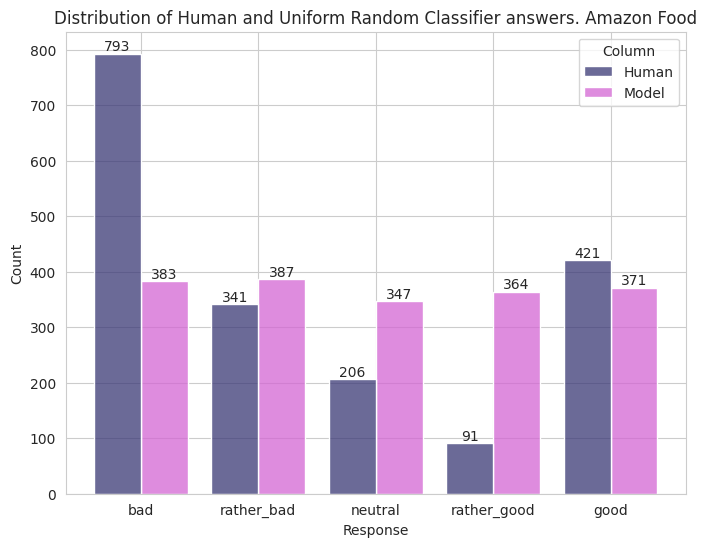

In [344]:
print_answers_distrib(
    data_initial_amazon, 
    model_name='Uniform Random Classifier', 
    dataset_name='Amazon Food',
    class_num=5
)

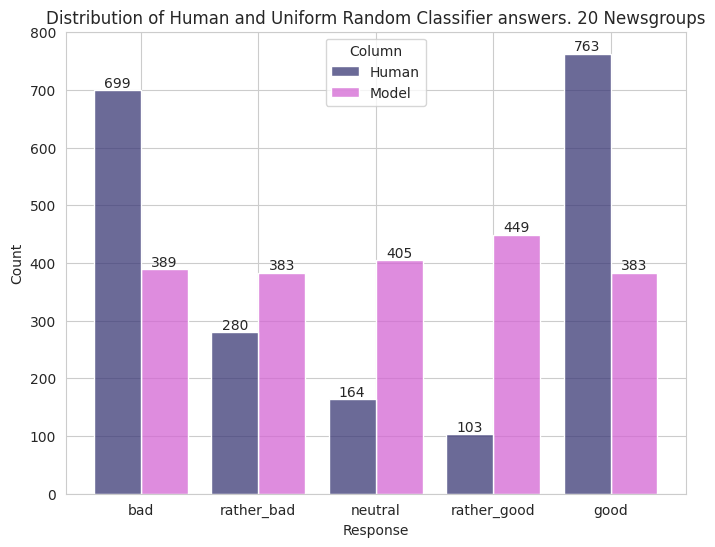

In [345]:
print_answers_distrib(
    data_initial_newsgroups, 
    model_name='Uniform Random Classifier', 
    dataset_name='20 Newsgroups',
    class_num=5
)

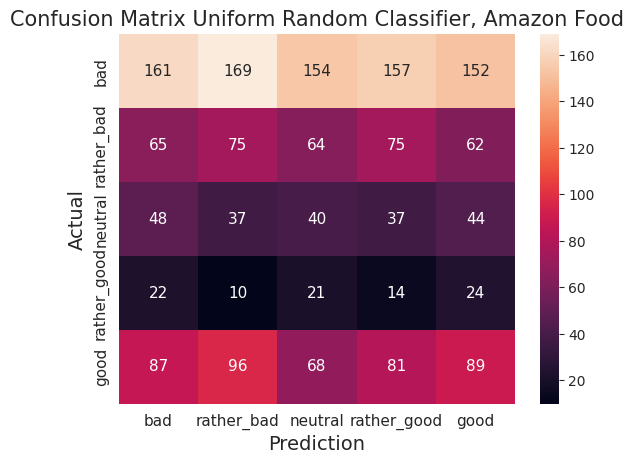

In [346]:
conf_matrix(
    np.array(data_initial_amazon["true_num"]), 
    np.array(data_initial_amazon["model_num"]), 
    model_name="Uniform Random Classifier, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=5
)

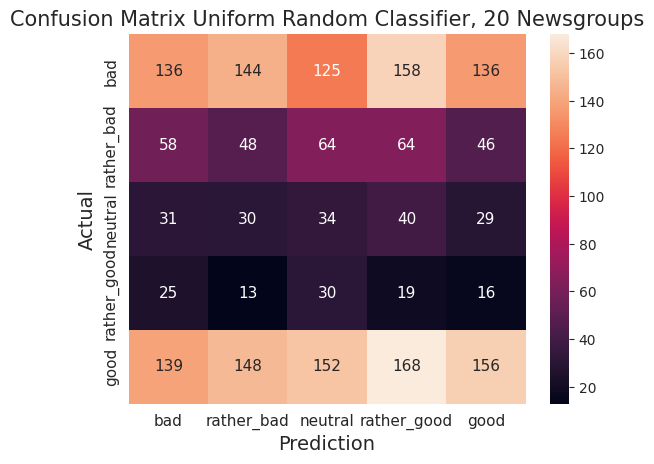

In [347]:
conf_matrix(
    np.array(data_initial_newsgroups["true_num"]), 
    np.array(data_initial_newsgroups["model_num"]), 
    model_name="Uniform Random Classifier, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    num_classes=5
)

In [348]:
# non-linear dependencies amazon
data_initial_amazon[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num        1.0        0.0
model_num       0.0        1.0

In [349]:
# non-linear dependencies 20 Newsgroups
data_initial_newsgroups[["true_num", "model_num"]].phik_matrix()

interval columns not set, guessing: ['true_num', 'model_num']


true_num  model_num
true_num   1.000000   0.022582
model_num  0.022582   1.000000

In [350]:
data_initial_amazon[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.006328
model_num  0.006328   1.000000

In [351]:
data_initial_newsgroups[["true_num", "model_num"]].corr()

true_num  model_num
true_num   1.000000   0.015649
model_num  0.015649   1.000000

In [352]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_initial_amazon["true_num"], data_initial_amazon["model_num"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_initial_newsgroups["true_num"], data_initial_newsgroups["model_num"]), 3))

Accuracy (Amazon): 0.205
Accuracy (20newsgroups): 0.196


In [353]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_initial_amazon["true_num"], data_initial_amazon["model_num"],  average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_initial_newsgroups["true_num"], data_initial_newsgroups["model_num"], average='macro'), 3))

F1-score (Amazon): 0.182
F1-score (20newsgroups): 0.171


### Mistral TYPE I
You are a helpful assistant evaluating the top words of a topic model output for a given topic. 

You will recieve a list of words. Please rate the following words on a scale from -2 to 2 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '-2' when words seem to be unconnected, '-1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '1' if some words are too common or out of topic, '2' if words have a strong connection between them, '0' if it's hard for you to answer on the question. Print the answer in the form: Answer: [rating]. Print only answer without explanation.

In [13]:
data_prompt_mistral_1.head(10)

text  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                           model  
0      Answer: 0.  This word set  
1      Answer: 0.  This word set  
2      Answer: 0.  This word set  
3      Answer: 0.  This word set  
4                 Answer: 0.</s>  
5      Answer: 0.  This word set  
6   Answer: 2.  These words have  
7                 Answer: 1.</s>  
8                Answer: -1.</s>  
9      Answer: 0.  This word set

In [24]:
# Clean data
# Remove </s>

data_prompt_mistral_1["model_extracted"] = [extract_answer_five_classes(x) for x in data_prompt_mistral_1["model"]]


In [26]:
data_prompt_mistral_1["model_extracted"].unique()

array([ 0,  2,  1, -1])

In [28]:
data_prompt_mistral_1["model"] = data_prompt_mistral_1["model_extracted"]

In [29]:
# Divide into two datasets
data_prompt_mistral_1_amazon = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(amazon_food_texts)]
data_prompt_mistral_1_newsgroups = data_prompt_mistral_1[data_prompt_mistral_1["text"].isin(newsgroups_texts)]

data_prompt_mistral_1_amazon.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_5classes_P1_amazon.csv"))
data_prompt_mistral_1_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_5classes_P1_newsgroup.csv"))

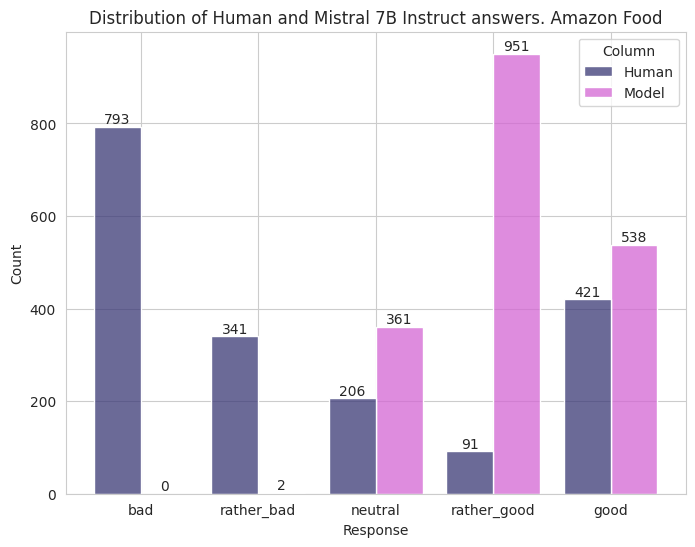

In [71]:
print_answers_distrib(
    data_prompt_mistral_1_amazon, 
    model_name='Mistral 7B Instruct', 
    dataset_name='Amazon Food',
    class_num=5
)

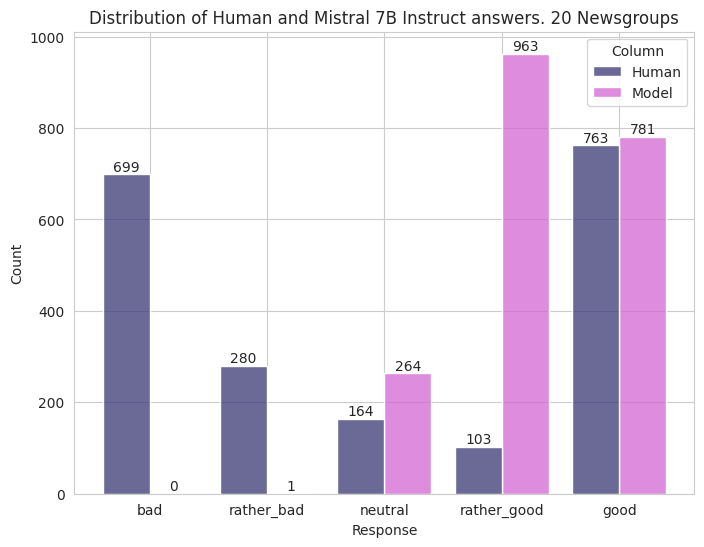

In [33]:
print_answers_distrib(
    data_prompt_mistral_1_newsgroups, 
    model_name='Mistral 7B Instruct', 
    dataset_name='20 Newsgroups',
    class_num=5
)

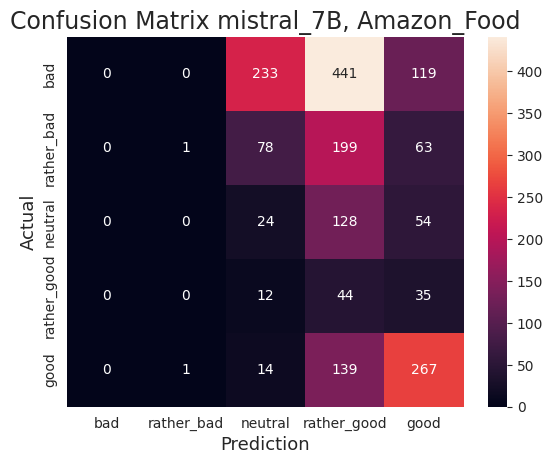

In [36]:
conf_matrix(
    np.array(data_prompt_mistral_1_amazon["true"]), 
    np.array(data_prompt_mistral_1_amazon["model"]), 
    model_name="mistral_7B, Amazon_Food",
    num_classes=5
)

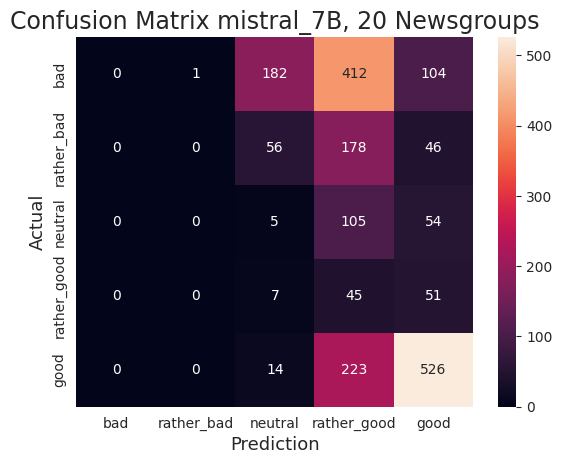

In [37]:
conf_matrix(
    np.array(data_prompt_mistral_1_newsgroups["true"]), 
    np.array(data_prompt_mistral_1_newsgroups["model"]), 
    model_name="mistral_7B, 20 Newsgroups",
    num_classes=5
)

In [38]:
# non-linear dependencies amazon
data_prompt_mistral_1_amazon[["true", "model"]].phik_matrix()

interval columns not set, guessing: ['true', 'model']


true     model
true   1.000000  0.314095
model  0.314095  1.000000

In [40]:
# non-linear dependencies amazon
data_prompt_mistral_1_newsgroups[["true", "model"]].phik_matrix()

interval columns not set, guessing: ['true', 'model']


true    model
true   1.00000  0.37604
model  0.37604  1.00000

In [43]:
# linear correlation amazon
       
data_prompt_mistral_1_amazon[["true", "model"]].corr()

true     model
true   1.000000  0.419261
model  0.419261  1.000000

In [44]:
# linear correlation 20 newsgroups
       
data_prompt_mistral_1_newsgroups[["true", "model"]].corr()

true     model
true   1.000000  0.523224
model  0.523224  1.000000

In [45]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_1_amazon["true"], data_prompt_mistral_1_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_1_newsgroups["true"], data_prompt_mistral_1_newsgroups["model"]), 3))

Accuracy (Amazon): 0.181
Accuracy (20newsgroups): 0.287


In [47]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_1_amazon["true"], data_prompt_mistral_1_amazon["model"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_1_newsgroups["true"], data_prompt_mistral_1_newsgroups["model"], average='macro'), 3))

F1-score (Amazon): 0.146
F1-score (20newsgroups): 0.158


### Mistral TYPE II
You are a useful assistant who evaluates the coherence of words.

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:

yes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

neutral - if it is hard for you to answer on the question.

Print only class without explanation and additional information.

In [48]:
data_prompt_mistral_2.head(10)

text  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  
0                                        neutral</s>  
1                                        neutral</s>  
2                                        neutral</s>  
3                                        neutral</s>  
4                                        neutral</s>  
5                                        neutral</s>  
6   rather yes. The words have some connection to...  
7                                     rather yes</s>  
8                                     rather no.</s>  
9                                        neutral</s>

In [53]:
# Clean data
# Remove </s>

data_prompt_mistral_2["model_extracted"] = [extract_answer_five_classes(x, answer_type="words") for x in data_prompt_mistral_2["model"]]


In [54]:
data_prompt_mistral_2

text  true  \
0     able amaze fill glad stop daily fantastic move...    -1   
1     able amaze fill stop glad daily fantastic move...    -1   
2     able amaze fill stop glad daily fantastic move...    -1   
3     able amaze glad fill stop fantastic daily move...    -2   
4     absolute church truth doug scripture symbol li...     1   
...                                                 ...   ...   
3856  year two size old every last month start since...    -1   
3857  year two size old every last month start week ...     2   
3858  year two size old last month every start week ...     0   
3859  year work two every size old last month start ...    -2   
3860  year work two size old last month start long w...    -2   

                                                model  model_extracted  
0                                         neutral</s>                0  
1                                         neutral</s>                0  
2                                         neutral</s>                0  
3                                         neutral</s>                0  
4                                         neutral</s>                0  
...                                               ...              ...  
3856      rather yes. The words can be related to the                1  
3857   rather yes. This word set is mostly related to                1  
3858                                      neutral</s>                0  
3859                                      neutral</s>                0  
3860                                   rather yes</s>                1  

[3861 rows x 4 columns]

In [55]:
data_prompt_mistral_2["model_extracted"].unique()

array([ 0,  1, -1,  2, -2])

In [56]:
data_prompt_mistral_2["model"] = data_prompt_mistral_2["model_extracted"]

In [57]:
# Divide into two datasets
data_prompt_mistral_2_amazon = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(amazon_food_texts)]
data_prompt_mistral_2_newsgroups = data_prompt_mistral_2[data_prompt_mistral_2["text"].isin(newsgroups_texts)]

data_prompt_mistral_2_amazon.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_5classes_P2_amazon.csv"))
data_prompt_mistral_2_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7b_4_bit_5classes_P2_newsgroup.csv"))

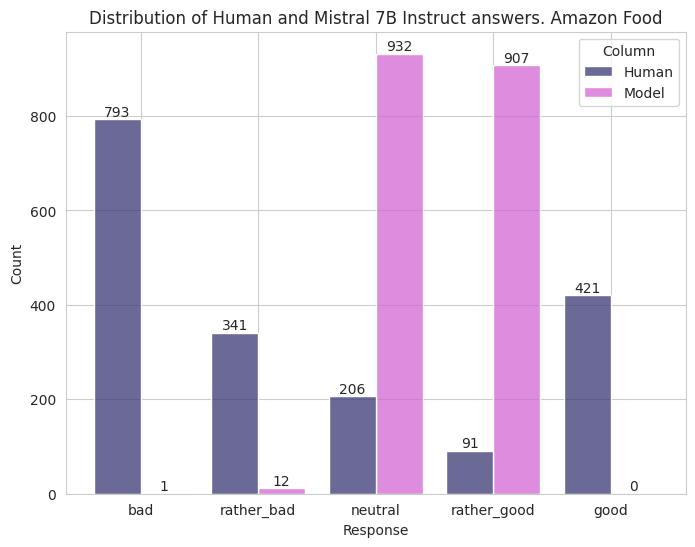

In [58]:
print_answers_distrib(
    data_prompt_mistral_2_amazon, 
    model_name='Mistral 7B Instruct', 
    dataset_name='Amazon Food',
    class_num=5
)

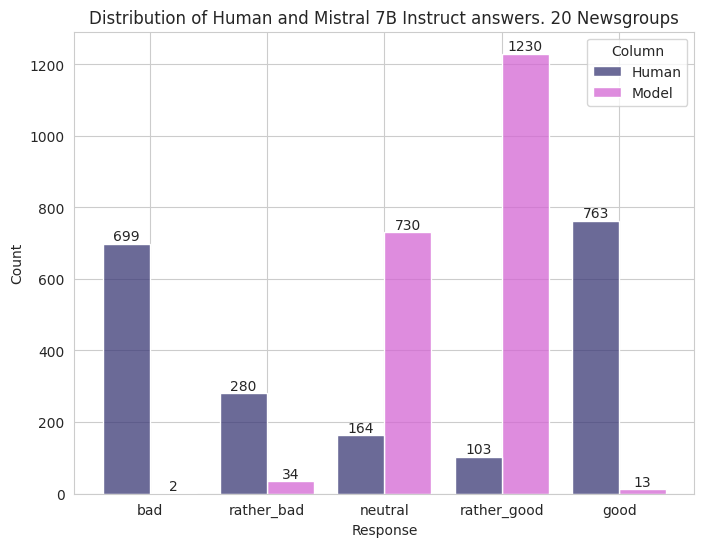

In [59]:
print_answers_distrib(
    data_prompt_mistral_2_newsgroups, 
    model_name='Mistral 7B Instruct', 
    dataset_name='20 Newsgroups',
    class_num=5
)

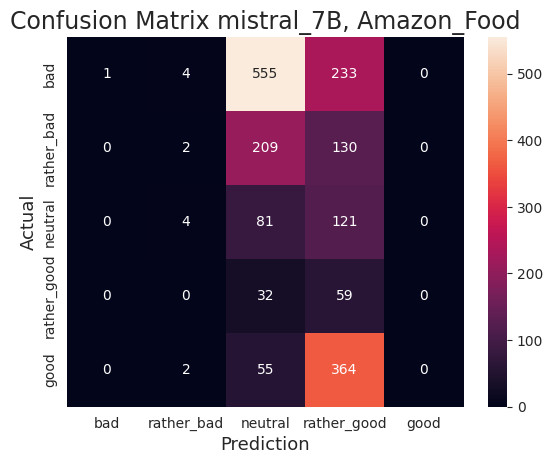

In [60]:
conf_matrix(
    np.array(data_prompt_mistral_2_amazon["true"]), 
    np.array(data_prompt_mistral_2_amazon["model"]), 
    model_name="mistral_7B, Amazon_Food",
    num_classes=5
)

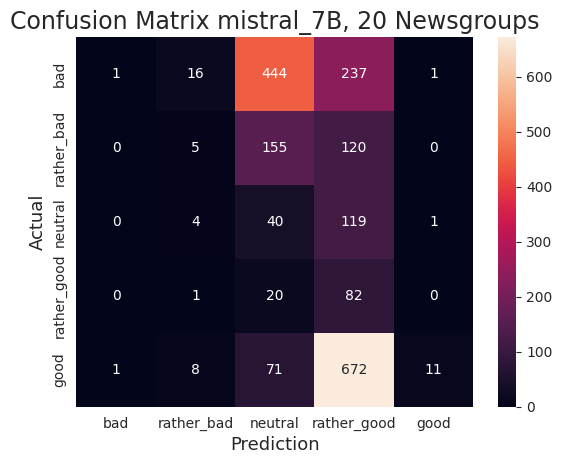

In [61]:
conf_matrix(
    np.array(data_prompt_mistral_2_newsgroups["true"]), 
    np.array(data_prompt_mistral_2_newsgroups["model"]), 
    model_name="mistral_7B, 20 Newsgroups",
    num_classes=5
)

In [62]:
# non-linear dependencies amazon
data_prompt_mistral_2_amazon[["true", "model"]].phik_matrix()

interval columns not set, guessing: ['true', 'model']


true     model
true   1.000000  0.319019
model  0.319019  1.000000

In [63]:
# non-linear dependencies 20 newsgroups
data_prompt_mistral_2_newsgroups[["true", "model"]].phik_matrix()

interval columns not set, guessing: ['true', 'model']


true     model
true   1.000000  0.596989
model  0.596989  1.000000

In [64]:
# non-linear dependencies amazon
data_prompt_mistral_2_amazon[["true", "model"]].corr()

true     model
true   1.000000  0.444607
model  0.444607  1.000000

In [65]:
# non-linear dependencies 20 newsgroups
data_prompt_mistral_2_newsgroups[["true", "model"]].corr()

true    model
true   1.00000  0.48258
model  0.48258  1.00000

In [66]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_mistral_2_amazon["true"], data_prompt_mistral_2_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_mistral_2_newsgroups["true"], data_prompt_mistral_2_newsgroups["model"]), 3))

Accuracy (Amazon): 0.077
Accuracy (20newsgroups): 0.069


In [67]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_mistral_2_amazon["true"], data_prompt_mistral_2_amazon["model"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_mistral_2_newsgroups["true"], data_prompt_mistral_2_newsgroups["model"], average='macro'), 3))

F1-score (Amazon): 0.055
F1-score (20newsgroups): 0.055


### Llama Type I
You are a useful assistant who evaluates the coherence of words.

You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.

Classification rules:\nyes - if words have a strong connection between them

rather yes - if some words are too common or out of topic

rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics

no - when words seem to be unconnected

neutral - if it is hard for you to answer on the question.\nPrint only class without explanation and additional information.

In [11]:
data_prompt_llama.head(10)

text  true  \
0  able amaze fill glad stop daily fantastic move...    -1   
1  able amaze fill stop glad daily fantastic move...    -1   
2  able amaze fill stop glad daily fantastic move...    -1   
3  able amaze glad fill stop fantastic daily move...    -2   
4  absolute church truth doug scripture symbol li...     1   
5  absolute church truth mission nasa doug mars e...    -1   
6  absolute mission church nasa mars earth truth ...     2   
7  absolutely fast white rice service noodle terr...    -1   
8  absolutely fast white super service customer r...     2   
9  absolutely grain experience soon there's proce...    -2   

                                               model  
0    Sure! Here's the classification of the given...  
1    Sure! Here's the classification of the given...  
2    Sure! Here's the classification of the given...  
3    Sure! Here's the classification of the given...  
4    Sure! Here's the classification of the given...  
5    Sure, I'd be happy to help!  Classification:...  
6    Sure! Here's the classification of the given...  
7    Sure! Here's the classification of the given...  
8    Sure! Here's the classification of the given...  
9    Sure! Here's the classification of the given...

In [12]:
# Clean data
# Remove </s>

data_prompt_llama["model_extracted"] = [extract_answer_five_classes(x, answer_type="words") for x in data_prompt_llama["model"]]

In [13]:
data_prompt_llama["model_extracted"].unique()

array([ 1, -1, -2])

In [16]:
print(data_prompt_llama.iloc[20]["true"])
print(data_prompt_llama.iloc[20]["model"])
print(data_prompt_llama.iloc[20]["model_extracted"])

-2
  Sure! Here's the classification of the given list of words:  Class: rather no</s>
-1


In [17]:
data_prompt_llama["model"] = data_prompt_llama["model_extracted"]

In [18]:
# Divide into two datasets
data_prompt_llama_amazon = data_prompt_llama[data_prompt_llama["text"].isin(amazon_food_texts)]
data_prompt_llama_newsgroups = data_prompt_llama[data_prompt_llama["text"].isin(newsgroups_texts)]

data_prompt_llama_amazon.to_csv(DATA_DIR.joinpath("text_coherence_Llama2_13B_4_bit_5classes_P1_amazon.csv"))
data_prompt_llama_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_Llama2_13B_4_bit_5classes_P1_newsgroup.csv"))

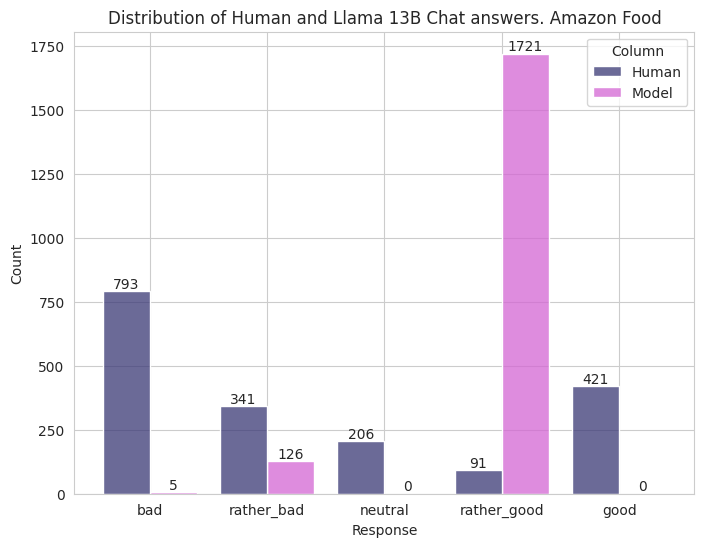

In [19]:
print_answers_distrib(
    data_prompt_llama_amazon, 
    model_name='Llama 13B Chat', 
    dataset_name='Amazon Food',
    class_num=5
)

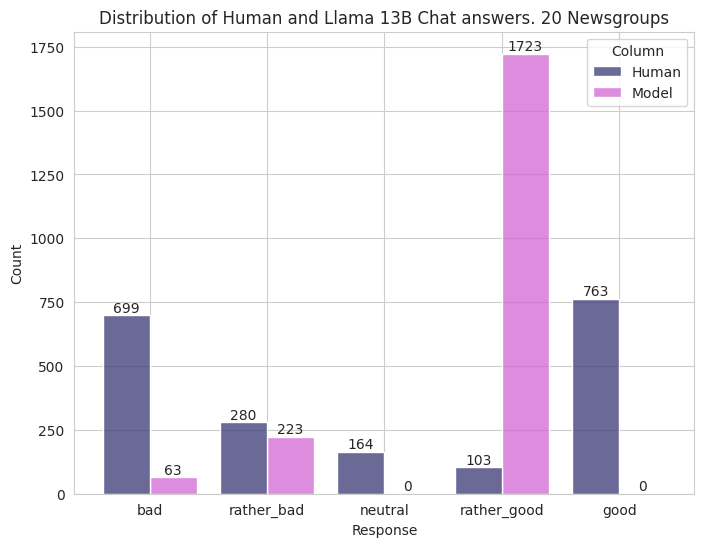

In [20]:
print_answers_distrib(
    data_prompt_llama_newsgroups, 
    model_name='Llama 13B Chat', 
    dataset_name='20 Newsgroups',
    class_num=5
)

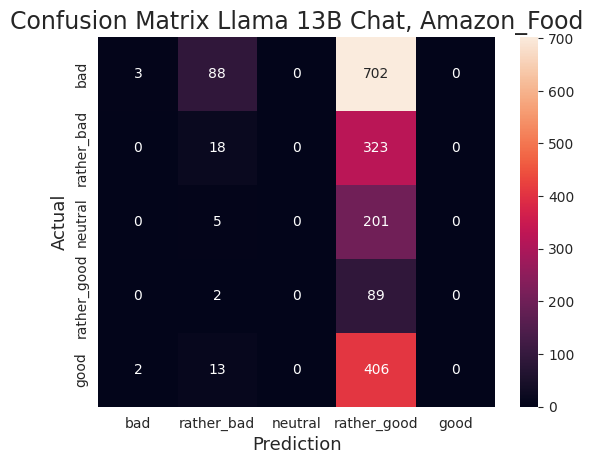

In [21]:
conf_matrix(
    np.array(data_prompt_llama_amazon["true"]), 
    np.array(data_prompt_llama_amazon["model"]), 
    model_name="Llama 13B Chat, Amazon_Food",
    num_classes=5
)

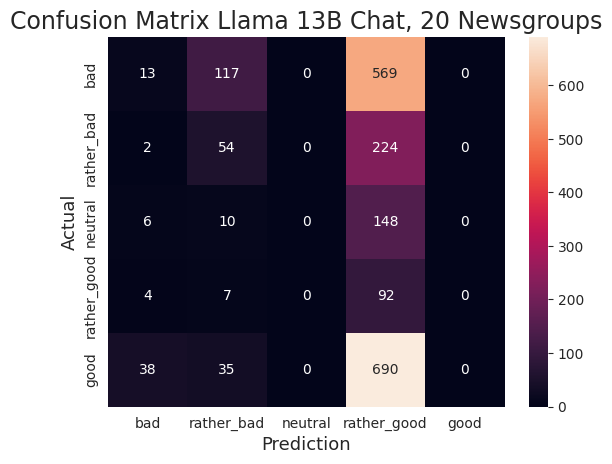

In [22]:
conf_matrix(
    np.array(data_prompt_llama_newsgroups["true"]), 
    np.array(data_prompt_llama_newsgroups["model"]), 
    model_name="Llama 13B Chat, 20 Newsgroups",
    num_classes=5
)

In [23]:
# non-linear dependencies amazon
data_prompt_llama_amazon[["true", "model"]].phik_matrix()

interval columns not set, guessing: ['true', 'model']


true     model
true   1.000000  0.133807
model  0.133807  1.000000

In [24]:
# non-linear dependencies 20 Newsgroups
data_prompt_llama_newsgroups[["true", "model"]].phik_matrix()

interval columns not set, guessing: ['true', 'model']


true     model
true   1.000000  0.191869
model  0.191869  1.000000

In [25]:
# non-linear dependencies amazon
data_prompt_llama_amazon[["true", "model"]].corr()

true    model
true   1.00000  0.12497
model  0.12497  1.00000

In [26]:
# non-linear dependencies amazon
data_prompt_llama_newsgroups[["true", "model"]].corr()

true     model
true   1.000000  0.089475
model  0.089475  1.000000

In [27]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_prompt_llama_amazon["true"], data_prompt_llama_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_prompt_llama_newsgroups["true"], data_prompt_llama_newsgroups["model"]), 3))

Accuracy (Amazon): 0.059
Accuracy (20newsgroups): 0.079


In [28]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_prompt_llama_amazon["true"], data_prompt_llama_amazon["model"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_prompt_llama_newsgroups["true"], data_prompt_llama_newsgroups["model"], average='macro'), 3))

F1-score (Amazon): 0.037
F1-score (20newsgroups): 0.07


### Mistral + LoRA (without system prompt)
r = 4
epochs = 2

In [50]:
data_lora_mistral.head(10)

Human Model                                            wordset
0   rather_bad  good  able amaze fill glad stop daily fantastic move...
1   rather_bad  good  able amaze fill stop glad daily fantastic move...
2   rather_bad  good  able amaze fill stop glad daily fantastic move...
3          bad  good  able amaze glad fill stop fantastic daily move...
4  rather_good   bad  absolute church truth doug scripture symbol li...
5   rather_bad  good  absolute church truth mission nasa doug mars e...
6         good   bad  absolute mission church nasa mars earth truth ...
7   rather_bad  good  absolutely fast white rice service noodle terr...
8         good  good  absolutely fast white super service customer r...
9          bad  good  absolutely grain experience soon there's proce...

In [51]:
data_lora_mistral.rename(
    {
        "Human": "true",
        "Model": "model"
    },
    inplace=True,
    axis=1
)

In [52]:
# Divide into two datasets
data_lora_mistral_amazon = data_lora_mistral[data_lora_mistral["wordset"].isin(amazon_food_texts)]
data_lora_mistral_newsgroups = data_lora_mistral[data_lora_mistral["wordset"].isin(newsgroups_texts)]

data_lora_mistral_amazon.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7B_LoRA_5classification_amazon.csv"))
data_lora_mistral_newsgroups.to_csv(DATA_DIR.joinpath("text_coherence_mistral_7B_LoRA_5classification_newsgroup.csv"))

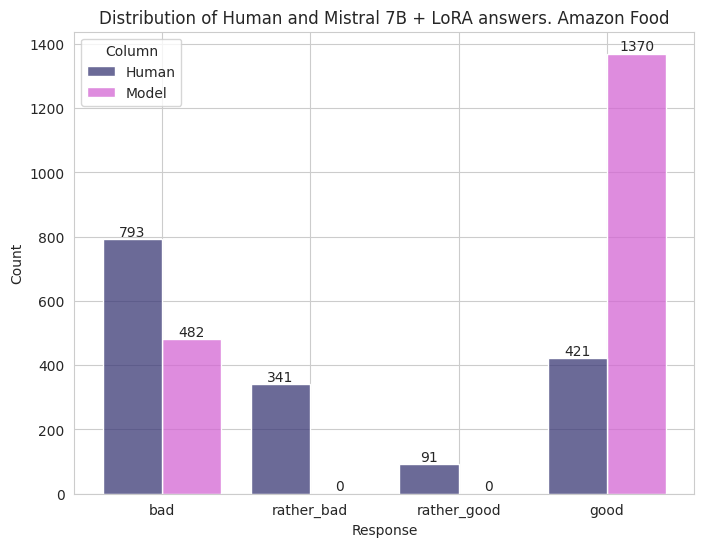

In [53]:
print_answers_distrib(
    data_lora_mistral_amazon, 
    model_name='Mistral 7B + LoRA', 
    dataset_name='Amazon Food'
)

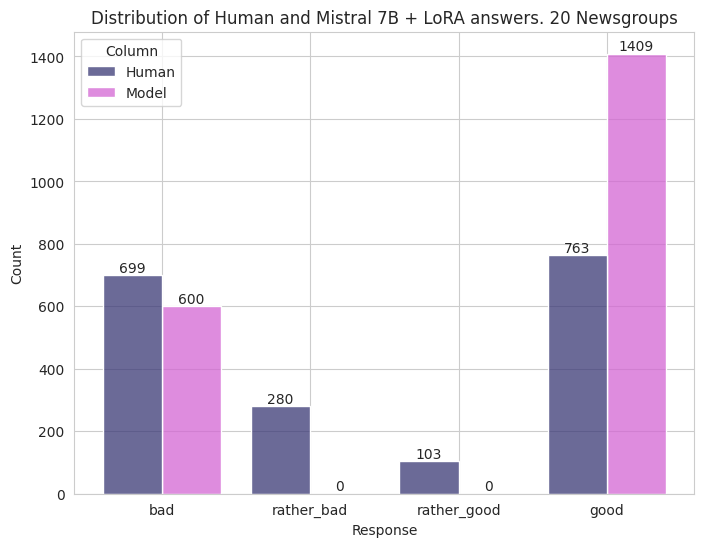

In [54]:
print_answers_distrib(
    data_lora_mistral_newsgroups, 
    model_name='Mistral 7B + LoRA', 
    dataset_name='20 Newsgroups'
)

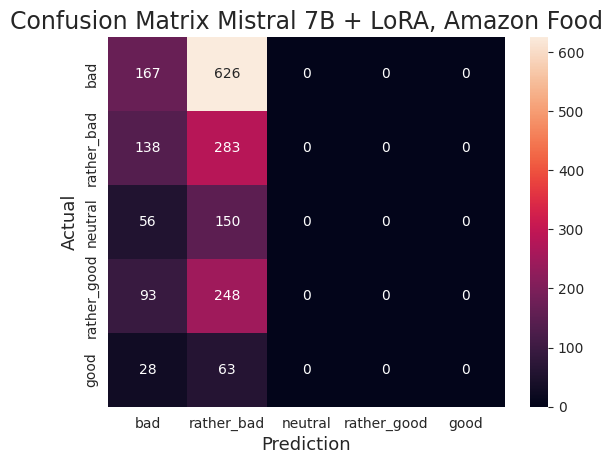

In [56]:
conf_matrix(
    np.array(data_lora_mistral_amazon["true"]), 
    np.array(data_lora_mistral_amazon["model"]), 
    model_name="Mistral 7B + LoRA, Amazon Food",
    num_classes=5
)

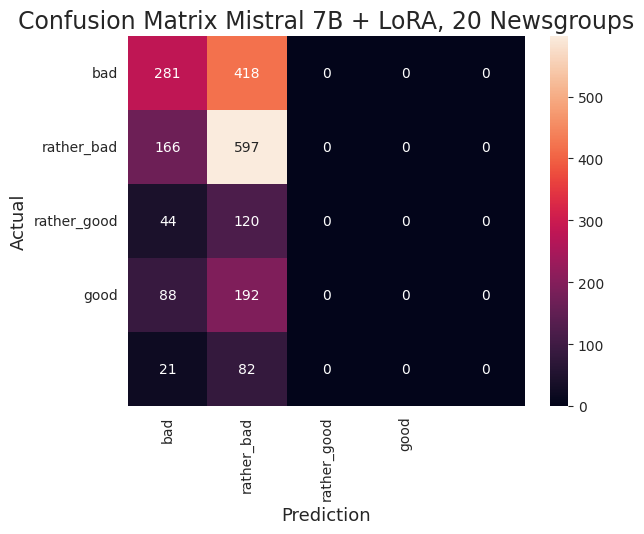

In [57]:
conf_matrix(
    np.array(data_lora_mistral_newsgroups["true"]), 
    np.array(data_lora_mistral_newsgroups["model"]), 
    model_name="Mistral 7B + LoRA, 20 Newsgroups",
    num_classes=4
)

In [58]:
# non-linear dependencies amazon
data_lora_mistral_amazon[["true", "model"]].phik_matrix()

true     model
true   1.000000  0.079792
model  0.079792  1.000000

In [59]:
# non-linear dependencies 20 Newsgroups
data_lora_mistral_newsgroups[["true", "model"]].phik_matrix()

true     model
true   1.000000  0.142685
model  0.142685  1.000000

In [62]:
# linear correlation 20 newsgroups
answer_map = {
    "neutral":0,
    "bad": 1,
    "rather_bad": 2,
    "rather_good": 3,
    "good": 4
}

data_lora_mistral_newsgroups["true_num"] = [answer_map[x] for x in data_lora_mistral_newsgroups["true"]]
data_lora_mistral_newsgroups["model_num"] = [answer_map[x] for x in data_lora_mistral_newsgroups["model"]]
       
data_lora_mistral_newsgroups[["true_num", "model_num"]].corr()

/tmp/ipykernel_512085/2399885991.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lora_mistral_newsgroups["true_num"] = [answer_map[x] for x in data_lora_mistral_newsgroups["true"]]
/tmp/ipykernel_512085/2399885991.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lora_mistral_newsgroups["model_num"] = [answer_map[x] for x in data_lora_mistral_newsgroups["model"]]


true_num  model_num
true_num   1.000000   0.145053
model_num  0.145053   1.000000

In [63]:
# Accuracy
print("Accuracy (Amazon):", round(accuracy_score(data_lora_mistral_amazon["true"], data_lora_mistral_amazon["model"]), 3))
print("Accuracy (20newsgroups):", round(accuracy_score(data_lora_mistral_newsgroups["true"], data_lora_mistral_newsgroups["model"]), 3))

Accuracy (Amazon): 0.243
Accuracy (20newsgroups): 0.437


In [64]:
# F1-score
print("F1-score (Amazon):", round(f1_score(data_lora_mistral_amazon["true"], data_lora_mistral_amazon["model"], average='macro'), 3))
print("F1-score (20newsgroups):", round(f1_score(data_lora_mistral_newsgroups["true"], data_lora_mistral_newsgroups["model"], average='macro'), 3))

F1-score (Amazon): 0.116
F1-score (20newsgroups): 0.196


# Naming


In [47]:
def extract_text_in_quotes(input_string):
    pattern = r'"(.*?)"' 
    matches = re.findall(pattern, input_string)
    matches = [string.replace(",", "") for string in matches]
    if len(matches) == 0:
        matches = input_string
    return matches


def extract_substring_after_word(input_string, target_word):
    index = input_string.find(target_word) 
    if index != -1: 
        substring = input_string[index + len(target_word):]  
        return substring.strip()  
    else:
        return input_string
    

def extract_words_in_quotes_after_phrase(input_string):
    pattern = r'the common topic.*? (is|be) "(.*?)"(?: (or|and) "(.*?)")?'  # Паттерн для поиска слов в кавычках после указанной фразы
    matches = re.findall(pattern, input_string)  # Ищем все совпадения с паттерном в строке
    extracted_words = [match[1] for match in matches]  # Извлекаем первое слово из найденных совпадений
    for match in matches:
        if match[3]:  # Если есть второе слово после "or" или "and", добавляем его в список
            extracted_words.append(match[3])
    if extracted_words:
        return extracted_words
    else:
        return input_string
    

def extract_words_between_topic_and_period(input_string):
    pattern = r'topic: (.*?)\.'  # Паттерн для поиска слов между "topic:" и "."
    matches = re.findall(pattern, input_string)  # Ищем все совпадения с паттерном в строке
    
    if matches:
        return matches
    else:
        return input_string
    

def extract_words_after_topic(input_string):
    if isinstance(input_string, list):
        return input_string
    #matches = re.findall(r"topic: (\w+)", input_string)
    matches = re.findall(r"topic: *(.*)", input_string)
    if matches:
        return matches
    else:
        return input_string
    

def extract_words_after_is(input_string):
    if isinstance(input_string, list):
        return input_string
    #matches = re.findall(r"topic: (\w+)", input_string)
    matches = re.findall(r"(?:topic is:|text is:) *(.*)", input_string)
    if matches:
        return matches
    else:
        return input_string

In [48]:
def get_word_embedding(word, tokenizer, model):
    # Токенизация и обработка слова
    inputs = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)

    # Получение эмбеддинга последнего слоя
    last_hidden_states = outputs.last_hidden_state

    # Возвращаем вектор первого токена (вектор слова)
    return last_hidden_states[0][0]

In [78]:
def print_cos_sim_distrib(amazon_data, newsgroups_data, model_name=""):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    
    fig.suptitle(model_name, fontsize=16)

    sns.histplot(data=amazon_data, x="cos_sim_class", ax=axs[0], color="#3A3875")    
    axs[0].set_title("Distribution of the cosine similarity classes Amazon Food")

    sns.histplot(data=newsgroups_data, x="cos_sim_class", ax=axs[1], color="#3A3875")
    axs[1].set_title("Distribution of the cosine similarity classes 20 Newsgroups")

    plt.tight_layout()

    plt.show()

In [50]:
PROMPT_MISTRAL_1 = "data_topic_name_distrib_mistral_7b_4bit_type1_1.csv"
PROMPT_MISTRAL_2 = "data_topic_name_distrib_mistral_7b_4bit_type2_1.csv"
PROMPT_MISTRAL_3 = "data_topic_name_distrib_mistral_7b_4bit_type3_1.csv"
PROMPT_MISTRAL_4 = "data_topic_name_distrib_mistral_7b_4bit_type_new.csv"
PROMPT_LLAMA_1 = "data_topic_name_distrib_llama_13B_4bit_type1.csv"
PROMPT_LLAMA_2 = "data_topic_name_distrib_llama_13B_4bit_new.csv"

PROMPT_MISTRAL_1 = DATA_DIR.joinpath(PROMPT_MISTRAL_1)
PROMPT_MISTRAL_2 = DATA_DIR.joinpath(PROMPT_MISTRAL_2)
PROMPT_MISTRAL_3 = DATA_DIR.joinpath(PROMPT_MISTRAL_3)
PROMPT_MISTRAL_4 = DATA_DIR.joinpath(PROMPT_MISTRAL_4)
PROMPT_LLAMA_1 = DATA_DIR.joinpath(PROMPT_LLAMA_1)
PROMPT_LLAMA_2 = DATA_DIR.joinpath(PROMPT_LLAMA_2)

data_prompt_mistral_1 = pd.read_csv(PROMPT_MISTRAL_1, sep=";", names=["text", "topic"])
data_prompt_mistral_2 = pd.read_csv(PROMPT_MISTRAL_2, sep=";", names=["text", "topic"])
data_prompt_mistral_3 = pd.read_csv(PROMPT_MISTRAL_3, sep=";", names=["text", "topic"])
data_prompt_mistral_4 = pd.read_csv(PROMPT_MISTRAL_4, sep=";", names=["text", "topic"])
data_prompt_llama_1 = pd.read_csv(PROMPT_LLAMA_1, sep=";", names=["text", "topic"])
data_prompt_llama_2 = pd.read_csv(PROMPT_LLAMA_2, sep=";", names=["text", "topic"])

#### Mistral Type I

[INST] You are a helpful, respectful and honest assistant for labeling topics. You will receive a list of words and you should analyze it and label list of words with one or few words. Please, make sure you to only return the topic and nothing more.


Text: ... [/INST]

In [70]:
data_prompt_mistral_1

text  \
0     policy peace israeli arab israel proposal tyre...   
1     drinking mild espresso aftertaste brewing latt...   
2     local piece grocery sell deal carry market gla...   
3     value teeth difficult msg pea bone spent rawh ...   
4     bill fire koresh clinton scott child batf comp...   
...                                                 ...   
2358  package fresh item receive arrive rice soup di...   
2359  period pittsburgh baseball boston player chica...   
2360  driver card sound cards mode utexas light diam...   
2361  image graphics user window code motif format s...   
2362  absolutely white fast super service customer r...   

                                                  topic  
0                           Israeli-Arab Peace Proposal  
1                                                Coffee  
2                                     Grocery shopping.  
3                           Topic: Health and Nutrition  
4      Bill, Fire, Koresh, Clinton, Scott, Child, Ba...  
...                                                 ...  
2358                                               Gift  
2359                                           Baseball  
2360                                        Driver Card  
2361         Graphics User Interface (GUI) Development.  
2362                                   Customer Service  

[2363 rows x 2 columns]

In [67]:
data_prompt_mistral_1 = data_prompt_mistral_1.applymap(lambda x: x.lower())
data_prompt_mistral_1["topic"] = [x.replace(".", "") for x in data_prompt_mistral_1["topic"]]
data_prompt_mistral_1["topic"] = [x.replace("/", ", ") for x in data_prompt_mistral_1["topic"]]
data_prompt_mistral_1["topic"] = [x.replace("-", " ") for x in data_prompt_mistral_1["topic"]]

for i, topic in enumerate(data_prompt_mistral_1["topic"]):
    # Extract topics in quotes
    topic = extract_text_in_quotes(topic)
    if isinstance(topic, list):
        topic = ", ".join(topic)

    topic = extract_substring_after_word(topic, "topic:")

    data_prompt_mistral_1["topic"].iloc[i] = topic

data_prompt_mistral_1["topic"] = [x.strip() for x in data_prompt_mistral_1["topic"]]

1. Для некоторых данных модель выдает просто список слов в качестве топиков. Предлагается убрать данные наборы

In [28]:
data_prompt_mistral_1["text_col_tmp"] = [data_prompt_mistral_1["topic"].iloc[i].replace(",", "").strip() for i in range(data_prompt_mistral_1.shape[0])]

In [29]:
data_prompt_mistral_1["tmp"] = data_prompt_mistral_1["text"] == data_prompt_mistral_1["text_col_tmp"]

In [30]:
data_prompt_mistral_1

text  \
0     policy peace israeli arab israel proposal tyre...   
1     drinking mild espresso aftertaste brewing latt...   
2     local piece grocery sell deal carry market gla...   
3     value teeth difficult msg pea bone spent rawh ...   
4     bill fire koresh clinton scott child batf comp...   
...                                                 ...   
2358  package fresh item receive arrive rice soup di...   
2359  period pittsburgh baseball boston player chica...   
2360  driver card sound cards mode utexas light diam...   
2361  image graphics user window code motif format s...   
2362  absolutely white fast super service customer r...   

                                                  topic  \
0                           israeli arab peace proposal   
1                                                coffee   
2                                      grocery shopping   
3                                  health and nutrition   
4     bill, fire, koresh, clinton, scott, child, bat...   
...                                                 ...   
2358                                               gift   
2359                                           baseball   
2360                                        driver card   
2361          graphics user interface (gui) development   
2362                                   customer service   

                                           text_col_tmp    tmp  
0                           israeli arab peace proposal  False  
1                                                coffee  False  
2                                      grocery shopping  False  
3                                  health and nutrition  False  
4     bill fire koresh clinton scott child batf comp...   True  
...                                                 ...    ...  
2358                                               gift  False  
2359                                           baseball  False  
2360                                        driver card  False  
2361          graphics user interface (gui) development  False  
2362                                   customer service  False  

[2363 rows x 4 columns]

In [31]:
print("The number of identical topics:", sum(data_prompt_mistral_1["tmp"]))
ids = data_prompt_mistral_1.index[data_prompt_mistral_1["tmp"]].tolist()
for text in data_prompt_mistral_1["text"].loc[ids]:
    print(text)


The number of identical topics: 132
bill fire koresh clinton scott child batf compound stratus waco cult tear agent burn today
berkeley court charge anti francisco hate dangerous jacket legal property judge california leather museum lawyer
nasa research science center launch earth satellite orbit internet national mission anonymous project april address
nasa science earth orbit mission launch library moon satellite news reference image shuttle access general
michael child koresh judge phil rutgers witness tear branch trial rock cult ians ence kaldis
chip star potato salty corn veggie reason vinegar kettle rating think still whole addictive garden
driver card memory machine running sound cards error simms instal anybody fine works check wonder
unix directory resource keyboard comp user application email graphics converter package server format library hardware
internet ground circuit water connect service tower contact email heat outlet plant site network nist
anonymous news bill public

In [32]:
data_prompt_mistral_1 = data_prompt_mistral_1[data_prompt_mistral_1["tmp"]==False]
data_prompt_mistral_1 = data_prompt_mistral_1.drop(["text_col_tmp", "tmp"], axis=1)

In [ ]:
data_prompt_mistral_1

text  \
0     policy peace israeli arab israel proposal tyre...   
1     drinking mild espresso aftertaste brewing latt...   
2     local piece grocery sell deal carry market gla...   
3     value teeth difficult msg pea bone spent rawh ...   
5     way drinking mild aftertaste espresso weird si...   
...                                                 ...   
2358  package fresh item receive arrive rice soup di...   
2359  period pittsburgh baseball boston player chica...   
2360  driver card sound cards mode utexas light diam...   
2361  image graphics user window code motif format s...   
2362  absolutely white fast super service customer r...   

                                          topic  
0                   israeli arab peace proposal  
1                                        coffee  
2                              grocery shopping  
3                   topic: health and nutrition  
5                                        coffee  
...                                         ...  
2358                                       gift  
2359                                   baseball  
2360                                driver card  
2361  graphics user interface (gui) development  
2362                           customer service  

[2231 rows x 2 columns]

Для одного набора текста модель выдала цитату (удалить из набора)

In [40]:
for topic in data_prompt_mistral_1["topic"]:
    print(topic)

israeli arab peace proposal
coffee
grocery shopping
health and nutrition
coffee
space exploration
technology, offers, sales, email, bike, phone, cost, internet, distribution, money
electronics
scsi controller
bulk buying
snacks
ingredient
coconut health benefits
morality, school, keith, caltech, animal, morality, human lives, definition, natural behavior, goal, humans, learning, solntze
performance upgrade
israel, palestine conflict
electrical wiring
uiuc, frank, love, andrew, cwru, james, thought, ever, chris, disclaimer, george michael
graphics, user, contact, info, package, format, unix, site, tool, machine, directory, code, type, library
healthy drinks
family, home, city, death, helmet, mother, father, child, apartment, left, kill
chocolate chip sauce
bottled water
food ingredients
weapon safety
salad dressing
feed
space exploration
drug court
image processing
sports
bottled drinks
house
graphics user interface (gui)
spicy asian cuisine
medicine
image graphics package format code u

In [38]:
print(data_prompt_mistral_1["text"].iloc[55])
print(data_prompt_mistral_1["topic"].iloc[55])

quality chicken meat vegetable hazelnut purchasing tuna turkey hooked pricey steak thick we're grill base
food shopping


Данный промпт не подходит, так как сложный процесс постобработки, часто на вопрос модель отвечает чисто списком исходных слов, аналогично второй вид промпта

#### Zero-Shot Mistral

You will receive a list of words and you should analyze it and name the common topic with one or few words.

In [68]:
data_prompt_mistral_3

text  \
0     scsi controller interface disk transfer bios f...   
1     natural list contains raw berry book usa herb ...   
2     package shipping plastic offer delivery four g...   
3     drug court legal police illegal laws charge pr...   
4     israeli arab tape population border village po...   
...                                                 ...   
2358  internet ground circuit water connect service ...   
2359  ground wire connect panel outlet circuit wirin...   
2360  argument moral keith ence conclusion imply def...   
2361  organic natural real expensive syrup high arti...   
2362  baseball period player boston season brave bal...   

                                                  topic  
0      The common topic in this list is "Storage Dev...  
1      The common topic in the given text is "natura...  
2      The common topic in the given text appears to...  
3      The common topic in the given text is "Legal ...  
4      The common topic in this list is "Israel-Pale...  
...                                                 ...  
2358   The common topic in the given text is "network."  
2359   The common topic in the given text is "electr...  
2360   The common topic in the given list of words i...  
2361   The common topic in this list of words is "fo...  
2362   The common topic in the given text is "baseba...  

[2363 rows x 2 columns]

In [74]:
# Extract topic in quotes
# The common topic ... is / to be " " / " " or " " / " " and " "

example_1 = 'the common topic in this list of words is "food" and "meat."'
example_2 = 'the common topic in the given text is "bulk buying" or "bulk purchasing."'
example_3 = 'the common topic in the given list of words is "display".'
example_4 = 'the common topic in the given text appears to be "shipping" and "delivery."'
example_5 = 'the common topic in this list of words is "coffee" and "tea" as they are both mentioned in the words "blend," "decaf," "caffeine," and "herbal."'
example_6 = 'space exploration.'
example_7 = 'the common topic is "Internet" and "Privacy."'
example_8 = 'the common topic in the given text could be "playthings" or "toys" as several words in the list are related to toys, such as "puppy," "toy," "play," "senseo," and "creamer."'

example_1 = extract_words_in_quotes_after_phrase(example_1)
example_2 = extract_words_in_quotes_after_phrase(example_2)
example_3 = extract_words_in_quotes_after_phrase(example_3)
example_4 = extract_words_in_quotes_after_phrase(example_4)
example_5 = extract_words_in_quotes_after_phrase(example_5)
example_6 = extract_words_in_quotes_after_phrase(example_6)
example_7 = extract_words_in_quotes_after_phrase(example_7)
example_8 = extract_words_in_quotes_after_phrase(example_8)

print(example_1)
print(example_2)
print(example_3)
print(example_4)
print(example_5)
print(example_6)
print(example_7)
print(example_8)

['food', 'meat.']
['bulk buying', 'bulk purchasing.']
['display']
['shipping', 'delivery.']
['coffee', 'tea']
space exploration.
['Internet', 'Privacy.']
['playthings', 'toys']


In [70]:

data_prompt_mistral_3["topic"] = [extract_words_in_quotes_after_phrase(topic) for topic in data_prompt_mistral_3["topic"]]

In [61]:
for topic in data_prompt_mistral_3["topic"]:
    print(topic)

['Storage Devices', 'Storage Interface']
['natural ingredients']
['shipping', 'delivery.']
['Legal Issues', 'Criminal Justice.']
['Israel-Palestine Conflict']
['spicy pepper sauce.']
['hardware']
['hockey.']
['study', 'effects']
['graphics']
['NASA', 'research']
['rice meal.']
['legal', 'lawyer']
['electrical wiring.']
['launch', 'project.']
['email', 'usenet news.']
['Sales', 'Offer.']
['beverages', 'drinks']
['graphics', 'image processing']
['Israel', 'encryption.']
['test', 'output']
['health.']
['food', 'drink.']
 Space exploration.
['Religion', 'Spirituality']
['Sale', 'Machine']
['diet', 'healthy eating.']
['genocide', 'massacre,']
['food', 'meal.']
['coffee', 'tea']
 Nazi Party, Hitler, Islam, Resurrection, History, Faith, Ence, Dead, Found, Ticket.
['Religion', 'Spirituality']
 Space exploration.
['time,']
['sale', 'selling']
['computer hardware', 'computer peripherals']
['food.']
['baby', 'child development.']
['soup.']
['food', 'breakfast foods']
 Topic: Morality and Ethics
[

#### Zero-Shot Llama-2  
< s > [INST] << SYS >> You are an assistant for topic modeling. << SYS >>
You will receive the TEXT and you should identify one or few TOPICS of the TEXT. Provide ONLY TOPICS and nothing more.
TEXT: bar sweet crunchy yummy cinnamon granola yogurt crunch cereal raisin flake snack almond combination blueberry
TOPIC: [/INST]

In [114]:
data_prompt_llama_1

text  \
0     population bullet arab israeli border village ...   
1     quote hell context death accept evil agree fee...   
2     enjoy strong morning brew blend bitter smooth ...   
3     worth packet waste splenda world horrible when...   
4     pres administration official congress secretar...   
...                                                 ...   
2376  sauce serve per regular save hot red bit spicy...   
2377  israel pres israeli encryption security arab p...   
2378  arab israeli israel policy thousand none borde...   
2379  land country care health drug disease money ha...   
2380  turkish turkey turk armenia greek nazi soviet ...   

                                                  topic  
0     Sure, I'd be happy to help!The topic of the te...  
1     Sure! Here's the topic of the text you provide...  
2     Sure! Here's the topic of the text you provide...  
3     Sure! Here's the topic of the text you provide...  
4     Sure! Here is the topic of the text you provid...  
...                                                 ...  
2376  Sure! Here's the topic of the text you provide...  
2377  Sure! Here is the topic of the text you provid...  
2378  Sure, I'd be happy to help!The topic of the te...  
2379   Sure, I'd be happy to help!Topic: Healthcare</s>  
2380  Sure, I can help you with that!TOPIC: Armenian...  

[2381 rows x 2 columns]

In [137]:
for topic in data_prompt_llama_1["topic"]:
    print(topic)

Sure, I'd be happy to help!The topic of the text you provided is:TOPIC: Religion</s>
Sure! Here's the topic of the text you provided:TOPIC: Death</s>
Sure! Here's the topic of the text you provided:TOPIC: Coffee</s>
Sure! Here's the topic of the text you provided:TOPIC: Sweeteners</s>
Sure! Here is the topic of the text you provided:TOPIC: POLITICS</s>
Sure! Here's the topic of the text you provided:TOPIC: Religion</s>
Sure, I'd be happy to help! Here's the topic of the text you provided:TOPIC: Education</s>
Sure! Here is the topic of the text you provided:TOPIC: Conflict and Violence in the Middle East</s>
Sure! Here's the topic of the text you provided:TOPIC: FOOD</s>
Sure! Here's the topic of the text you provided:TOPIC: Party Planning</s>
Sure! Here's the topic of the text you provided:TOPIC: Electronics</s>
Sure! Here is the topic of the text you provided:TOPIC: Space Exploration</s>
Sure, I'd be happy to help! Here are the topics I identified in the text you provided:TOPIC: Snack

In [138]:
data_prompt_llama_1["topic"] = [x.lower() for x in data_prompt_llama_1["topic"]]
data_prompt_llama_1["topic"] = [x.replace("</s>", "") for x in data_prompt_llama_1["topic"]]

In [132]:
data_prompt_llama_1["topic"] = [extract_words_between_topic_and_period(x) for x in data_prompt_llama_1["topic"]]
data_prompt_llama_1["topic"] = [extract_words_after_topic(x) for x in data_prompt_llama_1["topic"]]
data_prompt_llama_1["topic"] = [extract_words_after_is(x) for x in data_prompt_llama_1["topic"]]

#### Zero-shot Mistral New
You are the topic modeling assistant. You should extract the main theme that combines all the words from the list. Formulate it with a single word:

In [51]:
data_prompt_mistral_4

text  \
0     earth orbit nasa mission moon satellite lunar ...   
1     dog treat training liver greenies ball pup dog...   
2     morning breakfast light packet indiv mild conv...   
3     snack chip healthy tasty family cheese they're...   
4     hell alaska eternal liar motto main acad crazy...   
...                                                 ...   
2358  moral objective science morality keith animal ...   
2359  company insurance happy money private health a...   
2360  science moral objective study morality disease...   
2361  price islamic turbo tube charge cheer rice mon...   
2362  insurance care business mark ohio marriage sch...   

                                                  topic  
0      The main theme that combines all the words fr...  
1      The main theme that combines all the words fr...  
2      The main theme that combines all the words fr...  
3      The main theme that combines all the words fr...  
4      The main theme that combines all the words fr...  
...                                                 ...  
2358   The main theme that combines all the words fr...  
2359   The main theme that combines all the words fr...  
2360   The main theme that combines all the words fr...  
2361   The main theme that combines all the words fr...  
2362   The main theme that combines all the words fr...  

[2363 rows x 2 columns]

In [52]:
for topic in data_prompt_mistral_4["topic"]:
    print(topic)

 The main theme that combines all the words from the list is "space exploration."</s>
 The main theme that combines all the words from the list is "training."</s>
 The main theme that combines all the words from the list is "convenience".</s>
 The main theme that combines all the words from the list is "snacking."</s>
 The main theme that combines all the words from the list is "crazy."</s>
 The main theme that combines all the words from the list is "sweetener."</s>
 "Addictive"</s>
 The main theme that combines all the words from the list is "computer."</s>
 The main theme that combines all the words from the list is "health".</s>
 The main theme that combines all the words from the list is "healthy."</s>
 "Playoffs"</s>
 The main theme that combines all the words from the list is "Usenet".</s>
 The main theme that combines all the words from the list is "Religion".</s>
 The main theme that combines all the words from the list is "dessert."</s>
 The main theme that combines all the w

In [53]:
data_prompt_mistral_4["topic"] = [x.lower() for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace("</s>", "") for x in data_prompt_mistral_4["topic"]]
data_prompt_mistral_4["topic"] = [x.replace(".", "") for x in data_prompt_mistral_4["topic"]]

In [54]:
data_prompt_mistral_4["topic"] = [extract_text_in_quotes(x) for x in data_prompt_mistral_4["topic"]]

In [55]:
for i, topic in enumerate(data_prompt_mistral_4["topic"]):
    if isinstance(topic, str):
        data_prompt_mistral_4["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_mistral_4["topic"].iloc[i]):
            data_prompt_mistral_4["topic"].iloc[i][j] = data_prompt_mistral_4["topic"].iloc[i][j].strip()

In [56]:
data_prompt_mistral_4

text                topic
0     earth orbit nasa mission moon satellite lunar ...  [space exploration]
1     dog treat training liver greenies ball pup dog...           [training]
2     morning breakfast light packet indiv mild conv...        [convenience]
3     snack chip healthy tasty family cheese they're...           [snacking]
4     hell alaska eternal liar motto main acad crazy...              [crazy]
...                                                 ...                  ...
2358  moral objective science morality keith animal ...             [ethics]
2359  company insurance happy money private health a...         [healthcare]
2360  science moral objective study morality disease...             [ethics]
2361  price islamic turbo tube charge cheer rice mon...              [islam]
2362  insurance care business mark ohio marriage sch...           [marriage]

[2363 rows x 2 columns]

#### Get Real Data

In [57]:
# Extract human naming
BASE_DIR = Path('result_analysis.ipynb').resolve().parent.parent
original_data_dir = BASE_DIR.joinpath('data/datasets')
original_naming_file = "data_topic_name_distrib.csv"
original_naming_file = original_data_dir.joinpath(original_naming_file)
original_naming = pd.read_csv(original_naming_file, sep=",")

In [58]:
original_naming

INPUT:wordset OUTPUT:quality  \
0     able amaze fill stop glad daily fantastic move...           good   
1     absolute mission church nasa mars earth truth ...           good   
2     absolute mission church nasa mars earth truth ...           good   
3     absolute mission church nasa mars earth truth ...           good   
4     absolute mission church nasa mars earth truth ...           good   
...                                                 ...            ...   
5761  year two size old every last month start since...           good   
5762  year two size old every last month start week ...           good   
5763  year two size old every last month start week ...           good   
5764  year two size old every last month start week ...           good   
5765  year two size old last month every start week ...           good   

     OUTPUT:topic_name  topic_name_num  
0             feelings               1  
1           astrology                1  
2                 nasa               1  
3                space               1  
4       space mission                1  
...                ...             ...  
5761              year               1  
5762              baby               1  
5763             child               1  
5764             time                1  
5765              time               1  

[5766 rows x 4 columns]

In [59]:
# Extract topis for similar topics
topic_name_true = []
text_lst = []
unique_wordset = list(set(original_naming["INPUT:wordset"]))
for wordset in unique_wordset:
    text_lst.append(wordset)
    topics = list(set(original_naming["OUTPUT:topic_name"][original_naming["INPUT:wordset"]==wordset]))

    topic_name_true.append(topics)

original_topics_df = pd.DataFrame(data={"text": unique_wordset, "topics": topic_name_true})
original_topics_df

text  \
0     argument colorado music letter conclusion fall...   
1     salt bean dish cooking sea kitchen gourmet por...   
2     send address email news request message intern...   
3     greek turkish turkey cross armenia henrik turk...   
4     woman city home left building apartment mother...   
...                                                 ...   
2358  guess wave roger wrong tape story ryan previou...   
2359  quote hell death evil context accept feel agre...   
2360  price board monitor port shipping slot cards s...   
2361  less calorie protein amount low fat fiber weig...   
2362  stuff coconut case health tell weight differen...   

                                             topics  
0                                           [music]  
1                               [cooking, cooking ]  
2           [communication, mail, mailing, message]  
3     [different countries and nations, countries ]  
4                     [home and family , residence]  
...                                             ...  
2358                                       [guess ]  
2359                                    [god quote]  
2360                                    [computers]  
2361                [healthy lifestyle, diet guide]  
2362                            [coconut , health ]  

[2363 rows x 2 columns]

#### Simple Example

In [60]:
sen = [
    "cat",
    "kitty",
    "dog",
    "road",
    "fish",
    "tiger",
    "three cat"
]

In [61]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
#Encoding:
sen_embeddings = model.encode(sen)
sen_embeddings.shape

(7, 768)

In [62]:
#let's calculate cosine similarity for sentence 0:
cosine_similarity(
    [sen_embeddings[0]],
    sen_embeddings[1:]
)

array([[0.71756035, 0.23537238, 0.3100229 , 0.24783944, 0.5335132 ,
        0.94091886]], dtype=float32)

#### Calculate metric Mistral (пока возьмем, что модель формулирует одно слово как указано в промпте)

In [63]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_mistral_4["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_mistral_4["true_topic"] = original_topics_lst

In [64]:
data_prompt_mistral_4

text                topic  \
0     earth orbit nasa mission moon satellite lunar ...  [space exploration]   
1     dog treat training liver greenies ball pup dog...           [training]   
2     morning breakfast light packet indiv mild conv...        [convenience]   
3     snack chip healthy tasty family cheese they're...           [snacking]   
4     hell alaska eternal liar motto main acad crazy...              [crazy]   
...                                                 ...                  ...   
2358  moral objective science morality keith animal ...             [ethics]   
2359  company insurance happy money private health a...         [healthcare]   
2360  science moral objective study morality disease...             [ethics]   
2361  price islamic turbo tube charge cheer rice mon...              [islam]   
2362  insurance care business mark ohio marriage sch...           [marriage]   

                                        true_topic  
0     [space, space program, nasa researcg, lunar]  
1                       [dog training, pets , dog]  
2                                        [morning]  
3                                [snacks, snacks ]  
4                                           [fılm]  
...                                            ...  
2358         [morality, study of animals , values]  
2359                 [insurance, health insurance]  
2360                 [treatment , science article]  
2361                                      [islam ]  
2362                       [insurance, insurance ]  

[2363 rows x 3 columns]

In [65]:
for topic in data_prompt_mistral_4["topic"]:
    print(topic)

['space exploration']
['training']
['convenience']
['snacking']
['crazy']
['sweetener']
['addictive']
['computer']
['health']
['healthy']
['playoffs']
['usenet']
['religion']
['dessert']
['dessert']
['nation']
['purchase']
['coffee']
['religion']
['summer']
['natural']
['security']
['coffee']
['justice']
['sports']
['germany']
['care']
['medical']
['sports']
[' flavor']
['island']
['crime']
['food']
['healthy']
['dessert']
['baby']
['health']
['hardware']
['crime']
['spirituality']
['nutrition']
['gun control']
['natural']
['crime']
['convenience']
['electrical wiring']
['cooking']
['nutrition']
['display']
['healthy']
['hockey']
['baseball']
['healthy']
['bread']
['dessert']
['thai rice bowl']
[' space exploration']
['dessert']
['violence']
['drink']
['commerce']
['coffee']
['snack']
['nature']
['island']
['health']
['religion']
['snack']
['addiction']
['cooling']
['saturday']
['diet']
['summer']
['security']
['security']
['space exploration']
['israel']
[' electrical']
['grooming']
[

In [66]:
example = data_prompt_mistral_4.iloc[0]

topic_embeddings = model.encode(example["topic"])
true_topic_embeddings = model.encode(example["true_topic"])
true_topic_embeddings.shape

(4, 768)

In [67]:
cosine_similarity(
    topic_embeddings,
    true_topic_embeddings
)

array([[0.8688483 , 0.95342886, 0.7536278 , 0.72468615]], dtype=float32)

#### Data Preprocessing
1) Remove punktuation
2) Remove extraspaces
3) Lemmatize

In [68]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Необходимо скачать словарные ресурсы NLTK
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Функция для определения части речи, нужной для лемматизатора
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [69]:
data_preprocessor = data_preprocessing.TextPreprocessor(lang='eng')

for i in range(len(data_prompt_mistral_4["topic"])):
    topic = data_prompt_mistral_4.iloc[i]["topic"][0]
    true_topic = data_prompt_mistral_4.iloc[i]["true_topic"]

    # topic
    topic = data_preprocessor.remove_punct(topic)
    topic = data_preprocessor.remove_ext_spaces(topic)
    topic = data_preprocessor.tokenize(topic)
    topic = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in topic])

    # true topic
    for j, true_topic_tmp in enumerate(true_topic):
        true_topic_tmp = data_preprocessor.remove_punct(true_topic_tmp)
        true_topic_tmp = data_preprocessor.remove_ext_spaces(true_topic_tmp)
        true_topic_tmp = data_preprocessor.tokenize(true_topic_tmp)
        true_topic_tmp = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in true_topic_tmp])
        true_topic[j] = true_topic_tmp

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/alexandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
# Calculate average cosine similarity 
cos_sim_avg = []
for i in tqdm(range(data_prompt_mistral_4.shape[0])):
    sample = data_prompt_mistral_4.iloc[i]

    topic_embeddings = model.encode(sample["topic"])
    true_topic_embeddings = model.encode(sample["true_topic"])

    cos_sim = cosine_similarity(topic_embeddings, true_topic_embeddings)[0]
    cos_sim_avg.append(sum(cos_sim) / len(cos_sim))

data_prompt_mistral_4["cos_sim"] = cos_sim_avg

  0%|          | 0/2363 [00:00<?, ?it/s]

100%|██████████| 2363/2363 [03:58<00:00,  9.90it/s]


In [71]:
data_prompt_mistral_4

text                topic  \
0     earth orbit nasa mission moon satellite lunar ...  [space exploration]   
1     dog treat training liver greenies ball pup dog...           [training]   
2     morning breakfast light packet indiv mild conv...        [convenience]   
3     snack chip healthy tasty family cheese they're...           [snacking]   
4     hell alaska eternal liar motto main acad crazy...              [crazy]   
...                                                 ...                  ...   
2358  moral objective science morality keith animal ...             [ethics]   
2359  company insurance happy money private health a...         [healthcare]   
2360  science moral objective study morality disease...             [ethics]   
2361  price islamic turbo tube charge cheer rice mon...              [islam]   
2362  insurance care business mark ohio marriage sch...           [marriage]   

                                        true_topic   cos_sim  
0     [space, space program, nasa researcg, lunar]  0.825148  
1                         [dog training, pet, dog]  0.617334  
2                                        [morning]  0.555207  
3                                   [snack, snack]  0.949242  
4                                           [fılm]  0.469943  
...                                            ...       ...  
2358            [morality, study of animal, value]  0.696786  
2359                 [insurance, health insurance]  0.766396  
2360                  [treatment, science article]  0.557746  
2361                                       [islam]  1.000000  
2362                        [insurance, insurance]  0.593686  

[2363 rows x 4 columns]

Semantic cosine similarity ranges:
1. Very High Similarity: VH

**Cosine similarity: 0.8 to 1.0**

This range suggests that the vectors are almost identical in orientation, indicating a very high degree of similarity.

2. High Similarity: H

**Cosine similarity: 0.6 to 0.8**

Vectors are closely aligned, suggesting a high level of similarity.

3. Moderate Similarity: M

**Cosine similarity: 0.3 to 0.6**

This range indicates a moderate level of similarity, with vectors somewhat aligned.

4. Low Similarity: L

**Cosine similarity: 0 to 0.3**

Vectors are not very well aligned, suggesting a low degree of similarity.

5. Very Low or Negative Similarity: VL

**Cosine similarity: -1.0 to 0**

A negative value indicates that the vectors are pointing in more opposite directions, suggesting dissimilarity. Values close to 0 but negative might indicate a very low degree of similarity.

In [72]:
cos_sim_range = []

for cos_sim in data_prompt_mistral_4["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_mistral_4["cos_sim_class"] = cos_sim_range

In [73]:
data_prompt_mistral_4

text                topic  \
0     earth orbit nasa mission moon satellite lunar ...  [space exploration]   
1     dog treat training liver greenies ball pup dog...           [training]   
2     morning breakfast light packet indiv mild conv...        [convenience]   
3     snack chip healthy tasty family cheese they're...           [snacking]   
4     hell alaska eternal liar motto main acad crazy...              [crazy]   
...                                                 ...                  ...   
2358  moral objective science morality keith animal ...             [ethics]   
2359  company insurance happy money private health a...         [healthcare]   
2360  science moral objective study morality disease...             [ethics]   
2361  price islamic turbo tube charge cheer rice mon...              [islam]   
2362  insurance care business mark ohio marriage sch...           [marriage]   

                                        true_topic   cos_sim cos_sim_class  
0     [space, space program, nasa researcg, lunar]  0.825148            VH  
1                         [dog training, pet, dog]  0.617334             H  
2                                        [morning]  0.555207             M  
3                                   [snack, snack]  0.949242            VH  
4                                           [fılm]  0.469943             M  
...                                            ...       ...           ...  
2358            [morality, study of animal, value]  0.696786             H  
2359                 [insurance, health insurance]  0.766396             H  
2360                  [treatment, science article]  0.557746             M  
2361                                       [islam]  1.000000            VH  
2362                        [insurance, insurance]  0.593686             M  

[2363 rows x 5 columns]

In [74]:
# Divide entire data into two datasets
data_prompt_mistral_4_amazon = data_prompt_mistral_4[data_prompt_mistral_4["text"].isin(amazon_food_texts)]
data_prompt_mistral_4_newsgroups = data_prompt_mistral_4[data_prompt_mistral_4["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_mistral_4_amazon.shape)
print(f"20newsgroups:", data_prompt_mistral_4_newsgroups.shape)

Amazon: (932, 5)
20newsgroups: (1431, 5)


/tmp/ipykernel_19413/671716890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_mistral_4_amazon["cos_sim_class"] = pd.Categorical(
/tmp/ipykernel_19413/671716890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_mistral_4_newsgroups["cos_sim_class"] = pd.Categorical(


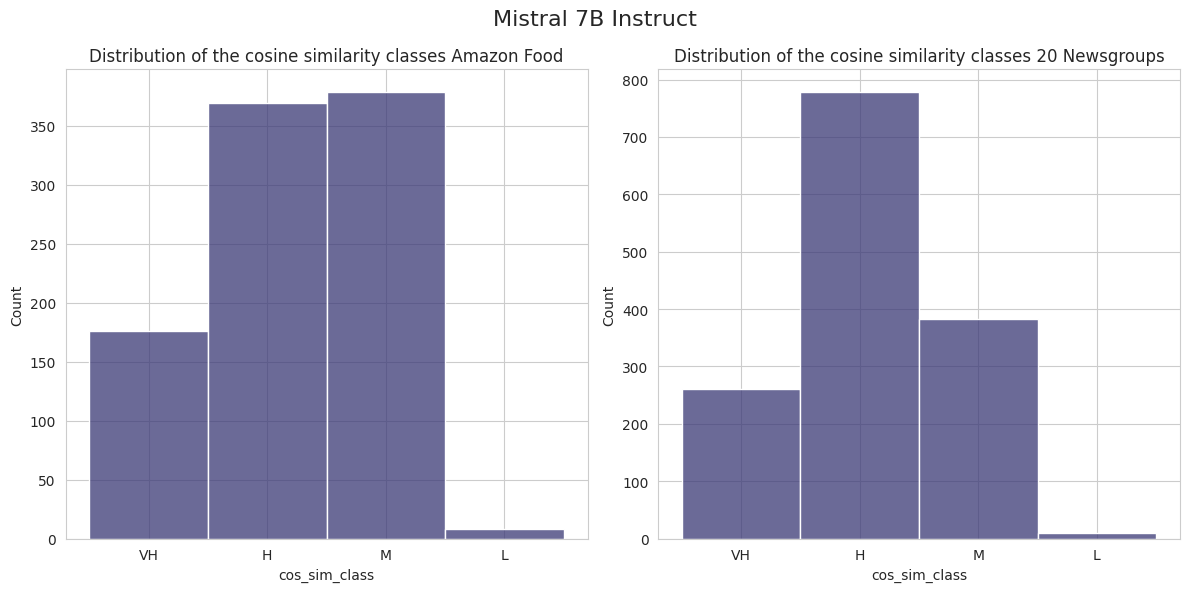

In [79]:
data_prompt_mistral_4_amazon["cos_sim_class"] = pd.Categorical(
    data_prompt_mistral_4_amazon['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)
data_prompt_mistral_4_newsgroups["cos_sim_class"] = pd.Categorical(
    data_prompt_mistral_4_newsgroups['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)



(data_prompt_mistral_4_amazon, data_prompt_mistral_4_newsgroups, model_name="Mistral 7B Instruct")

In [104]:
data_prompt_mistral_4_amazon.to_csv(DATA_DIR.joinpath("topic_name_mistral_7B_amazon.csv"))
data_prompt_mistral_4_newsgroups.to_csv(DATA_DIR.joinpath("topic_name_mistral_7B_20newsgroup.csv"))

In [105]:
grouped_cos_sim_amazon = data_prompt_mistral_4_amazon['cos_sim_class'].value_counts().sort_index()
grouped_cos_sim_newsgroups = data_prompt_mistral_4_newsgroups['cos_sim_class'].value_counts().sort_index()

In [106]:
print("Amazon_food:\n", grouped_cos_sim_amazon)
print("20newsgroups:\n", grouped_cos_sim_newsgroups)

Amazon_food:
 VH    176
H     369
M     379
L       8
VL      0
Name: cos_sim_class, dtype: int64
20newsgroups:
 VH    260
H     779
M     383
L       9
VL      0
Name: cos_sim_class, dtype: int64


#### Zero-shot Llama New
< s >[INST] << SYS >> You are the topic modeling assistant. <<\SYS>> You should understand the main theme that combines all the words from the list. Formulate it with a single word, print only this word in quotes and no additional text: quality chicken meat ingredient vegetable purchasing salmon hazelnut pricey base turkey tuna filler steak actually [/INST]

In [80]:
data_prompt_llama_2

text  \
0     encryption chip clipper security phone privacy...   
1     function code text islam muslim null subject e...   
2     package fresh item receive rice arrive gift di...   
3     chew pod pound toy bone caramel larger play pe...   
4     player hockey season league goal leaf playoff ...   
...                                                 ...   
2358  free gluten salmon balance wet higher bpa turk...   
2359  vanilla keurig k-cups french k-cup aroma light...   
2360  last long gum hope date online dec original pa...   
2361  bit hot buying sauce serve per save cost cheap...   
2362  soup rice candy pasta thanks noodle service cu...   

                                                  topic  
0     Sure! Based on the list of words provided, the...  
1     Sure! Based on the list of words provided, the...  
2     Sure! Based on the list of words you provided,...  
3     Sure! Based on the list of words you provided,...  
4     Sure! Based on the list of words you provided,...  
...                                                 ...  
2358  Sure ! Based on the list of words you provided...  
2359  Sure ! Based on the list of words provided , t...  
2360  Sure , I ' d be happy to help ! Based on the l...  
2361  Sure ! Based on the list of words you provided...  
2362  Sure ! Based on the list of words you provided...  

[2363 rows x 2 columns]

In [81]:
for topic in data_prompt_llama_2["topic"]:
    print(topic)

Sure! Based on the list of words provided, the main theme that combines all the words is:  "SECURITY"</s>
Sure! Based on the list of words provided, the main theme that combines all the words is "RESEARCH".</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is:  "GIFT"</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "PETS" so I will print the word "PETS" in quotes.</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "HOCKEY".</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "coffee."  So, the single word that summarizes the list is:  "Coffee"</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "GRANOLA".</s>
Sure! Based on the list of words you provided, the main theme that combines all the words is "HOCKEY."</s>
Sure! Based on the list of words provided, the 

In [82]:
data_prompt_llama_2["topic"] = [x.lower() for x in data_prompt_llama_2["topic"]]
data_prompt_llama_2["topic"] = [x.replace("</s>", "") for x in data_prompt_llama_2["topic"]]
data_prompt_llama_2["topic"] = [x.replace(".", "") for x in data_prompt_llama_2["topic"]]
data_prompt_llama_2["topic"] = [extract_text_in_quotes(x) for x in data_prompt_llama_2["topic"]]

In [83]:
for i, topic in enumerate(data_prompt_llama_2["topic"]):
    if isinstance(topic, str):
        data_prompt_llama_2["topic"].iloc[i] = [topic]
        topic = topic.strip()
    else:
        for j, elem in enumerate(data_prompt_llama_2["topic"].iloc[i]):
            data_prompt_llama_2["topic"].iloc[i][j] = data_prompt_llama_2["topic"].iloc[i][j].strip()

#### Calculate metric Llama-2

In [84]:
# Combine model topics with original ones
original_topics_lst = []

for text in data_prompt_llama_2["text"]:
    original_topic = original_topics_df.loc[original_topics_df["text"]==text, "topics"].values[0]
    original_topics_lst.append(original_topic)

data_prompt_llama_2["true_topic"] = original_topics_lst

In [85]:
for i in range(len(data_prompt_llama_2["topic"])):
    topic = data_prompt_llama_2.iloc[i]["topic"][0]
    true_topic = data_prompt_llama_2.iloc[i]["true_topic"]

    # topic
    topic = data_preprocessor.remove_punct(topic)
    topic = data_preprocessor.remove_ext_spaces(topic)
    topic = data_preprocessor.tokenize(topic)
    topic = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in topic])

    # true topic
    for j, true_topic_tmp in enumerate(true_topic):
        true_topic_tmp = data_preprocessor.remove_punct(true_topic_tmp)
        true_topic_tmp = data_preprocessor.remove_ext_spaces(true_topic_tmp)
        true_topic_tmp = data_preprocessor.tokenize(true_topic_tmp)
        true_topic_tmp = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in true_topic_tmp])
        true_topic[j] = true_topic_tmp

In [86]:
# Calculate average cosine similarity 
cos_sim_avg = []
for i in tqdm(range(data_prompt_llama_2.shape[0])):
    sample = data_prompt_llama_2.iloc[i]

    topic_embeddings = model.encode(sample["topic"])
    true_topic_embeddings = model.encode(sample["true_topic"])

    cos_sim = cosine_similarity(topic_embeddings, true_topic_embeddings)[0]
    cos_sim_avg.append(sum(cos_sim) / len(cos_sim))

data_prompt_llama_2["cos_sim"] = cos_sim_avg

100%|██████████| 2363/2363 [04:03<00:00,  9.71it/s]


In [87]:
cos_sim_range = []

for cos_sim in data_prompt_llama_2["cos_sim"]:
    if cos_sim >= 0.8:
        cos_sim_range.append("VH")
    elif cos_sim >= 0.6 and cos_sim < 0.8:
        cos_sim_range.append("H")
    elif cos_sim >= 0.3 and cos_sim < 0.6:
        cos_sim_range.append("M")
    elif cos_sim >= 0.0 and cos_sim < 0.3:
        cos_sim_range.append("L")
    else:
        cos_sim_range.append("VL")

data_prompt_llama_2["cos_sim_class"] = cos_sim_range

In [88]:
# Divide entire data into two datasets
data_prompt_llama_2_amazon = data_prompt_llama_2[data_prompt_llama_2["text"].isin(amazon_food_texts)]
data_prompt_llama_2_newsgroups = data_prompt_llama_2[data_prompt_llama_2["text"].isin(newsgroups_texts)]
print(f"Amazon:", data_prompt_llama_2_amazon.shape)
print(f"20newsgroups:", data_prompt_llama_2_newsgroups.shape)

Amazon: (932, 5)
20newsgroups: (1431, 5)


In [89]:
data_prompt_llama_2_amazon.to_csv(DATA_DIR.joinpath("topic_name_llama_amazon.csv"))
data_prompt_llama_2_newsgroups.to_csv(DATA_DIR.joinpath("topic_name_llama_20newsgroup.csv"))

/tmp/ipykernel_19413/3269716064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_2_amazon["cos_sim_class"] = pd.Categorical(
/tmp/ipykernel_19413/3269716064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prompt_llama_2_newsgroups["cos_sim_class"] = pd.Categorical(


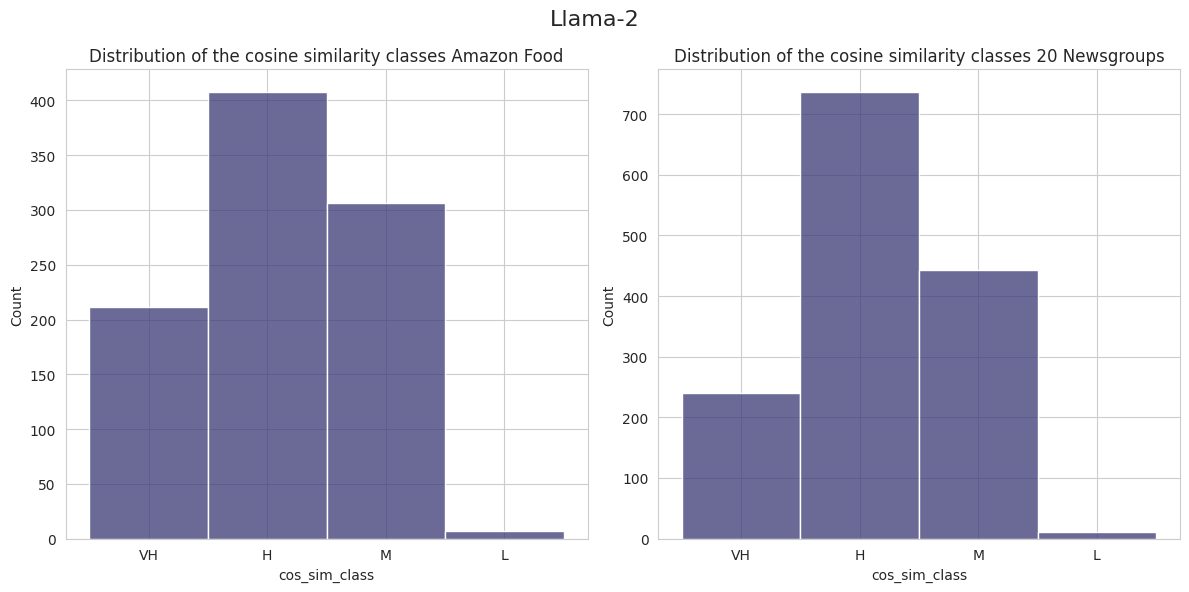

In [90]:
data_prompt_llama_2_amazon["cos_sim_class"] = pd.Categorical(
    data_prompt_llama_2_amazon['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)
data_prompt_llama_2_newsgroups["cos_sim_class"] = pd.Categorical(
    data_prompt_llama_2_newsgroups['cos_sim_class'], 
    categories=['VH', 'H', 'M', 'L', 'VL'], ordered=True
)

print_cos_sim_distrib(data_prompt_llama_2_amazon, data_prompt_llama_2_newsgroups, model_name="Llama-2")

In [273]:
grouped_cos_sim_amazon = data_prompt_llama_2_amazon['cos_sim_class'].value_counts().sort_index()
grouped_cos_sim_newsgroups = data_prompt_llama_2_newsgroups['cos_sim_class'].value_counts().sort_index()

In [274]:
print("Amazon_food:\n", grouped_cos_sim_amazon)
print("20newsgroups:\n", grouped_cos_sim_newsgroups)

Amazon_food:
 VH    211
H     408
M     306
L       7
VL      0
Name: cos_sim_class, dtype: int64
20newsgroups:
 VH    240
H     737
M     443
L      11
VL      0
Name: cos_sim_class, dtype: int64
